# Creating event data from sample flight data by using batch ingestion

There are a number of best practices for modeling and laying out data for OLTP databases, like Apache Druid, that are focused on event analytics. Using Druid's example datasets, available through the Data Loader on the Druid Console, you can apply these in a meaningful way.

In this notebook, you'll walk through creating a table of events out of the Flight Carrier sample data set. At the end you'll have a `TABLE` called "flight-events" that contains one row per event from the source data that you can then use as you continue your learning in Apache Druid.

## Prerequisites

This tutorial works with Druid 26.0.0 or later.

Launch this tutorial and all prerequisites using the `druid-jupyter` profile of the Docker Compose file for Jupyter-based Druid tutorials. For more information, see [Docker for Jupyter Notebook tutorials](https://druid.apache.org/docs/latest/tutorials/tutorial-jupyter-docker.html).

<details><summary>    
<b>Run without Docker Compose</b>    
</summary>

If you do not use the Docker Compose environment, you need the following:

* A running Druid instance.
* [druidapi](https://github.com/apache/druid/blob/master/examples/quickstart/jupyter-notebooks/druidapi/README.md), a Python client for Apache Druid. Follow the instructions in the Install section of the README file.
* [pandas](https://pandas.pydata.org/), a data analysis and manipulation tool.
* Jupyter notebook or Jupyter Lab. See [jupyter.org](https://jupyter.org/) for installation instructions.

</details>

## Initialization

Run the next cell to attempt a connection to Druid services. If successful, the Druid version number will be shown in the output.

In [ ]:
import druidapi
import os

if 'DRUID_HOST' not in os.environ.keys():
    druid_host=f"http://localhost:8888"
else:
    druid_host=f"http://{os.environ['DRUID_HOST']}:8888"

print(f"Opening a connection to {druid_host}.")
druid = druidapi.jupyter_client(druid_host)
display = druid.display
sql_client = druid.sql
status_client = druid.status

status_client.version

Run the following cell for the final part of the initialization.

In [ ]:
import pandas as pd

## Apply modeling principles

You're going to apply six principles as you bring in the Flight data example, using some techniques that are popular in the community. These are good to have in mind for any ingestion that you do, whether that's through batch uploads or if you're doing streaming. And Data Engineers should get into the habit of revisiting these every-so-often to fine tune how you have laid out and modeled your data.

This notebook runs several ingestions that will take some time to execute.

Use the Druid Console to monitor each ingestion as they run. To do this, open the __Query__ tab and open the __Recent query tasks__ pane.

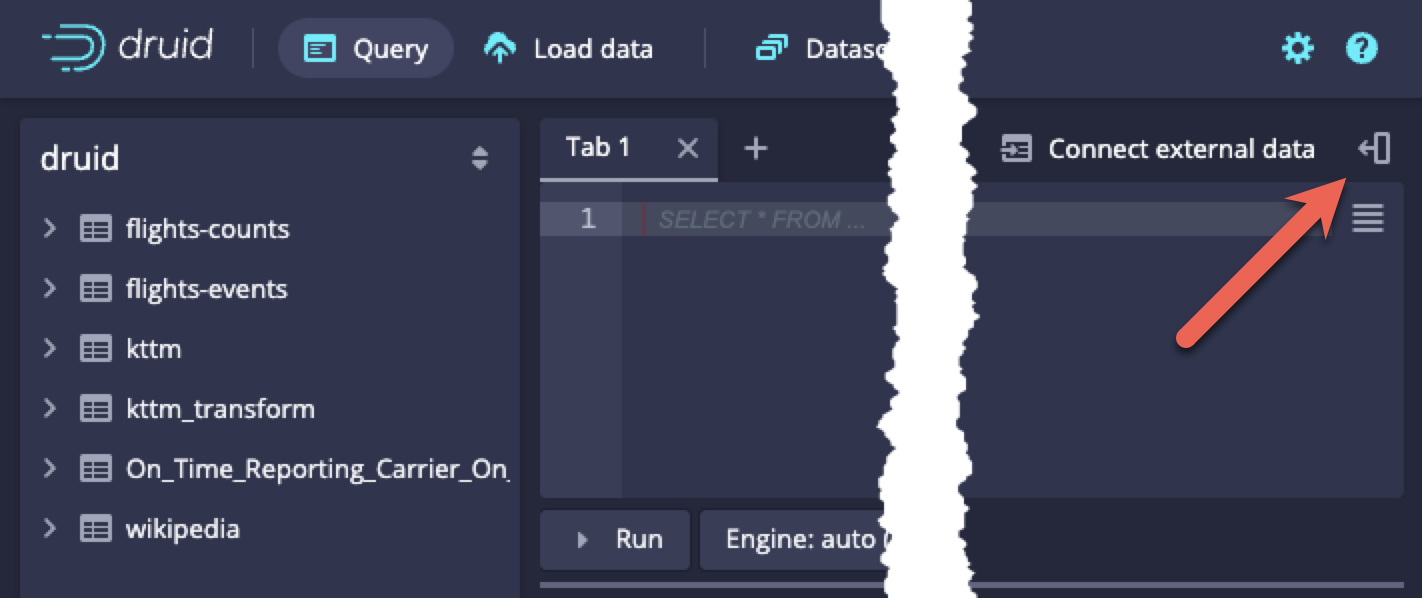

From here, select the executing ingestion query, and select __Show details__.

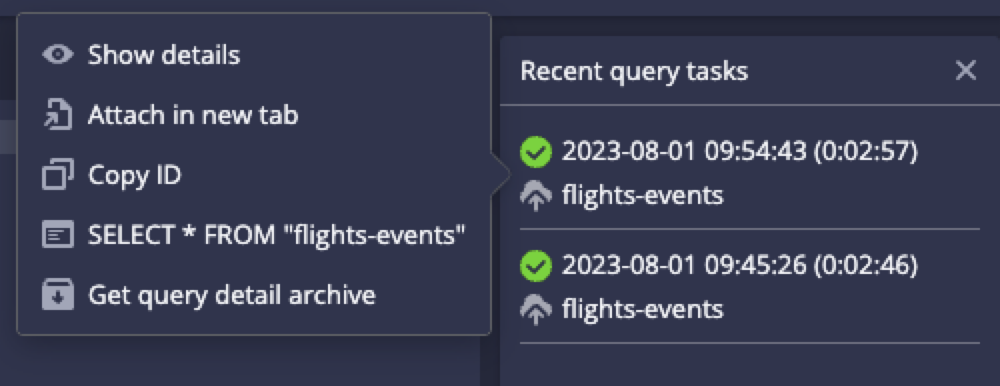

### Principle 1 - create the right `TABLE` for the right query

Here, we'll take a look at the source data, and we'll design a schema that works for the types of queries that we imagine might be run on it. Using the example data, you'll create a table that has one timestamp per row - a very simple Event - rather than ingesting the table as-is with multiple timestamps per row.

#### Defining the Events

By taking a look at the [dataset explainer](https://dax-cdn.cdn.appdomain.cloud/dax-airline/1.0.1/data-preview/index.html), you will notice how each row is **not** an event. Instead, each row represents a single flight - a "session" - containing information about the entire flight. In this notebook, you will reverse engineer this multiple-event-per-row layout into a single table that has multiple events from each row.

> You can also preview the data in the Druid Console:
> 
> 1. Open the console
> 2. Select Load data --> Batch - SQL (multi-stage query)
> 3. Click Example data and select "FlightCarrierOnTime (1 month)
> 4. Click Use Example

There are quite a few event types aggregated into each row, including:

* Data about the departure
* Data about takeoff (wheels off)
* Data about landing (wheels on)
* Data about arrival
* Taxi In
* Taxi Out

There are also records of diversions, cancellations, and so on – without timestamps for this, we're not going to be able to create individual events. Through this notebook, you will see how it's possible to add individual events only for departure and arrival.

There are some fields that can _only_ be calculated once the flight (session) has landed, such as the distance flown.

It's possible to categorize the source columns as follows.

| field |  | description | common | dep | takeoff | landing | arrival |
|---|---|---|---|---|---|---|---|
| __time |  | When the event occured |  | depaturetime | FlightDate + WheelsOff | FlightDate + WheelsOn | arrivalime |
| attributes |  | Things to `GROUP BY` or `WHERE` | Reporting_Airline <br> DOT_ID_Reporting_Airline <br> IATA_CODE_Reporting_Airline <br> Tail_Number <br> Flight_Number_ReportingAirline | OriginAirportID <br> OriginAirportSeqID <br> OriginCityMarketID <br> Origin <br> OriginCityName <br> OriginState <br> OriginStateFips <br> OriginStateName <br> OriginWac |  |  | DestAirportID <br> DestAirportSeqID <br> DestCityMarketID <br> Dest <br> DestCityName <br> DestState <br> DestStateFips <br> DestStateName <br> DestWac |
| measures |  | Data for calculations at query time | Year <br> Quarter <br> Month <br> DayofMonth <br> DayOfWeek <br> FlightDate | CRSDepTime |  |  | CRSArrTime |
| measures (existing) |  | Source data fields that can be recalculated |  | DepTime DepDelay DepDelayMinutes DepDel15 DepartureDelayGroups DepTimeBlk |  |  | ArrTime <br> ArrDelay <br> ArrDelayMinutes <br> ArrDel15 <br> ArrivalDelayGroups <br> ArrTimeBlk |

#### Drafting an Event table

Let's define a single schema that covers all the types of events that will land into the `flight-events` table. We're looking for our timestamps and dimensions (measures and attributes).

| field type | description | When it happened | What happened | What it happened to | Where it happened |
|---|---|---|---|---|---|
| attributes | Things to `GROUP BY` or `WHERE` |  | EventType | Reporting_Airline <br> DOT_ID_Reporting_Airline <br> IATA_CODE_Reporting_Airline <br> Tail_Number <br> Flight_Number_ReportingAirline | AirportID <br> AirportSeqID <br> CityMarketID <br> Airport <br> CityName <br> State <br> StateFips <br> StateName <br> Wac |
| measures | Data for calculations at query time | __time <br> CRSTime |  |  |  |

Now let's go back to the console and create an `INSERT` statement that we can apply the data modeling principles to, starting with an event that represents the "departure" event.

From the Parse screen, hit Next to go to the Configure Schema page.

Let's start by removing fields that we do not need. You can either click the SQL button and edit this manually, or you can do it interactively by clicking a column heading and using the Delete button.

* arrivalime (we are only looking at the Departure event)
* Year
* Quarter
* Month
* DayofMonth
* DayOfWeek
* FlightDate

Next, we can remove any fields that are not relevant to departures and any fields that we can calculate on a row-by-row basis. In a POC, you would check if the calculation speed is fast enough to avoid storing them, or whether you need to keep these pre-calculated values. Also, remember that this data is sessionized, so some calculations like `Distance` will only be available in the full import, and not in the Events table.

Let's also `AS` the columns to fit our Event schema naming convention.

Final step – adding our `EventType` dimension that sets this import as being about "Departure Events".

Thanks to the Druid console, our resulting `SELECT` is given below. You can paste this over the `SELECT` portion in your own data loader.

```sql
SELECT
  TIME_PARSE("depaturetime") AS "__time",
  'Departure' AS "EventType",
  "Reporting_Airline",
  "DOT_ID_Reporting_Airline",
  "IATA_CODE_Reporting_Airline",
  "Tail_Number",
  "Flight_Number_Reporting_Airline",
  "OriginAirportID" AS "AirportID",
  "OriginAirportSeqID" AS "AirportSeqID",
  "OriginCityMarketID" AS "CityMarketID",
  "Origin" AS "Airport",
  "OriginCityName" AS "CityName",
  "OriginState" AS "State",
  "OriginStateFips" AS "StateFips",
  "OriginStateName" AS "StateName",
  "OriginWac" AS "Wac",
  "CRSDepTime" AS "CRSTime"
```

#### Try it out

Let's load the data!

When this task is complete, you will see a description of the table in the next cell. Monitor the task in your Druid console for more insight.

In [ ]:
sql= '''
REPLACE INTO "flights-events" OVERWRITE ALL
WITH "ext" AS (SELECT *
FROM TABLE(
  EXTERN(
    '{"type":"http","uris":["https://static.imply.io/example-data/flight_on_time/flights/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2005_11.csv.zip"]}',
    '{"type":"csv","findColumnsFromHeader":true}'
  )
) EXTEND ("depaturetime" VARCHAR, "arrivalime" VARCHAR, "Year" BIGINT, "Quarter" BIGINT, "Month" BIGINT, "DayofMonth" BIGINT, "DayOfWeek" BIGINT, "FlightDate" VARCHAR, "Reporting_Airline" VARCHAR, "DOT_ID_Reporting_Airline" BIGINT, "IATA_CODE_Reporting_Airline" VARCHAR, "Tail_Number" VARCHAR, "Flight_Number_Reporting_Airline" BIGINT, "OriginAirportID" BIGINT, "OriginAirportSeqID" BIGINT, "OriginCityMarketID" BIGINT, "Origin" VARCHAR, "OriginCityName" VARCHAR, "OriginState" VARCHAR, "OriginStateFips" BIGINT, "OriginStateName" VARCHAR, "OriginWac" BIGINT, "DestAirportID" BIGINT, "DestAirportSeqID" BIGINT, "DestCityMarketID" BIGINT, "Dest" VARCHAR, "DestCityName" VARCHAR, "DestState" VARCHAR, "DestStateFips" BIGINT, "DestStateName" VARCHAR, "DestWac" BIGINT, "CRSDepTime" BIGINT, "DepTime" BIGINT, "DepDelay" BIGINT, "DepDelayMinutes" BIGINT, "DepDel15" BIGINT, "DepartureDelayGroups" BIGINT, "DepTimeBlk" VARCHAR, "TaxiOut" BIGINT, "WheelsOff" BIGINT, "WheelsOn" BIGINT, "TaxiIn" BIGINT, "CRSArrTime" BIGINT, "ArrTime" BIGINT, "ArrDelay" BIGINT, "ArrDelayMinutes" BIGINT, "ArrDel15" BIGINT, "ArrivalDelayGroups" BIGINT, "ArrTimeBlk" VARCHAR, "Cancelled" BIGINT, "CancellationCode" VARCHAR, "Diverted" BIGINT, "CRSElapsedTime" BIGINT, "ActualElapsedTime" BIGINT, "AirTime" BIGINT, "Flights" BIGINT, "Distance" BIGINT, "DistanceGroup" BIGINT, "CarrierDelay" BIGINT, "WeatherDelay" BIGINT, "NASDelay" BIGINT, "SecurityDelay" BIGINT, "LateAircraftDelay" BIGINT, "FirstDepTime" VARCHAR, "TotalAddGTime" VARCHAR, "LongestAddGTime" VARCHAR, "DivAirportLandings" VARCHAR, "DivReachedDest" VARCHAR, "DivActualElapsedTime" VARCHAR, "DivArrDelay" VARCHAR, "DivDistance" VARCHAR, "Div1Airport" VARCHAR, "Div1AirportID" VARCHAR, "Div1AirportSeqID" VARCHAR, "Div1WheelsOn" VARCHAR, "Div1TotalGTime" VARCHAR, "Div1LongestGTime" VARCHAR, "Div1WheelsOff" VARCHAR, "Div1TailNum" VARCHAR, "Div2Airport" VARCHAR, "Div2AirportID" VARCHAR, "Div2AirportSeqID" VARCHAR, "Div2WheelsOn" VARCHAR, "Div2TotalGTime" VARCHAR, "Div2LongestGTime" VARCHAR, "Div2WheelsOff" VARCHAR, "Div2TailNum" VARCHAR, "Div3Airport" VARCHAR, "Div3AirportID" VARCHAR, "Div3AirportSeqID" VARCHAR, "Div3WheelsOn" VARCHAR, "Div3TotalGTime" VARCHAR, "Div3LongestGTime" VARCHAR, "Div3WheelsOff" VARCHAR, "Div3TailNum" VARCHAR, "Div4Airport" VARCHAR, "Div4AirportID" VARCHAR, "Div4AirportSeqID" VARCHAR, "Div4WheelsOn" VARCHAR, "Div4TotalGTime" VARCHAR, "Div4LongestGTime" VARCHAR, "Div4WheelsOff" VARCHAR, "Div4TailNum" VARCHAR, "Div5Airport" VARCHAR, "Div5AirportID" VARCHAR, "Div5AirportSeqID" VARCHAR, "Div5WheelsOn" VARCHAR, "Div5TotalGTime" VARCHAR, "Div5LongestGTime" VARCHAR, "Div5WheelsOff" VARCHAR, "Div5TailNum" VARCHAR, "Unnamed: 109" VARCHAR))
SELECT
  TIME_PARSE("depaturetime") AS "__time",
  'Departure' AS "EventType",
  "Reporting_Airline",
  "DOT_ID_Reporting_Airline",
  "IATA_CODE_Reporting_Airline",
  "Tail_Number",
  "Flight_Number_Reporting_Airline",
  "OriginAirportID" AS "AirportID",
  "OriginAirportSeqID" AS "AirportSeqID",
  "OriginCityMarketID" AS "CityMarketID",
  "Origin" AS "Airport",
  "OriginCityName" AS "CityName",
  "OriginState" AS "State",
  "OriginStateFips" AS "StateFips",
  "OriginStateName" AS "StateName",
  "OriginWac" AS "Wac",
  "CRSDepTime" AS "CRSTime"
FROM "ext"
PARTITIONED BY DAY
'''

sql_client.run_task(sql)
sql_client.wait_until_ready('flights-events')
display.table('flights-events')

Let's run a simple `SELECT` to see how our data looks.

Our results will show something important ... we haven't been through all the modelling principles!

In [ ]:
sql= '''
SELECT
  TIME_FLOOR("__time", 'P1D') AS "Time",
  StateName,
  COUNT(*) AS "Count"
FROM "flights-events"
GROUP BY 1, 2
ORDER BY 1 ASC
LIMIT 25
'''

display.sql(sql)

#### What's up with the timestamps?

Our `__time` timestamps are sometimes empty. With a look back at the original data, you'll spot that there is never a timestamp if the flight is cancelled. Therefore we need to add a `WHERE` to our select so that those rows do not get parsed.

```sql
WHERE "Cancelled" = 0
```

In this notebook, we're also making some important assumptions that you may not make if this was a real dataset!

* all flights that arrive will, naturally, depart - so will always have a departure timestamp, and
* the timezone of this timestamp is UTC.

There's also another time-based field in our data – the scheduled departure time. This is currently only the `hhmm`. Making a few assumptions (!) we can do better by turning it into an actual timestamp with a concatenation. Padding is required as the source data does not always have a leading zero.

```sql
TIME_PARSE("FlightDate" || ' ' || RIGHT('00' || "CRSDepTime",4),'YYYY-MM-dd hhmm') AS "__timeCRS"
```

Let's update the `SELECT` so that we at least filter out any cancellations, and ingest our data again. Notice that we are using `REPLACE` with `OVERWRITE ALL` to [completely overwrite](https://druid.apache.org/docs/26.0.0/multi-stage-query/reference.html#replace-all-data) this `TABLE`.

In [ ]:
sql= '''
REPLACE INTO "flights-events" OVERWRITE ALL
WITH "ext" AS (SELECT *
FROM TABLE(
  EXTERN(
    '{"type":"http","uris":["https://static.imply.io/example-data/flight_on_time/flights/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2005_11.csv.zip"]}',
    '{"type":"csv","findColumnsFromHeader":true}'
  )
) EXTEND ("depaturetime" VARCHAR, "arrivalime" VARCHAR, "Year" BIGINT, "Quarter" BIGINT, "Month" BIGINT, "DayofMonth" BIGINT, "DayOfWeek" BIGINT, "FlightDate" VARCHAR, "Reporting_Airline" VARCHAR, "DOT_ID_Reporting_Airline" BIGINT, "IATA_CODE_Reporting_Airline" VARCHAR, "Tail_Number" VARCHAR, "Flight_Number_Reporting_Airline" BIGINT, "OriginAirportID" BIGINT, "OriginAirportSeqID" BIGINT, "OriginCityMarketID" BIGINT, "Origin" VARCHAR, "OriginCityName" VARCHAR, "OriginState" VARCHAR, "OriginStateFips" BIGINT, "OriginStateName" VARCHAR, "OriginWac" BIGINT, "DestAirportID" BIGINT, "DestAirportSeqID" BIGINT, "DestCityMarketID" BIGINT, "Dest" VARCHAR, "DestCityName" VARCHAR, "DestState" VARCHAR, "DestStateFips" BIGINT, "DestStateName" VARCHAR, "DestWac" BIGINT, "CRSDepTime" BIGINT, "DepTime" BIGINT, "DepDelay" BIGINT, "DepDelayMinutes" BIGINT, "DepDel15" BIGINT, "DepartureDelayGroups" BIGINT, "DepTimeBlk" VARCHAR, "TaxiOut" BIGINT, "WheelsOff" BIGINT, "WheelsOn" BIGINT, "TaxiIn" BIGINT, "CRSArrTime" BIGINT, "ArrTime" BIGINT, "ArrDelay" BIGINT, "ArrDelayMinutes" BIGINT, "ArrDel15" BIGINT, "ArrivalDelayGroups" BIGINT, "ArrTimeBlk" VARCHAR, "Cancelled" BIGINT, "CancellationCode" VARCHAR, "Diverted" BIGINT, "CRSElapsedTime" BIGINT, "ActualElapsedTime" BIGINT, "AirTime" BIGINT, "Flights" BIGINT, "Distance" BIGINT, "DistanceGroup" BIGINT, "CarrierDelay" BIGINT, "WeatherDelay" BIGINT, "NASDelay" BIGINT, "SecurityDelay" BIGINT, "LateAircraftDelay" BIGINT, "FirstDepTime" VARCHAR, "TotalAddGTime" VARCHAR, "LongestAddGTime" VARCHAR, "DivAirportLandings" VARCHAR, "DivReachedDest" VARCHAR, "DivActualElapsedTime" VARCHAR, "DivArrDelay" VARCHAR, "DivDistance" VARCHAR, "Div1Airport" VARCHAR, "Div1AirportID" VARCHAR, "Div1AirportSeqID" VARCHAR, "Div1WheelsOn" VARCHAR, "Div1TotalGTime" VARCHAR, "Div1LongestGTime" VARCHAR, "Div1WheelsOff" VARCHAR, "Div1TailNum" VARCHAR, "Div2Airport" VARCHAR, "Div2AirportID" VARCHAR, "Div2AirportSeqID" VARCHAR, "Div2WheelsOn" VARCHAR, "Div2TotalGTime" VARCHAR, "Div2LongestGTime" VARCHAR, "Div2WheelsOff" VARCHAR, "Div2TailNum" VARCHAR, "Div3Airport" VARCHAR, "Div3AirportID" VARCHAR, "Div3AirportSeqID" VARCHAR, "Div3WheelsOn" VARCHAR, "Div3TotalGTime" VARCHAR, "Div3LongestGTime" VARCHAR, "Div3WheelsOff" VARCHAR, "Div3TailNum" VARCHAR, "Div4Airport" VARCHAR, "Div4AirportID" VARCHAR, "Div4AirportSeqID" VARCHAR, "Div4WheelsOn" VARCHAR, "Div4TotalGTime" VARCHAR, "Div4LongestGTime" VARCHAR, "Div4WheelsOff" VARCHAR, "Div4TailNum" VARCHAR, "Div5Airport" VARCHAR, "Div5AirportID" VARCHAR, "Div5AirportSeqID" VARCHAR, "Div5WheelsOn" VARCHAR, "Div5TotalGTime" VARCHAR, "Div5LongestGTime" VARCHAR, "Div5WheelsOff" VARCHAR, "Div5TailNum" VARCHAR, "Unnamed: 109" VARCHAR))
SELECT
  TIME_PARSE("depaturetime") AS "__time",
  'Departure' AS "EventType",
  "Reporting_Airline",
  "DOT_ID_Reporting_Airline",
  "IATA_CODE_Reporting_Airline",
  "Tail_Number",
  "Flight_Number_Reporting_Airline",
  "OriginAirportID" AS "AirportID",
  "OriginAirportSeqID" AS "AirportSeqID",
  "OriginCityMarketID" AS "CityMarketID",
  "Origin" AS "Airport",
  "OriginCityName" AS "CityName",
  "OriginState" AS "State",
  "OriginStateFips" AS "StateFips",
  "OriginStateName" AS "StateName",
  "OriginWac" AS "Wac",
  TIME_PARSE("FlightDate" || ' ' || RIGHT('00' || "CRSDepTime",4),'YYYY-MM-dd hhmm') AS "__timeCRS"
FROM "ext"
WHERE "Cancelled" = 0
PARTITIONED BY DAY
'''

sql_client.run_task(sql)
sql_client.wait_until_ready('flights-events')
display.table('flights-events')

### Principle 2: Transform data before storage

This principle reminds us to think about optimizing for query execution by front-loading any calculations to ingestion time instead of leaving them to execute at query time.

We have already removed some calculations from the source data - let's imagine that we are OK with the query speed to just get the `MONTH` from each `__time`! But perhaps we could enrich the data somehow?

One option is to look up the Origin IATA airport code with a `JOIN` at ingestion time against a CSV file, and to add something about the size of the airport. With a `JOIN` to a CSV file, we'll add this new dimension:

```sql
b."type" AS "AirportType",
```

For the purpose of this exercise, we'll use an `inline` data source as it's easier to get the data in.

```sql
WITH "airport-lookup" AS (SELECT *
FROM TABLE(
  EXTERN(
    '{"type":"inline","data":"  <the data goes here>  "}',
    '{"type":"csv","skipHeaderRows":0,"findColumnsFromHeader":true}'
  )
) EXTEND ("iata_code" VARCHAR, "type" VARCHAR)),
```

And then we'll add a `JOIN` to the query:

```sql
LEFT JOIN "airport_lookup" b ON "Origin" = "iata_code"
```

### Principle 3: eliminate unused columns

This principle asks us to remove any columns from the data that are superfluous (maybe they can be calculated at query time) or are never going to be used in queries. While Druid is columnarised and does support high-dimensionality data, as Data Engineers we also need to consider the financial and compute cost of retaining columns that people are never going to need. We also need to be mindful of Principle 5, where we may apply a `GROUP BY` at ingestion time (aka rollup) and the effect that columns we don't need might have on the effectiveness of that operation.

When we analysed our incoming data, we already spotted that some dimensions could be calculated.

That's not enough - we didn't speak to the users! Let's imagine that, when we speak to the Product Owner, they say that the portal where this data will appear won't need a lot of the technical stuff that people use internally, not for `GROUP BY` or for `WHERE` or even for any calculations. So now we can remove even more columns from our `SELECT`.

Running queries like this can reveal some other interesting options. here, some columns seem to have the same data in them – except in just one circumstance. Maybe this represents an issue in the data. Or maybe it's another opportunity to remove a field that's not needed?

In [ ]:
sql='''
SELECT
  "Reporting_Airline", "IATA_CODE_Reporting_Airline",
  COUNT(*) AS "Count"
FROM "flights-events"
WHERE "Reporting_Airline" <> "IATA_CODE_Reporting_Airline"
GROUP BY 1, 2
ORDER BY 2 DESC
'''

display.sql(sql)

### Principle 4: filter out superfluous rows

Here we're asked to front-load `WHERE` clauses, maybe even to consider creating multiple `TABLE`s where different `WHERE` clauses are applied - all in the service of super-fast user interactivity.

To a certain extent, our removal of cancellations has already applied this principle – and we've already assumed that if a flight lands, it must have taken off!

As with supefluous columns, though, in the real world we'd check in with the Product Owner to see if the `TABLE` that is being built is for a specific view – say, only delayed flights, that we could apply in our `WHERE` clause. This would matter more if the dataset was half a million rows per second, versus half a million rows per month as it is here.

### Principle 5 - granularity and precision

Here we need to think about whether the rows (`GROUP BY`) could be aggregated in some way at ingestion time, rather than doing it at query time. And, again, whether we should have multiple tables that have different levels of `GROUP BY` applied to them. With rows, we might produce some metrics now that we are always asking for in the UI, grouping by `__time`. This would also usually allow us to plan ahead for optimal approximation of `COUNT(DISTINCT)` / set operations / percentiles by generating datasketches at ingestion time.

For this notebook, let's skip this part.

### Principle 6 - optimize segment internals and layout

For optimal query planning, this principle prompts us to apply partitioning to our data so that, behind the scenes, the database is organized best given the types of queries we're likely to run on this `TABLE`, and to be sure to create indexes on columns.

#### Primary partitioning

With a focus on `PARTITIONED BY` and `CLUSTERED BY`, let's take a look at the layout that we currently have by looking at the `SYS` tables:

In [ ]:
sql='''
SELECT
  "start",
  "end",
  "size",
  "num_rows"
FROM "sys"."segments"
WHERE "datasource" = 'flights-events'
ORDER BY 1 ASC
'''

display.sql(sql)

There are very few rows per day! Let's make our resulting ingestion leaner by increasing the `PARTITIONED BY`.

```sql
PARTITIONED BY MONTH
```

In a real world situation, your Product Owner may let you know that the UI will be used by people who mostly break down and filter results using "State". You might apply a `CLUSTERED BY` in your `INSERT` statement, like the following. The `SYS` query above shows that we already have very small segments, so we won't apply it here - we'll end up with a lot of very small segments, adding overhead without benefit.

```sql
CLUSTERED BY "State"
```

Experiment with this yourself by adjusting the final SQL statement at the end of the notebook, and then using the `SYS` query above to see what this does to the segment sizes.

#### Secondary indexes

We know that Druid will create bitmap indexes on [`string`-type columns](https://druid.apache.org/docs/26.0.0/querying/sql-data-types.html) - that's any `CHAR` or `VARCHAR`. To achieve that, we would update the `EXTEND` portion of our SQL so that Druid recognizes a given field as a `VARCHAR` versus, say, `BIGINT`. For example:

```sql
EXTEND (... "OriginAirportID" VARCHAR ... "DestAirportID" VARCHAR ...))
```

Take a look back at our schema design in the first step, however, and there doesn't seem to be anything we could treat this way (dimensions with a primary purpose of filtering). So for now, we won't apply this principle.

## Ingest the data

Let's run our final SQL! We'll run two ingestions – one that brings in all the departures, and another which adds the arrivals.

In each you will see:

* An encoded a CSV representation of the Airport Lookup (complete with `\\n` to allow safe transport through to Druid with newline characters) that goes into the inline map
* The main `SELECT` statement, incorporating the primary and secondary timestamps, our event schema-compliant attributes and measures, a `WHERE` clause to only include non-cancelled flights, and a monthly data `PARTITION`
* A `JOIN` between the Airport Lookup and our incoming data

### Create arrival events

Run this `REPLACE` to create all the departure events, overwriting what we have been doing before.

Use the Druid Console's "Recent query tasks" view to monitor this ingestion task as it runs.

In [ ]:
airport_lookup_data = '''"iata_code,type\\nAAA,medium_airport\\nAAB,small_airport\\nAAC,medium_airport\\nAAD,small_airport\\nAAE,medium_airport\\nAAF,small_airport\\nAAG,small_airport\\nAAH,small_airport\\nAAI,small_airport\\nAAJ,small_airport\\nAAK,small_airport\\nAAL,large_airport\\nAAM,medium_airport\\nAAN,medium_airport\\nAAO,medium_airport\\nAAP,large_airport\\nAAQ,medium_airport\\nAAR,medium_airport\\nAAS,small_airport\\nAAT,medium_airport\\nAAU,small_airport\\nAAV,medium_airport\\nAAX,small_airport\\nAAY,medium_airport\\nAAZ,small_airport\\nABA,medium_airport\\nABB,medium_airport\\nABC,medium_airport\\nABD,medium_airport\\nABE,medium_airport\\nABF,small_airport\\nABG,small_airport\\nABH,medium_airport\\nABI,medium_airport\\nABJ,medium_airport\\nABK,small_airport\\nABL,medium_airport\\nABM,small_airport\\nABN,small_airport\\nABO,small_airport\\nABP,small_airport\\nABQ,large_airport\\nABR,medium_airport\\nABS,medium_airport\\nABT,medium_airport\\nABU,small_airport\\nABV,large_airport\\nABW,closed\\nABX,medium_airport\\nABY,medium_airport\\nABZ,large_airport\\nACA,large_airport\\nACB,small_airport\\nACC,large_airport\\nACD,small_airport\\nACE,medium_airport\\nACF,small_airport\\nACH,medium_airport\\nACI,medium_airport\\nACJ,medium_airport\\nACK,medium_airport\\nACL,small_airport\\nACM,small_airport\\nACN,small_airport\\nACO,closed\\nACP,small_airport\\nACR,small_airport\\nACS,medium_airport\\nACT,medium_airport\\nACU,small_airport\\nACV,medium_airport\\nACX,medium_airport\\nACY,medium_airport\\nACZ,medium_airport\\nADA,large_airport\\nADB,large_airport\\nADC,small_airport\\nADD,large_airport\\nADE,medium_airport\\nADF,medium_airport\\nADG,small_airport\\nADH,small_airport\\nADI,medium_airport\\nADJ,medium_airport\\nADK,medium_airport\\nADL,large_airport\\nADM,small_airport\\nADN,closed\\nADO,small_airport\\nADP,medium_airport\\nADQ,medium_airport\\nADR,small_airport\\nADS,small_airport\\nADT,small_airport\\nADU,medium_airport\\nADV,small_airport\\nADW,large_airport\\nADX,medium_airport\\nADY,small_airport\\nADZ,medium_airport\\nAEA,small_airport\\nAEB,medium_airport\\nAEE,small_airport\\nAEG,medium_airport\\nAEH,medium_airport\\nAEI,heliport\\nAEK,small_airport\\nAEL,small_airport\\nAEM,small_airport\\nAEO,small_airport\\nAEP,medium_airport\\nAEQ,small_airport\\nAER,large_airport\\nAES,medium_airport\\nAET,small_airport\\nAEU,medium_airport\\nAEX,medium_airport\\nAEY,medium_airport\\nAFA,medium_airport\\nAFD,small_airport\\nAFF,small_airport\\nAFI,small_airport\\nAFK,seaplane_base\\nAFL,medium_airport\\nAFN,small_airport\\nAFO,small_airport\\nAFR,small_airport\\nAFS,small_airport\\nAFT,small_airport\\nAFW,large_airport\\nAFY,medium_airport\\nAFZ,medium_airport\\nAGA,medium_airport\\nAGB,medium_airport\\nAGC,medium_airport\\nAGD,small_airport\\nAGE,small_airport\\nAGF,medium_airport\\nAGG,small_airport\\nAGH,medium_airport\\nAGI,small_airport\\nAGJ,small_airport\\nAGK,small_airport\\nAGL,small_airport\\nAGM,heliport\\nAGN,seaplane_base\\nAGO,small_airport\\nAGP,large_airport\\nAGQ,closed\\nAGR,medium_airport\\nAGS,large_airport\\nAGT,medium_airport\\nAGU,medium_airport\\nAGV,medium_airport\\nAGW,small_airport\\nAGX,medium_airport\\nAGY,small_airport\\nAGZ,medium_airport\\nAHB,medium_airport\\nAHC,small_airport\\nAHD,small_airport\\nAHE,medium_airport\\nAHF,small_airport\\nAHH,small_airport\\nAHI,small_airport\\nAHJ,medium_airport\\nAHL,small_airport\\nAHM,small_airport\\nAHN,medium_airport\\nAHO,medium_airport\\nAHS,small_airport\\nAHT,closed\\nAHT,closed\\nAHU,medium_airport\\nAHY,small_airport\\nAHZ,small_airport\\nAIA,small_airport\\nAIC,small_airport\\nAID,small_airport\\nAIE,small_airport\\nAIF,small_airport\\nAIG,small_airport\\nAIH,small_airport\\nAII,small_airport\\nAIK,small_airport\\nAIL,small_airport\\nAIM,small_airport\\nAIN,medium_airport\\nAIO,small_airport\\nAIP,small_airport\\nAIR,small_airport\\nAIS,small_airport\\nAIT,small_airport\\nAIU,small_airport\\nAIV,small_airport\\nAIW,small_airport\\nAIY,closed\\nAIZ,small_airport\\nAJA,medium_airport\\nAJF,medium_airport\\nAJI,medium_airport\\nAJJ,small_airport\\nAJK,small_airport\\nAJL,medium_airport\\nAJN,medium_airport\\nAJR,medium_airport\\nAJS,small_airport\\nAJU,medium_airport\\nAJY,medium_airport\\nAKA,small_airport\\nAKB,small_airport\\nAKC,medium_airport\\nAKD,medium_airport\\nAKE,small_airport\\nAKF,medium_airport\\nAKG,small_airport\\nAKH,medium_airport\\nAKI,small_airport\\nAKJ,medium_airport\\nAKK,small_airport\\nAKL,large_airport\\nAKM,small_airport\\nAKN,medium_airport\\nAKO,small_airport\\nAKP,medium_airport\\nAKQ,small_airport\\nAKR,medium_airport\\nAKS,small_airport\\nAKT,large_airport\\nAKU,medium_airport\\nAKV,medium_airport\\nAKW,medium_airport\\nAKX,medium_airport\\nAKY,medium_airport\\nALA,large_airport\\nALB,medium_airport\\nALC,large_airport\\nALD,small_airport\\nALE,small_airport\\nALF,medium_airport\\nALG,large_airport\\nALH,medium_airport\\nALI,medium_airport\\nALJ,medium_airport\\nALL,medium_airport\\nALM,medium_airport\\nALN,medium_airport\\nALO,medium_airport\\nALP,large_airport\\nALQ,small_airport\\nALR,medium_airport\\nALS,medium_airport\\nALT,small_airport\\nALU,small_airport\\nALV,heliport\\nALW,medium_airport\\nALX,small_airport\\nALY,medium_airport\\nALZ,seaplane_base\\nAMA,large_airport\\nAMB,small_airport\\nAMC,small_airport\\nAMD,medium_airport\\nAME,small_airport\\nAMF,small_airport\\nAMH,medium_airport\\nAMI,small_airport\\nAMJ,small_airport\\nAMK,small_airport\\nAML,closed\\nAMM,large_airport\\nAMN,small_airport\\nAMO,small_airport\\nAMP,small_airport\\nAMQ,medium_airport\\nAMS,large_airport\\nAMT,small_airport\\nAMU,small_airport\\nAMV,medium_airport\\nAMW,small_airport\\nAMX,small_airport\\nAMY,small_airport\\nAMZ,medium_airport\\nANA,small_airport\\nANB,medium_airport\\nANC,large_airport\\nAND,medium_airport\\nANE,medium_airport\\nANF,medium_airport\\nANG,medium_airport\\nANH,closed\\nANI,medium_airport\\nANJ,small_airport\\nANK,medium_airport\\nANL,small_airport\\nANM,medium_airport\\nANN,medium_airport\\nANO,small_airport\\nANP,small_airport\\nANQ,small_airport\\nANR,medium_airport\\nANS,small_airport\\nANU,medium_airport\\nANV,medium_airport\\nANW,small_airport\\nANX,medium_airport\\nANY,small_airport\\nANZ,small_airport\\nAOA,closed\\nAOB,small_airport\\nAOC,medium_airport\\nAOD,small_airport\\nAOE,medium_airport\\nAOG,medium_airport\\nAOH,small_airport\\nAOI,medium_airport\\nAOJ,medium_airport\\nAOK,medium_airport\\nAOL,medium_airport\\nAOM,small_airport\\nAOO,medium_airport\\nAOP,small_airport\\nAOQ,heliport\\nAOR,medium_airport\\nAOS,seaplane_base\\nAOT,medium_airport\\nAOU,small_airport\\nAPA,medium_airport\\nAPB,small_airport\\nAPC,small_airport\\nAPE,small_airport\\nAPF,medium_airport\\nAPG,medium_airport\\nAPH,small_airport\\nAPI,medium_airport\\nAPK,small_airport\\nAPL,medium_airport\\nAPN,medium_airport\\nAPO,medium_airport\\nAPP,small_airport\\nAPQ,small_airport\\nAPR,small_airport\\nAPS,small_airport\\nAPT,small_airport\\nAPU,small_airport\\nAPV,small_airport\\nAPW,medium_airport\\nAPX,small_airport\\nAPY,small_airport\\nAPZ,medium_airport\\nAQA,medium_airport\\nAQB,small_airport\\nAQG,medium_airport\\nAQI,medium_airport\\nAQJ,medium_airport\\nAQM,small_airport\\nAQP,medium_airport\\nAQS,closed\\nAQY,small_airport\\nARA,medium_airport\\nARB,small_airport\\nARC,medium_airport\\nARD,small_airport\\nARE,medium_airport\\nARF,small_airport\\nARG,small_airport\\nARH,medium_airport\\nARI,medium_airport\\nARJ,small_airport\\nARK,medium_airport\\nARL,small_airport\\nARM,medium_airport\\nARN,large_airport\\nARO,small_airport\\nARP,small_airport\\nARQ,small_airport\\nARR,small_airport\\nARS,small_airport\\nART,medium_airport\\nARU,medium_airport\\nARV,small_airport\\nARW,medium_airport\\nARX,closed\\nARX,medium_airport\\nARY,medium_airport\\nARZ,small_airport\\nASA,medium_airport\\nASB,large_airport\\nASC,small_airport\\nASD,medium_airport\\nASE,medium_airport\\nASF,medium_airport\\nASG,small_airport\\nASH,small_airport\\nASI,medium_airport\\nASJ,medium_airport\\nASK,medium_airport\\nASL,small_airport\\nASM,medium_airport\\nASN,small_airport\\nASO,medium_airport\\nASP,medium_airport\\nASQ,small_airport\\nASR,medium_airport\\nASS,small_airport\\nAST,medium_airport\\nASU,medium_airport\\nASV,medium_airport\\nASW,medium_airport\\nASX,small_airport\\nASY,small_airport\\nASZ,small_airport\\nATA,medium_airport\\nATB,small_airport\\nATC,medium_airport\\nATD,small_airport\\nATE,small_airport\\nATF,medium_airport\\nATG,medium_airport\\nATH,large_airport\\nATI,small_airport\\nATJ,small_airport\\nATK,medium_airport\\nATL,large_airport\\nATM,medium_airport\\nATN,small_airport\\nATO,small_airport\\nATP,small_airport\\nATQ,large_airport\\nATR,medium_airport\\nATS,small_airport\\nATT,small_airport\\nATU,closed\\nATV,small_airport\\nATW,small_airport\\nATX,small_airport\\nATY,medium_airport\\nATZ,medium_airport\\nAUA,medium_airport\\nAUC,medium_airport\\nAUD,small_airport\\nAUE,small_airport\\nAUF,medium_airport\\nAUG,medium_airport\\nAUH,large_airport\\nAUI,small_airport\\nAUJ,small_airport\\nAUK,small_airport\\nAUL,small_airport\\nAUM,small_airport\\nAUN,small_airport\\nAUO,small_airport\\nAUP,small_airport\\nAUQ,medium_airport\\nAUR,medium_airport\\nAUS,large_airport\\nAUT,small_airport\\nAUU,small_airport\\nAUV,small_airport\\nAUW,medium_airport\\nAUX,medium_airport\\nAUY,small_airport\\nAUZ,small_airport\\nAVA,medium_airport\\nAVB,medium_airport\\nAVG,small_airport\\nAVI,medium_airport\\nAVK,medium_airport\\nAVL,large_airport\\nAVN,medium_airport\\nAVO,small_airport\\nAVP,medium_airport\\nAVR,medium_airport\\nAVU,small_airport\\nAVV,medium_airport\\nAVW,small_airport\\nAVX,small_airport\\nAWA,small_airport\\nAWB,small_airport\\nAWD,small_airport\\nAWE,small_airport\\nAWK,medium_airport\\nAWM,small_airport\\nAWN,small_airport\\nAWP,small_airport\\nAWR,closed\\nAWZ,medium_airport\\nAXA,medium_airport\\nAXB,small_airport\\nAXC,small_airport\\nAXD,medium_airport\\nAXE,small_airport\\nAXF,medium_airport\\nAXG,small_airport\\nAXJ,small_airport\\nAXK,medium_airport\\nAXL,small_airport\\nAXM,medium_airport\\nAXN,medium_airport\\nAXP,medium_airport\\nAXR,medium_airport\\nAXS,small_airport\\nAXT,medium_airport\\nAXU,medium_airport\\nAXV,small_airport\\nAXX,small_airport\\nAYA,small_airport\\nAYC,small_airport\\nAYD,small_airport\\nAYE,closed\\nAYG,small_airport\\nAYH,closed\\nAYI,small_airport\\nAYK,small_airport\\nAYL,small_airport\\nAYM,seaplane_base\\nAYN,small_airport\\nAYO,medium_airport\\nAYP,medium_airport\\nAYQ,medium_airport\\nAYR,small_airport\\nAYS,small_airport\\nAYT,large_airport\\nAYU,small_airport\\nAYW,small_airport\\nAYX,medium_airport\\nAYY,seaplane_base\\nAYZ,closed\\nAZA,medium_airport\\nAZB,small_airport\\nAZD,medium_airport\\nAZG,small_airport\\nAZI,medium_airport\\nAZL,small_airport\\nAZN,small_airport\\nAZO,medium_airport\\nAZP,small_airport\\nAZR,medium_airport\\nAZS,medium_airport\\nAZT,small_airport\\nAZZ,small_airport\\nBAA,small_airport\\nBAB,large_airport\\nBAC,small_airport\\nBAD,large_airport\\nBAE,small_airport\\nBAF,medium_airport\\nBAG,medium_airport\\nBAH,large_airport\\nBAI,medium_airport\\nBAJ,small_airport\\nBAL,medium_airport\\nBAM,small_airport\\nBAN,small_airport\\nBAO,small_airport\\nBAP,closed\\nBAQ,medium_airport\\nBAR,medium_airport\\nBAS,small_airport\\nBAT,medium_airport\\nBAU,medium_airport\\nBAV,medium_airport\\nBAX,medium_airport\\nBAY,medium_airport\\nBAZ,small_airport\\nBBA,medium_airport\\nBBB,small_airport\\nBBC,small_airport\\nBBD,medium_airport\\nBBE,small_airport\\nBBG,small_airport\\nBBH,small_airport\\nBBI,medium_airport\\nBBJ,small_airport\\nBBK,medium_airport\\nBBL,small_airport\\nBBM,medium_airport\\nBBN,medium_airport\\nBBO,medium_airport\\nBBP,small_airport\\nBBQ,small_airport\\nBBR,small_airport\\nBBS,medium_airport\\nBBT,medium_airport\\nBBU,medium_airport\\nBBV,small_airport\\nBBW,small_airport\\nBBX,small_airport\\nBBY,small_airport\\nBBZ,small_airport\\nBCA,medium_airport\\nBCB,small_airport\\nBCC,small_airport\\nBCD,medium_airport\\nBCE,medium_airport\\nBCF,small_airport\\nBCG,small_airport\\nBCH,medium_airport\\nBCI,medium_airport\\nBCJ,closed\\nBCK,small_airport\\nBCL,medium_airport\\nBCM,medium_airport\\nBCN,large_airport\\nBCO,small_airport\\nBCP,small_airport\\nBCQ,medium_airport\\nBCR,small_airport\\nBCS,small_airport\\nBCT,small_airport\\nBCU,medium_airport\\nBCV,small_airport\\nBCW,medium_airport\\nBCX,small_airport\\nBCZ,small_airport\\nBDA,medium_airport\\nBDB,medium_airport\\nBDC,small_airport\\nBDD,small_airport\\nBDE,medium_airport\\nBDF,small_airport\\nBDG,small_airport\\nBDH,medium_airport\\nBDI,small_airport\\nBDJ,small_airport\\nBDK,small_airport\\nBDL,large_airport\\nBDM,medium_airport\\nBDN,small_airport\\nBDO,medium_airport\\nBDP,small_airport\\nBDQ,medium_airport\\nBDR,medium_airport\\nBDS,medium_airport\\nBDT,medium_airport\\nBDU,medium_airport\\nBDV,small_airport\\nBDW,small_airport\\nBDX,small_airport\\nBDY,small_airport\\nBDZ,small_airport\\nBEA,closed\\nBEB,medium_airport\\nBEC,small_airport\\nBED,medium_airport\\nBEE,small_airport\\nBEF,medium_airport\\nBEG,large_airport\\nBEH,small_airport\\nBEI,small_airport\\nBEJ,medium_airport\\nBEK,medium_airport\\nBEL,large_airport\\nBEM,small_airport\\nBEN,medium_airport\\nBEO,small_airport\\nBEP,medium_airport\\nBEQ,medium_airport\\nBER,closed\\nBES,medium_airport\\nBET,medium_airport\\nBEU,medium_airport\\nBEV,small_airport\\nBEW,medium_airport\\nBEX,medium_airport\\nBEY,large_airport\\nBEZ,small_airport\\nBFA,small_airport\\nBFC,small_airport\\nBFD,medium_airport\\nBFE,small_airport\\nBFF,medium_airport\\nBFG,small_airport\\nBFH,medium_airport\\nBFI,large_airport\\nBFJ,medium_airport\\nBFK,medium_airport\\nBFL,medium_airport\\nBFM,medium_airport\\nBFN,medium_airport\\nBFO,medium_airport\\nBFP,medium_airport\\nBFQ,small_airport\\nBFR,small_airport\\nBFS,large_airport\\nBFT,small_airport\\nBFU,medium_airport\\nBFV,medium_airport\\nBFW,small_airport\\nBFX,medium_airport\\nBGA,medium_airport\\nBGB,small_airport\\nBGC,medium_airport\\nBGD,small_airport\\nBGE,small_airport\\nBGF,medium_airport\\nBGG,small_airport\\nBGH,small_airport\\nBGI,medium_airport\\nBGJ,small_airport\\nBGK,medium_airport\\nBGL,small_airport\\nBGM,medium_airport\\nBGN,medium_airport\\nBGO,large_airport\\nBGP,small_airport\\nBGQ,small_airport\\nBGR,large_airport\\nBGT,small_airport\\nBGU,small_airport\\nBGV,small_airport\\nBGW,large_airport\\nBGX,medium_airport\\nBGY,large_airport\\nBGZ,medium_airport\\nBHA,small_airport\\nBHB,medium_airport\\nBHC,small_airport\\nBHD,large_airport\\nBHE,medium_airport\\nBHF,small_airport\\nBHG,small_airport\\nBHH,medium_airport\\nBHI,medium_airport\\nBHJ,medium_airport\\nBHK,medium_airport\\nBHL,small_airport\\nBHM,large_airport\\nBHN,medium_airport\\nBHO,medium_airport\\nBHP,small_airport\\nBHQ,medium_airport\\nBHR,small_airport\\nBHS,medium_airport\\nBHT,small_airport\\nBHU,medium_airport\\nBHV,medium_airport\\nBHW,small_airport\\nBHX,large_airport\\nBHY,small_airport\\nBIA,medium_airport\\nBIB,small_airport\\nBID,small_airport\\nBIE,small_airport\\nBIF,medium_airport\\nBIG,medium_airport\\nBIH,medium_airport\\nBII,small_airport\\nBIJ,closed\\nBIK,medium_airport\\nBIL,large_airport\\nBIM,medium_airport\\nBIN,small_airport\\nBIO,medium_airport\\nBIP,small_airport\\nBIQ,medium_airport\\nBIR,medium_airport\\nBIS,medium_airport\\nBIT,small_airport\\nBIU,small_airport\\nBIV,small_airport\\nBIW,small_airport\\nBIX,medium_airport\\nBIY,medium_airport\\nBIZ,closed\\nBJA,medium_airport\\nBJB,medium_airport\\nBJC,medium_airport\\nBJD,small_airport\\nBJE,small_airport\\nBJF,medium_airport\\nBJG,small_airport\\nBJH,small_airport\\nBJI,medium_airport\\nBJJ,small_airport\\nBJK,small_airport\\nBJL,medium_airport\\nBJM,medium_airport\\nBJO,medium_airport\\nBJP,small_airport\\nBJQ,small_airport\\nBJR,medium_airport\\nBJT,seaplane_base\\nBJU,small_airport\\nBJV,large_airport\\nBJW,small_airport\\nBJX,medium_airport\\nBJY,medium_airport\\nBJZ,medium_airport\\nBKA,closed\\nBKB,medium_airport\\nBKC,medium_airport\\nBKD,small_airport\\nBKE,medium_airport\\nBKF,seaplane_base\\nBKG,small_airport\\nBKH,medium_airport\\nBKI,medium_airport\\nBKJ,small_airport\\nBKK,large_airport\\nBKL,medium_airport\\nBKM,small_airport\\nBKN,small_airport\\nBKO,large_airport\\nBKP,small_airport\\nBKQ,medium_airport\\nBKR,small_airport\\nBKS,medium_airport\\nBKT,small_airport\\nBKU,small_airport\\nBKW,medium_airport\\nBKX,small_airport\\nBKY,medium_airport\\nBKZ,small_airport\\nBLA,large_airport\\nBLB,small_airport\\nBLC,small_airport\\nBLD,small_airport\\nBLE,medium_airport\\nBLF,medium_airport\\nBLG,small_airport\\nBLH,medium_airport\\nBLI,medium_airport\\nBLJ,medium_airport\\nBLK,medium_airport\\nBLL,large_airport\\nBLM,small_airport\\nBLN,medium_airport\\nBLO,small_airport\\nBLP,small_airport\\nBLQ,large_airport\\nBLR,large_airport\\nBLS,small_airport\\nBLT,medium_airport\\nBLU,small_airport\\nBLV,large_airport\\nBLW,small_airport\\nBLX,small_airport\\nBLY,small_airport\\nBLZ,medium_airport\\nBMA,medium_airport\\nBMB,small_airport\\nBMC,small_airport\\nBMD,small_airport\\nBME,medium_airport\\nBMF,small_airport\\nBMG,medium_airport\\nBMH,small_airport\\nBMI,large_airport\\nBMJ,small_airport\\nBMK,small_airport\\nBML,small_airport\\nBMM,medium_airport\\nBMN,small_airport\\nBMO,small_airport\\nBMP,small_airport\\nBMQ,small_airport\\nBMR,small_airport\\nBMS,small_airport\\nBMT,small_airport\\nBMU,small_airport\\nBMV,medium_airport\\nBMW,small_airport\\nBMX,small_airport\\nBMY,medium_airport\\nBMZ,small_airport\\nBNA,large_airport\\nBNB,small_airport\\nBNC,small_airport\\nBND,medium_airport\\nBNE,large_airport\\nBNF,seaplane_base\\nBNG,small_airport\\nBNH,seaplane_base\\nBNI,medium_airport\\nBNJ,small_airport\\nBNK,medium_airport\\nBNL,small_airport\\nBNM,small_airport\\nBNN,medium_airport\\nBNO,medium_airport\\nBNP,small_airport\\nBNQ,closed\\nBNR,small_airport\\nBNS,medium_airport\\nBNT,small_airport\\nBNU,small_airport\\nBNV,closed\\nBNW,small_airport\\nBNX,medium_airport\\nBNY,small_airport\\nBNZ,closed\\nBOA,small_airport\\nBOB,medium_airport\\nBOC,medium_airport\\nBOD,large_airport\\nBOE,small_airport\\nBOF,heliport\\nBOG,large_airport\\nBOH,large_airport\\nBOI,large_airport\\nBOJ,large_airport\\nBOK,small_airport\\nBOM,large_airport\\nBON,medium_airport\\nBOO,large_airport\\nBOP,small_airport\\nBOQ,closed\\nBOR,closed\\nBOS,large_airport\\nBOT,small_airport\\nBOU,medium_airport\\nBOV,small_airport\\nBOW,small_airport\\nBOX,small_airport\\nBOY,medium_airport\\nBOZ,small_airport\\nBPA,closed\\nBPC,medium_airport\\nBPD,small_airport\\nBPE,medium_airport\\nBPF,small_airport\\nBPG,medium_airport\\nBPH,medium_airport\\nBPI,medium_airport\\nBPK,small_airport\\nBPL,medium_airport\\nBPM,medium_airport\\nBPN,small_airport\\nBPS,medium_airport\\nBPT,medium_airport\\nBPX,medium_airport\\nBPY,medium_airport\\nBQA,medium_airport\\nBQB,small_airport\\nBQD,small_airport\\nBQE,small_airport\\nBQG,small_airport\\nBQH,medium_airport\\nBQI,small_airport\\nBQJ,small_airport\\nBQK,medium_airport\\nBQL,medium_airport\\nBQN,medium_airport\\nBQO,small_airport\\nBQQ,small_airport\\nBQS,medium_airport\\nBQT,medium_airport\\nBQU,medium_airport\\nBQV,seaplane_base\\nBQW,small_airport\\nBR-,closed\\nBRA,small_airport\\nBRB,small_airport\\nBRC,medium_airport\\nBRD,medium_airport\\nBRE,large_airport\\nBRG,closed\\nBRI,large_airport\\nBRK,medium_airport\\nBRL,medium_airport\\nBRM,medium_airport\\nBRN,medium_airport\\nBRO,medium_airport\\nBRP,small_airport\\nBRQ,medium_airport\\nBRR,medium_airport\\nBRS,large_airport\\nBRT,medium_airport\\nBRU,large_airport\\nBRV,closed\\nBRW,medium_airport\\nBRX,medium_airport\\nBRY,small_airport\\nBSA,small_airport\\nBSB,large_airport\\nBSC,medium_airport\\nBSD,medium_airport\\nBSE,small_airport\\nBSF,medium_airport\\nBSG,medium_airport\\nBSI,small_airport\\nBSJ,medium_airport\\nBSK,medium_airport\\nBSL,large_airport\\nBSM,small_airport\\nBSN,small_airport\\nBSO,medium_airport\\nBSP,small_airport\\nBSQ,small_airport\\nBSR,large_airport\\nBSS,small_airport\\nBST,small_airport\\nBSU,small_airport\\nBSV,small_airport\\nBSW,small_airport\\nBSX,small_airport\\nBSY,small_airport\\nBSZ,small_airport\\nBTA,small_airport\\nBTB,small_airport\\nBTC,medium_airport\\nBTD,small_airport\\nBTE,medium_airport\\nBTF,small_airport\\nBTG,small_airport\\nBTH,medium_airport\\nBTI,medium_airport\\nBTJ,medium_airport\\nBTK,medium_airport\\nBTL,medium_airport\\nBTM,medium_airport\\nBTN,small_airport\\nBTO,small_airport\\nBTP,small_airport\\nBTQ,small_airport\\nBTR,medium_airport\\nBTS,large_airport\\nBTT,medium_airport\\nBTU,medium_airport\\nBTV,medium_airport\\nBTW,small_airport\\nBTX,small_airport\\nBTY,small_airport\\nBTZ,small_airport\\nBUA,medium_airport\\nBUB,small_airport\\nBUC,small_airport\\nBUD,large_airport\\nBUF,large_airport\\nBUG,medium_airport\\nBUI,small_airport\\nBUJ,medium_airport\\nBUK,small_airport\\nBUL,small_airport\\nBUM,small_airport\\nBUN,medium_airport\\nBUO,small_airport\\nBUP,medium_airport\\nBUQ,medium_airport\\nBUR,medium_airport\\nBUS,medium_airport\\nBUT,small_airport\\nBUU,small_airport\\nBUV,small_airport\\nBUW,small_airport\\nBUX,medium_airport\\nBUY,small_airport\\nBUZ,medium_airport\\nBVA,medium_airport\\nBVB,medium_airport\\nBVC,medium_airport\\nBVE,medium_airport\\nBVF,closed\\nBVG,medium_airport\\nBVH,medium_airport\\nBVI,medium_airport\\nBVK,small_airport\\nBVL,small_airport\\nBVM,small_airport\\nBVO,small_airport\\nBVP,closed\\nBVR,small_airport\\nBVS,small_airport\\nBVU,small_airport\\nBVV,small_airport\\nBVW,small_airport\\nBVX,small_airport\\nBVY,medium_airport\\nBVZ,small_airport\\nBWA,medium_airport\\nBWB,small_airport\\nBWC,small_airport\\nBWD,small_airport\\nBWE,medium_airport\\nBWF,medium_airport\\nBWG,medium_airport\\nBWH,medium_airport\\nBWI,large_airport\\nBWJ,small_airport\\nBWK,medium_airport\\nBWL,small_airport\\nBWM,small_airport\\nBWN,large_airport\\nBWO,medium_airport\\nBWP,small_airport\\nBWQ,medium_airport\\nBWT,medium_airport\\nBWU,medium_airport\\nBWW,small_airport\\nBWX,small_airport\\nBWY,closed\\nBXA,small_airport\\nBXB,medium_airport\\nBXD,small_airport\\nBXE,medium_airport\\nBXF,small_airport\\nBXG,small_airport\\nBXH,medium_airport\\nBXI,small_airport\\nBXJ,small_airport\\nBXK,small_airport\\nBXL,seaplane_base\\nBXM,small_airport\\nBXN,small_airport\\nBXO,small_airport\\nBXP,medium_airport\\nBXR,medium_airport\\nBXS,small_airport\\nBXT,small_airport\\nBXU,medium_airport\\nBXV,small_airport\\nBXW,small_airport\\nBXX,small_airport\\nBXY,medium_airport\\nBXZ,small_airport\\nBYA,small_airport\\nBYB,small_airport\\nBYC,medium_airport\\nBYD,small_airport\\nBYF,small_airport\\nBYG,small_airport\\nBYH,medium_airport\\nBYI,medium_airport\\nBYJ,medium_airport\\nBYK,medium_airport\\nBYL,small_airport\\nBYM,medium_airport\\nBYN,medium_airport\\nBYO,small_airport\\nBYP,small_airport\\nBYQ,small_airport\\nBYR,small_airport\\nBYS,medium_airport\\nBYT,small_airport\\nBYU,medium_airport\\nBYV,seaplane_base\\nBYW,small_airport\\nBYX,small_airport\\nBZA,small_airport\\nBZB,medium_airport\\nBZC,medium_airport\\nBZD,medium_airport\\nBZE,large_airport\\nBZF,small_airport\\nBZG,medium_airport\\nBZH,small_airport\\nBZI,medium_airport\\nBZK,medium_airport\\nBZL,medium_airport\\nBZM,small_airport\\nBZN,medium_airport\\nBZO,medium_airport\\nBZP,small_airport\\nBZR,medium_airport\\nBZS,closed\\nBZT,small_airport\\nBZU,medium_airport\\nBZV,medium_airport\\nBZX,small_airport\\nBZY,medium_airport\\nBZZ,large_airport\\nCAA,small_airport\\nCAB,medium_airport\\nCAC,medium_airport\\nCAD,small_airport\\nCAE,large_airport\\nCAF,small_airport\\nCAG,large_airport\\nCAH,medium_airport\\nCAI,large_airport\\nCAJ,medium_airport\\nCAK,medium_airport\\nCAL,medium_airport\\nCAM,small_airport\\nCAN,large_airport\\nCAO,small_airport\\nCAP,medium_airport\\nCAQ,medium_airport\\nCAR,medium_airport\\nCAS,closed\\nCAT,medium_airport\\nCAU,small_airport\\nCAV,small_airport\\nCAW,medium_airport\\nCAX,medium_airport\\nCAY,medium_airport\\nCAZ,medium_airport\\nCBB,medium_airport\\nCBC,small_airport\\nCBD,medium_airport\\nCBE,small_airport\\nCBF,small_airport\\nCBG,medium_airport\\nCBH,medium_airport\\nCBI,small_airport\\nCBJ,medium_airport\\nCBK,small_airport\\nCBL,medium_airport\\nCBM,large_airport\\nCBN,small_airport\\nCBO,medium_airport\\nCBQ,medium_airport\\nCBR,large_airport\\nCBS,small_airport\\nCBT,medium_airport\\nCBU,closed\\nCBV,medium_airport\\nCBW,small_airport\\nCBX,small_airport\\nCBY,small_airport\\nCCA,small_airport\\nCCB,small_airport\\nCCC,medium_airport\\nCCD,heliport\\nCCE,medium_airport\\nCCF,medium_airport\\nCCG,small_airport\\nCCH,medium_airport\\nCCI,small_airport\\nCCJ,large_airport\\nCCK,medium_airport\\nCCL,medium_airport\\nCCM,medium_airport\\nCCN,small_airport\\nCCO,small_airport\\nCCP,medium_airport\\nCCR,small_airport\\nCCS,large_airport\\nCCT,closed\\nCCU,large_airport\\nCCV,small_airport\\nCCW,small_airport\\nCCX,small_airport\\nCCY,medium_airport\\nCCZ,medium_airport\\nCDA,small_airport\\nCDB,medium_airport\\nCDC,medium_airport\\nCDD,small_airport\\nCDE,medium_airport\\nCDF,closed\\nCDG,large_airport\\nCDH,small_airport\\nCDI,small_airport\\nCDJ,medium_airport\\nCDL,small_airport\\nCDN,small_airport\\nCDO,small_airport\\nCDP,medium_airport\\nCDQ,small_airport\\nCDR,medium_airport\\nCDS,medium_airport\\nCDT,medium_airport\\nCDU,medium_airport\\nCDV,medium_airport\\nCDW,small_airport\\nCDY,small_airport\\nCEA,small_airport\\nCEB,large_airport\\nCEC,medium_airport\\nCED,medium_airport\\nCEE,medium_airport\\nCEF,medium_airport\\nCEG,medium_airport\\nCEH,small_airport\\nCEI,medium_airport\\nCEJ,closed\\nCEK,medium_airport\\nCEL,closed\\nCEM,small_airport\\nCEN,medium_airport\\nCEO,small_airport\\nCEP,small_airport\\nCEQ,medium_airport\\nCER,medium_airport\\nCES,small_airport\\nCET,medium_airport\\nCEU,small_airport\\nCEV,small_airport\\nCEW,medium_airport\\nCEX,small_airport\\nCEY,small_airport\\nCEZ,small_airport\\nCFB,small_airport\\nCFC,small_airport\\nCFD,small_airport\\nCFE,medium_airport\\nCFF,small_airport\\nCFG,medium_airport\\nCFH,small_airport\\nCFI,small_airport\\nCFK,medium_airport\\nCFM,small_airport\\nCFN,medium_airport\\nCFO,small_airport\\nCFP,small_airport\\nCFQ,small_airport\\nCFR,medium_airport\\nCFS,medium_airport\\nCFT,small_airport\\nCFU,medium_airport\\nCFV,small_airport\\nCGA,seaplane_base\\nCGB,medium_airport\\nCGC,small_airport\\nCGD,medium_airport\\nCGE,small_airport\\nCGF,medium_airport\\nCGG,small_airport\\nCGH,large_airport\\nCGI,medium_airport\\nCGJ,medium_airport\\nCGK,large_airport\\nCGM,medium_airport\\nCGN,large_airport\\nCGO,large_airport\\nCGP,medium_airport\\nCGQ,medium_airport\\nCGR,medium_airport\\nCGS,small_airport\\nCGT,closed\\nCGV,small_airport\\nCGX,closed\\nCGY,large_airport\\nCGZ,small_airport\\nCHA,large_airport\\nCHB,small_airport\\nCHC,large_airport\\nCHF,small_airport\\nCHG,medium_airport\\nCHH,medium_airport\\nCHJ,small_airport\\nCHK,small_airport\\nCHL,small_airport\\nCHM,medium_airport\\nCHN,small_airport\\nCHO,medium_airport\\nCHP,small_airport\\nCHQ,medium_airport\\nCHR,medium_airport\\nCHS,large_airport\\nCHT,medium_airport\\nCHU,small_airport\\nCHV,small_airport\\nCHX,medium_airport\\nCHY,small_airport\\nCHZ,small_airport\\nCIA,large_airport\\nCIC,small_airport\\nCID,large_airport\\nCIE,small_airport\\nCIF,medium_airport\\nCIG,small_airport\\nCIH,small_airport\\nCII,small_airport\\nCIJ,medium_airport\\nCIK,small_airport\\nCIL,small_airport\\nCIM,small_airport\\nCIN,small_airport\\nCIO,small_airport\\nCIP,small_airport\\nCIQ,small_airport\\nCIR,small_airport\\nCIS,medium_airport\\nCIT,medium_airport\\nCIU,medium_airport\\nCIV,seaplane_base\\nCIW,medium_airport\\nCIX,medium_airport\\nCIY,medium_airport\\nCIZ,small_airport\\nCJA,medium_airport\\nCJB,medium_airport\\nCJC,medium_airport\\nCJF,small_airport\\nCJH,small_airport\\nCJJ,large_airport\\nCJL,medium_airport\\nCJM,medium_airport\\nCJN,small_airport\\nCJS,medium_airport\\nCJT,small_airport\\nCJU,large_airport\\nCKA,small_airport\\nCKB,medium_airport\\nCKC,medium_airport\\nCKD,small_airport\\nCKE,small_airport\\nCKG,large_airport\\nCKH,medium_airport\\nCKI,small_airport\\nCKK,small_airport\\nCKL,medium_airport\\nCKM,small_airport\\nCKN,small_airport\\nCKO,small_airport\\nCKR,small_airport\\nCKS,medium_airport\\nCKT,medium_airport\\nCKU,small_airport\\nCKV,small_airport\\nCKW,small_airport\\nCKX,small_airport\\nCKY,medium_airport\\nCKZ,medium_airport\\nCLA,small_airport\\nCLB,closed\\nCLC,closed\\nCLD,medium_airport\\nCLE,large_airport\\nCLF,closed\\nCLG,closed\\nCLG,small_airport\\nCLH,small_airport\\nCLI,small_airport\\nCLJ,medium_airport\\nCLK,small_airport\\nCLL,medium_airport\\nCLM,medium_airport\\nCLN,medium_airport\\nCLO,medium_airport\\nCLP,small_airport\\nCLQ,medium_airport\\nCLR,small_airport\\nCLS,small_airport\\nCLT,large_airport\\nCLU,medium_airport\\nCLV,small_airport\\nCLW,small_airport\\nCLX,small_airport\\nCLY,medium_airport\\nCLZ,medium_airport\\nCMA,medium_airport\\nCMB,large_airport\\nCMC,small_airport\\nCMD,medium_airport\\nCME,medium_airport\\nCMF,medium_airport\\nCMG,medium_airport\\nCMH,large_airport\\nCMI,medium_airport\\nCMJ,small_airport\\nCMK,small_airport\\nCML,small_airport\\nCMM,small_airport\\nCMN,large_airport\\nCMO,small_airport\\nCMP,small_airport\\nCMQ,medium_airport\\nCMR,medium_airport\\nCMS,small_airport\\nCMT,small_airport\\nCMU,medium_airport\\nCMV,small_airport\\nCMW,medium_airport\\nCMX,medium_airport\\nCMY,small_airport\\nCMZ,small_airport\\nCNA,small_airport\\nCNB,medium_airport\\nCNC,small_airport\\nCND,medium_airport\\nCNE,small_airport\\nCNF,large_airport\\nCNG,medium_airport\\nCNH,small_airport\\nCNI,medium_airport\\nCNJ,medium_airport\\nCNK,small_airport\\nCNL,medium_airport\\nCNM,medium_airport\\nCNN,medium_airport\\nCNO,small_airport\\nCNP,small_airport\\nCNQ,medium_airport\\nCNR,medium_airport\\nCNS,medium_airport\\nCNT,small_airport\\nCNU,medium_airport\\nCNV,small_airport\\nCNW,small_airport\\nCNX,large_airport\\nCNY,small_airport\\nCNZ,small_airport\\nCOA,small_airport\\nCOB,small_airport\\nCOC,medium_airport\\nCOD,medium_airport\\nCOE,medium_airport\\nCOF,medium_airport\\nCOG,small_airport\\nCOH,small_airport\\nCOI,small_airport\\nCOJ,medium_airport\\nCOK,large_airport\\nCOL,small_airport\\nCOM,small_airport\\nCON,medium_airport\\nCOO,medium_airport\\nCOP,small_airport\\nCOQ,medium_airport\\nCOR,medium_airport\\nCOS,large_airport\\nCOT,small_airport\\nCOU,medium_airport\\nCOW,small_airport\\nCOY,small_airport\\nCOZ,small_airport\\nCPA,small_airport\\nCPB,small_airport\\nCPC,medium_airport\\nCPD,medium_airport\\nCPE,medium_airport\\nCPF,small_airport\\nCPG,small_airport\\nCPH,large_airport\\nCPI,small_airport\\nCPL,small_airport\\nCPM,small_airport\\nCPN,small_airport\\nCPO,medium_airport\\nCPP,small_airport\\nCPQ,small_airport\\nCPR,medium_airport\\nCPS,small_airport\\nCPT,large_airport\\nCPU,small_airport\\nCPV,medium_airport\\nCPX,small_airport\\nCQA,small_airport\\nCQD,medium_airport\\nCQF,medium_airport\\nCQM,closed\\nCQP,small_airport\\nCQS,small_airport\\nCQT,small_airport\\nCRA,medium_airport\\nCRB,small_airport\\nCRC,medium_airport\\nCRD,medium_airport\\nCRE,medium_airport\\nCRF,small_airport\\nCRG,medium_airport\\nCRH,small_airport\\nCRI,medium_airport\\nCRJ,small_airport\\nCRK,large_airport\\nCRL,large_airport\\nCRM,medium_airport\\nCRO,small_airport\\nCRP,large_airport\\nCRQ,medium_airport\\nCRR,small_airport\\nCRS,small_airport\\nCRT,small_airport\\nCRU,small_airport\\nCRV,medium_airport\\nCRW,large_airport\\nCRX,small_airport\\nCRY,small_airport\\nCRZ,medium_airport\\nCSA,small_airport\\nCSB,medium_airport\\nCSC,small_airport\\nCSD,small_airport\\nCSE,small_airport\\nCSF,medium_airport\\nCSG,medium_airport\\nCSH,small_airport\\nCSI,small_airport\\nCSK,medium_airport\\nCSM,small_airport\\nCSN,small_airport\\nCSO,small_airport\\nCSQ,small_airport\\nCSR,small_airport\\nCSS,small_airport\\nCST,seaplane_base\\nCSU,small_airport\\nCSV,medium_airport\\nCSX,large_airport\\nCSY,medium_airport\\nCSZ,small_airport\\nCTA,large_airport\\nCTB,medium_airport\\nCTC,medium_airport\\nCTD,medium_airport\\nCTE,small_airport\\nCTF,small_airport\\nCTG,medium_airport\\nCTH,small_airport\\nCTI,small_airport\\nCTK,small_airport\\nCTL,medium_airport\\nCTM,medium_airport\\nCTN,medium_airport\\nCTO,small_airport\\nCTP,small_airport\\nCTQ,small_airport\\nCTR,small_airport\\nCTS,large_airport\\nCTT,medium_airport\\nCTU,large_airport\\nCTX,small_airport\\nCTY,small_airport\\nCTZ,small_airport\\nCUA,medium_airport\\nCUB,medium_airport\\nCUC,medium_airport\\nCUD,small_airport\\nCUE,medium_airport\\nCUF,medium_airport\\nCUG,small_airport\\nCUH,small_airport\\nCUI,small_airport\\nCUJ,small_airport\\nCUK,medium_airport\\nCUL,medium_airport\\nCUM,medium_airport\\nCUN,large_airport\\nCUO,small_airport\\nCUP,medium_airport\\nCUQ,medium_airport\\nCUR,medium_airport\\nCUT,medium_airport\\nCUU,medium_airport\\nCUV,small_airport\\nCUY,small_airport\\nCUZ,large_airport\\nCVB,small_airport\\nCVC,medium_airport\\nCVE,medium_airport\\nCVF,small_airport\\nCVG,large_airport\\nCVH,small_airport\\nCVI,small_airport\\nCVJ,medium_airport\\nCVL,small_airport\\nCVM,medium_airport\\nCVN,small_airport\\nCVO,medium_airport\\nCVQ,medium_airport\\nCVR,closed\\nCVS,large_airport\\nCVT,medium_airport\\nCVU,small_airport\\nCWA,medium_airport\\nCWB,large_airport\\nCWC,medium_airport\\nCWF,small_airport\\nCWI,small_airport\\nCWJ,medium_airport\\nCWL,large_airport\\nCWP,small_airport\\nCWR,small_airport\\nCWS,small_airport\\nCWT,medium_airport\\nCWW,medium_airport\\nCWX,small_airport\\nCXA,medium_airport\\nCXB,medium_airport\\nCXC,small_airport\\nCXF,small_airport\\nCXH,seaplane_base\\nCXI,medium_airport\\nCXJ,medium_airport\\nCXL,small_airport\\nCXM,small_airport\\nCXN,small_airport\\nCXO,medium_airport\\nCXP,medium_airport\\nCXQ,small_airport\\nCXR,medium_airport\\nCXT,small_airport\\nCXY,small_airport\\nCYA,medium_airport\\nCYB,medium_airport\\nCYC,medium_airport\\nCYD,small_airport\\nCYF,small_airport\\nCYG,medium_airport\\nCYI,medium_airport\\nCYL,small_airport\\nCYM,seaplane_base\\nCYO,medium_airport\\nCYP,medium_airport\\nCYR,small_airport\\nCYS,medium_airport\\nCYT,small_airport\\nCYU,small_airport\\nCYW,medium_airport\\nCYX,medium_airport\\nCYZ,medium_airport\\nCZA,medium_airport\\nCZB,small_airport\\nCZC,small_airport\\nCZE,medium_airport\\nCZF,medium_airport\\nCZH,medium_airport\\nCZJ,small_airport\\nCZK,small_airport\\nCZL,medium_airport\\nCZM,medium_airport\\nCZN,small_airport\\nCZO,small_airport\\nCZP,seaplane_base\\nCZS,medium_airport\\nCZT,small_airport\\nCZU,medium_airport\\nCZW,small_airport\\nCZX,small_airport\\nCZY,small_airport\\nDAA,medium_airport\\nDAB,large_airport\\nDAC,large_airport\\nDAD,large_airport\\nDAF,small_airport\\nDAG,medium_airport\\nDAK,small_airport\\nDAL,large_airport\\nDAM,large_airport\\nDAN,medium_airport\\nDAO,small_airport\\nDAP,small_airport\\nDAR,large_airport\\nDAS,small_airport\\nDAT,small_airport\\nDAU,medium_airport\\nDAV,medium_airport\\nDAX,small_airport\\nDAY,large_airport\\nDAZ,small_airport\\nDBA,small_airport\\nDBB,medium_airport\\nDBC,medium_airport\\nDBD,medium_airport\\nDBK,seaplane_base\\nDBM,small_airport\\nDBN,small_airport\\nDBO,medium_airport\\nDBP,small_airport\\nDBQ,large_airport\\nDBS,small_airport\\nDBT,small_airport\\nDBU,seaplane_base\\nDBV,medium_airport\\nDBY,small_airport\\nDCA,large_airport\\nDCF,medium_airport\\nDCG,seaplane_base\\nDCI,medium_airport\\nDCK,small_airport\\nDCM,medium_airport\\nDCN,medium_airport\\nDCR,closed\\nDCT,medium_airport\\nDCU,small_airport\\nDCY,medium_airport\\nDDC,medium_airport\\nDDD,small_airport\\nDDG,medium_airport\\nDDM,small_airport\\nDDN,small_airport\\nDDP,closed\\nDDU,small_airport\\nDDU,small_airport\\nDEA,medium_airport\\nDEB,medium_airport\\nDEC,medium_airport\\nDED,medium_airport\\nDEE,small_airport\\nDEF,small_airport\\nDEH,small_airport\\nDEI,small_airport\\nDEL,large_airport\\nDEM,small_airport\\nDEN,large_airport\\nDEP,small_airport\\nDER,small_airport\\nDES,small_airport\\nDET,medium_airport\\nDEX,small_airport\\nDEZ,medium_airport\\nDFI,small_airport\\nDFP,small_airport\\nDFW,large_airport\\nDGA,medium_airport\\nDGC,closed\\nDGD,small_airport\\nDGE,medium_airport\\nDGF,small_airport\\nDGG,closed\\nDGL,small_airport\\nDGM,seaplane_base\\nDGN,small_airport\\nDGO,medium_airport\\nDGP,medium_airport\\nDGR,small_airport\\nDGT,medium_airport\\nDGU,small_airport\\nDGW,small_airport\\nDHA,large_airport\\nDHB,seaplane_base\\nDHD,small_airport\\nDHF,medium_airport\\nDHG,small_airport\\nDHI,small_airport\\nDHM,medium_airport\\nDHN,medium_airport\\nDHR,medium_airport\\nDHT,medium_airport\\nDIA,medium_airport\\nDIB,medium_airport\\nDIE,medium_airport\\nDIG,medium_airport\\nDIJ,medium_airport\\nDIK,medium_airport\\nDIL,medium_airport\\nDIM,small_airport\\nDIN,medium_airport\\nDIP,small_airport\\nDIQ,small_airport\\nDIR,medium_airport\\nDIS,medium_airport\\nDIU,small_airport\\nDIW,seaplane_base\\nDIY,medium_airport\\nDJA,small_airport\\nDJB,small_airport\\nDJE,medium_airport\\nDJG,medium_airport\\nDJH,seaplane_base\\nDJJ,large_airport\\nDJM,small_airport\\nDJN,small_airport\\nDJO,medium_airport\\nDJR,small_airport\\nDJU,small_airport\\nDKA,small_airport\\nDKI,small_airport\\nDKK,small_airport\\nDKR,large_airport\\nDKS,medium_airport\\nDKV,small_airport\\nDLA,medium_airport\\nDLC,large_airport\\nDLD,small_airport\\nDLE,medium_airport\\nDLF,large_airport\\nDLG,medium_airport\\nDLH,large_airport\\nDLI,medium_airport\\nDLK,small_airport\\nDLL,small_airport\\nDLM,large_airport\\nDLN,small_airport\\nDLR,small_airport\\nDLR,small_airport\\nDLS,medium_airport\\nDLU,medium_airport\\nDLV,small_airport\\nDLY,small_airport\\nDLZ,medium_airport\\nDMA,medium_airport\\nDMB,medium_airport\\nDMD,small_airport\\nDME,large_airport\\nDMK,large_airport\\nDMM,large_airport\\nDMN,medium_airport\\nDMO,small_airport\\nDMT,small_airport\\nDMU,medium_airport\\nDNA,large_airport\\nDNB,small_airport\\nDND,medium_airport\\nDNF,small_airport\\nDNG,small_airport\\nDNH,medium_airport\\nDNI,small_airport\\nDNK,medium_airport\\nDNL,medium_airport\\nDNN,small_airport\\nDNO,small_airport\\nDNP,small_airport\\nDNQ,medium_airport\\nDNR,medium_airport\\nDNS,small_airport\\nDNU,small_airport\\nDNV,small_airport\\nDNX,small_airport\\nDNZ,medium_airport\\nDOA,small_airport\\nDOB,small_airport\\nDOC,small_airport\\nDOD,medium_airport\\nDOE,small_airport\\nDOG,medium_airport\\nDOH,large_airport\\nDOI,small_airport\\nDOK,closed\\nDOL,medium_airport\\nDOM,medium_airport\\nDON,small_airport\\nDOO,small_airport\\nDOP,small_airport\\nDOR,small_airport\\nDOS,closed\\nDOU,small_airport\\nDOV,large_airport\\nDOX,small_airport\\nDOY,medium_airport\\nDPA,medium_airport\\nDPB,small_airport\\nDPE,small_airport\\nDPG,small_airport\\nDPK,closed\\nDPL,medium_airport\\nDPO,medium_airport\\nDPS,large_airport\\nDPT,small_airport\\nDPU,closed\\nDQA,small_airport\\nDQH,small_airport\\nDQM,large_airport\\nDRA,medium_airport\\nDRB,medium_airport\\nDRC,small_airport\\nDRD,small_airport\\nDRE,small_airport\\nDRF,small_airport\\nDRG,medium_airport\\nDRH,small_airport\\nDRI,medium_airport\\nDRJ,small_airport\\nDRK,small_airport\\nDRN,medium_airport\\nDRO,small_airport\\nDRR,small_airport\\nDRS,large_airport\\nDRT,medium_airport\\nDRU,small_airport\\nDRV,small_airport\\nDRW,medium_airport\\nDRY,small_airport\\nDSA,large_airport\\nDSC,small_airport\\nDSD,small_airport\\nDSE,small_airport\\nDSG,small_airport\\nDSI,small_airport\\nDSK,medium_airport\\nDSM,large_airport\\nDSN,medium_airport\\nDSO,medium_airport\\nDSS,large_airport\\nDSV,small_airport\\nDSX,small_airport\\nDTA,small_airport\\nDTB,small_airport\\nDTD,small_airport\\nDTE,medium_airport\\nDTH,small_airport\\nDTI,small_airport\\nDTL,small_airport\\nDTM,large_airport\\nDTN,small_airport\\nDTR,small_airport\\nDTU,medium_airport\\nDTW,large_airport\\nDUA,small_airport\\nDUB,large_airport\\nDUC,small_airport\\nDUD,medium_airport\\nDUE,medium_airport\\nDUF,small_airport\\nDUG,medium_airport\\nDUJ,medium_airport\\nDUK,small_airport\\nDUM,medium_airport\\nDUN,closed\\nDUQ,small_airport\\nDUR,large_airport\\nDUS,large_airport\\nDUT,medium_airport\\nDVD,small_airport\\nDVK,small_airport\\nDVL,small_airport\\nDVN,small_airport\\nDVO,large_airport\\nDVP,small_airport\\nDVR,small_airport\\nDVT,small_airport\\nDWA,medium_airport\\nDWB,small_airport\\nDWC,large_airport\\nDWD,medium_airport\\nDWF,closed\\nDWH,small_airport\\nDWN,closed\\nDWO,seaplane_base\\nDWR,small_airport\\nDWS,closed\\nDXB,large_airport\\nDXD,small_airport\\nDXE,small_airport\\nDXR,small_airport\\nDYA,medium_airport\\nDYG,small_airport\\nDYL,small_airport\\nDYM,small_airport\\nDYR,medium_airport\\nDYS,large_airport\\nDYU,medium_airport\\nDYW,small_airport\\nDZA,medium_airport\\nDZI,small_airport\\nDZI,small_airport\\nDZN,medium_airport\\nDZO,medium_airport\\nDZU,small_airport\\nEAA,small_airport\\nEAB,small_airport\\nEAE,small_airport\\nEAL,small_airport\\nEAM,medium_airport\\nEAN,small_airport\\nEAR,small_airport\\nEAS,medium_airport\\nEAT,medium_airport\\nEAU,medium_airport\\nEBA,medium_airport\\nEBB,large_airport\\nEBD,medium_airport\\nEBG,medium_airport\\nEBH,small_airport\\nEBJ,medium_airport\\nEBL,medium_airport\\nEBM,medium_airport\\nEBN,small_airport\\nEBO,small_airport\\nEBS,small_airport\\nEBU,medium_airport\\nEBW,small_airport\\nECA,small_airport\\nECG,medium_airport\\nECH,medium_airport\\nECI,small_airport\\nECN,medium_airport\\nECO,small_airport\\nECP,medium_airport\\nECR,small_airport\\nECS,small_airport\\nECV,medium_airport\\nEDA,seaplane_base\\nEDB,small_airport\\nEDD,small_airport\\nEDE,small_airport\\nEDF,medium_airport\\nEDI,large_airport\\nEDK,small_airport\\nEDL,medium_airport\\nEDM,medium_airport\\nEDN,small_airport\\nEDO,medium_airport\\nEDQ,small_airport\\nEDR,small_airport\\nEDW,large_airport\\nEED,medium_airport\\nEEK,small_airport\\nEEN,medium_airport\\nEFD,medium_airport\\nEFG,small_airport\\nEFK,small_airport\\nEFL,medium_airport\\nEFW,small_airport\\nEGA,small_airport\\nEGC,medium_airport\\nEGE,medium_airport\\nEGH,medium_airport\\nEGI,medium_airport\\nEGL,small_airport\\nEGM,small_airport\\nEGN,small_airport\\nEGO,medium_airport\\nEGP,small_airport\\nEGS,medium_airport\\nEGV,small_airport\\nEGX,medium_airport\\nEHL,medium_airport\\nEHM,medium_airport\\nEHT,heliport\\nEIB,medium_airport\\nEIE,medium_airport\\nEIH,small_airport\\nEIK,medium_airport\\nEIL,medium_airport\\nEIN,large_airport\\nEIS,medium_airport\\nEIY,small_airport\\nEJA,medium_airport\\nEJH,medium_airport\\nEJN,small_airport\\nEJT,small_airport\\nEKA,medium_airport\\nEKB,medium_airport\\nEKD,small_airport\\nEKI,small_airport\\nEKN,medium_airport\\nEKO,medium_airport\\nEKS,small_airport\\nEKT,medium_airport\\nEKX,small_airport\\nELA,small_airport\\nELB,medium_airport\\nELC,medium_airport\\nELD,medium_airport\\nELE,small_airport\\nELF,medium_airport\\nELG,medium_airport\\nELH,medium_airport\\nELI,small_airport\\nELJ,small_airport\\nELK,small_airport\\nELL,small_airport\\nELM,medium_airport\\nELN,small_airport\\nELO,small_airport\\nELP,medium_airport\\nELQ,medium_airport\\nELR,small_airport\\nELS,medium_airport\\nELT,small_airport\\nELU,medium_airport\\nELV,seaplane_base\\nELW,seaplane_base\\nELX,heliport\\nELY,medium_airport\\nELZ,small_airport\\nEMA,large_airport\\nEMD,medium_airport\\nEME,small_airport\\nEMG,small_airport\\nEMI,small_airport\\nEMK,medium_airport\\nEML,medium_airport\\nEMM,small_airport\\nEMN,small_airport\\nEMO,small_airport\\nEMP,small_airport\\nEMR,heliport\\nEMS,small_airport\\nEMT,small_airport\\nEMX,small_airport\\nEMY,small_airport\\nENA,medium_airport\\nENB,small_airport\\nENC,medium_airport\\nEND,large_airport\\nENE,small_airport\\nENF,medium_airport\\nENH,small_airport\\nENI,small_airport\\nENJ,small_airport\\nENK,medium_airport\\nENL,small_airport\\nENN,medium_airport\\nENO,small_airport\\nENS,medium_airport\\nENT,small_airport\\nENU,medium_airport\\nENV,medium_airport\\nENW,medium_airport\\nENY,small_airport\\nEOH,medium_airport\\nEOI,medium_airport\\nEOK,small_airport\\nEOR,medium_airport\\nEOZ,medium_airport\\nEPA,medium_airport\\nEPG,small_airport\\nEPH,small_airport\\nEPL,medium_airport\\nEPR,medium_airport\\nEPS,small_airport\\nEPT,small_airport\\nEPU,medium_airport\\nEQS,medium_airport\\nERA,small_airport\\nERB,small_airport\\nERC,medium_airport\\nERD,closed\\nERE,small_airport\\nERF,medium_airport\\nERG,small_airport\\nERH,medium_airport\\nERI,large_airport\\nERL,medium_airport\\nERM,small_airport\\nERN,small_airport\\nERQ,small_airport\\nERR,small_airport\\nERS,medium_airport\\nERT,small_airport\\nERU,small_airport\\nERV,small_airport\\nERZ,large_airport\\nESA,small_airport\\nESB,large_airport\\nESC,small_airport\\nESD,small_airport\\nESE,small_airport\\nESF,medium_airport\\nESG,medium_airport\\nESH,medium_airport\\nESI,small_airport\\nESK,medium_airport\\nESL,medium_airport\\nESM,small_airport\\nESN,small_airport\\nESO,small_airport\\nESP,closed\\nESP,small_airport\\nESR,medium_airport\\nESS,small_airport\\nEST,small_airport\\nESU,small_airport\\nESW,small_airport\\nETB,small_airport\\nETD,small_airport\\nETE,small_airport\\nETH,closed\\nETL,small_airport\\nETM,medium_airport\\nETN,small_airport\\nETR,medium_airport\\nETS,small_airport\\nETZ,medium_airport\\nEUA,small_airport\\nEUC,small_airport\\nEUE,small_airport\\nEUF,small_airport\\nEUG,medium_airport\\nEUM,small_airport\\nEUN,medium_airport\\nEUO,small_airport\\nEUQ,medium_airport\\nEUX,medium_airport\\nEVA,closed\\nEVD,small_airport\\nEVE,medium_airport\\nEVG,medium_airport\\nEVH,small_airport\\nEVM,small_airport\\nEVN,large_airport\\nEVV,medium_airport\\nEVW,medium_airport\\nEVX,medium_airport\\nEWB,medium_airport\\nEWE,small_airport\\nEWI,small_airport\\nEWK,small_airport\\nEWN,medium_airport\\nEWO,small_airport\\nEWR,large_airport\\nEWY,closed\\nEXI,seaplane_base\\nEXM,small_airport\\nEXT,large_airport\\nEYK,medium_airport\\nEYL,small_airport\\nEYP,medium_airport\\nEYR,small_airport\\nEYS,small_airport\\nEYW,medium_airport\\nEZE,large_airport\\nEZS,medium_airport\\nEZV,medium_airport\\nFAA,small_airport\\nFAB,medium_airport\\nFAC,small_airport\\nFAE,medium_airport\\nFAF,medium_airport\\nFAG,small_airport\\nFAH,small_airport\\nFAI,large_airport\\nFAJ,medium_airport\\nFAK,seaplane_base\\nFAL,closed\\nFAM,small_airport\\nFAN,small_airport\\nFAO,large_airport\\nFAQ,small_airport\\nFAR,medium_airport\\nFAS,small_airport\\nFAT,medium_airport\\nFAU,small_airport\\nFAV,medium_airport\\nFAY,medium_airport\\nFAZ,medium_airport\\nFBA,small_airport\\nFBD,small_airport\\nFBE,small_airport\\nFBG,medium_airport\\nFBK,medium_airport\\nFBL,small_airport\\nFBM,medium_airport\\nFBR,small_airport\\nFBS,seaplane_base\\nFBU,closed\\nFBY,small_airport\\nFCA,medium_airport\\nFCB,medium_airport\\nFCH,small_airport\\nFCM,small_airport\\nFCN,medium_airport\\nFCO,large_airport\\nFCS,medium_airport\\nFCY,small_airport\\nFDA,small_airport\\nFDE,small_airport\\nFDF,medium_airport\\nFDH,medium_airport\\nFDK,small_airport\\nFDO,medium_airport\\nFDR,small_airport\\nFDU,medium_airport\\nFDY,medium_airport\\nFEA,small_airport\\nFEB,small_airport\\nFEC,small_airport\\nFEG,small_airport\\nFEJ,small_airport\\nFEK,small_airport\\nFEL,closed\\nFEN,medium_airport\\nFEP,small_airport\\nFET,small_airport\\nFEZ,medium_airport\\nFFA,small_airport\\nFFD,large_airport\\nFFL,small_airport\\nFFM,small_airport\\nFFO,large_airport\\nFFT,small_airport\\nFFU,small_airport\\nFGD,small_airport\\nFGI,closed\\nFGU,medium_airport\\nFHU,medium_airport\\nFHZ,small_airport\\nFID,small_airport\\nFIE,medium_airport\\nFIG,small_airport\\nFIH,large_airport\\nFIK,small_airport\\nFIL,small_airport\\nFIN,small_airport\\nFIZ,medium_airport\\nFJR,medium_airport\\nFKB,large_airport\\nFKI,medium_airport\\nFKJ,medium_airport\\nFKL,medium_airport\\nFKN,small_airport\\nFKQ,medium_airport\\nFKS,medium_airport\\nFLA,medium_airport\\nFLB,small_airport\\nFLD,small_airport\\nFLE,closed\\nFLF,small_airport\\nFLG,medium_airport\\nFLH,small_airport\\nFLI,small_airport\\nFLL,large_airport\\nFLM,small_airport\\nFLN,large_airport\\nFLO,medium_airport\\nFLP,small_airport\\nFLR,medium_airport\\nFLS,small_airport\\nFLT,small_airport\\nFLU,closed\\nFLV,small_airport\\nFLW,medium_airport\\nFLX,small_airport\\nFLY,small_airport\\nFLZ,small_airport\\nFMA,medium_airport\\nFMC,small_airport\\nFME,medium_airport\\nFMG,small_airport\\nFMH,small_airport\\nFMI,medium_airport\\nFMM,medium_airport\\nFMN,medium_airport\\nFMO,large_airport\\nFMS,small_airport\\nFMU,small_airport\\nFMY,medium_airport\\nFNA,large_airport\\nFNB,medium_airport\\nFNC,medium_airport\\nFNE,small_airport\\nFNG,small_airport\\nFNH,small_airport\\nFNI,medium_airport\\nFNJ,medium_airport\\nFNL,small_airport\\nFNR,seaplane_base\\nFNT,medium_airport\\nFNU,small_airport\\nFOA,small_airport\\nFOB,small_airport\\nFOC,large_airport\\nFOD,medium_airport\\nFOE,medium_airport\\nFOG,medium_airport\\nFOK,small_airport\\nFOM,medium_airport\\nFON,small_airport\\nFOO,small_airport\\nFOR,medium_airport\\nFOS,medium_airport\\nFOT,small_airport\\nFOU,small_airport\\nFOY,small_airport\\nFPO,medium_airport\\nFPR,medium_airport\\nFPY,small_airport\\nFRA,large_airport\\nFRB,medium_airport\\nFRC,small_airport\\nFRD,small_airport\\nFRE,small_airport\\nFRG,medium_airport\\nFRH,small_airport\\nFRI,medium_airport\\nFRJ,closed\\nFRK,small_airport\\nFRL,medium_airport\\nFRM,small_airport\\nFRN,heliport\\nFRO,medium_airport\\nFRQ,small_airport\\nFRR,small_airport\\nFRS,medium_airport\\nFRT,small_airport\\nFRU,large_airport\\nFRW,medium_airport\\nFRY,small_airport\\nFRZ,medium_airport\\nFSC,medium_airport\\nFSD,medium_airport\\nFSI,medium_airport\\nFSK,small_airport\\nFSL,small_airport\\nFSM,large_airport\\nFSN,closed\\nFSP,medium_airport\\nFSS,medium_airport\\nFST,medium_airport\\nFSU,small_airport\\nFSZ,large_airport\\nFTA,small_airport\\nFTE,medium_airport\\nFTI,medium_airport\\nFTK,medium_airport\\nFTU,medium_airport\\nFTW,large_airport\\nFTX,medium_airport\\nFTY,medium_airport\\nFUB,small_airport\\nFUE,medium_airport\\nFUG,medium_airport\\nFUJ,medium_airport\\nFUK,large_airport\\nFUL,small_airport\\nFUM,small_airport\\nFUN,medium_airport\\nFUO,medium_airport\\nFUT,medium_airport\\nFVL,small_airport\\nFVM,small_airport\\nFVR,small_airport\\nFWA,large_airport\\nFWH,medium_airport\\nFWL,small_airport\\nFXE,medium_airport\\nFXO,small_airport\\nFXY,small_airport\\nFYJ,medium_airport\\nFYM,small_airport\\nFYN,medium_airport\\nFYT,medium_airport\\nFYU,medium_airport\\nFYV,medium_airport\\nFZO,closed\\nGAB,small_airport\\nGAC,small_airport\\nGAD,small_airport\\nGAE,medium_airport\\nGAF,medium_airport\\nGAG,small_airport\\nGAH,small_airport\\nGAI,small_airport\\nGAJ,medium_airport\\nGAL,medium_airport\\nGAM,medium_airport\\nGAN,medium_airport\\nGAO,medium_airport\\nGAP,small_airport\\nGAQ,medium_airport\\nGAR,small_airport\\nGAS,small_airport\\nGAT,small_airport\\nGAU,medium_airport\\nGAV,small_airport\\nGAW,small_airport\\nGAX,small_airport\\nGAY,medium_airport\\nGAZ,small_airport\\nGBA,small_airport\\nGBB,medium_airport\\nGBC,small_airport\\nGBD,small_airport\\nGBE,large_airport\\nGBF,small_airport\\nGBG,small_airport\\nGBH,small_airport\\nGBI,small_airport\\nGBJ,medium_airport\\nGBK,small_airport\\nGBL,small_airport\\nGBM,small_airport\\nGBP,small_airport\\nGBR,small_airport\\nGBT,medium_airport\\nGBU,small_airport\\nGBV,small_airport\\nGBW,small_airport\\nGBZ,small_airport\\nGCA,small_airport\\nGCC,medium_airport\\nGCD,small_airport\\nGCH,medium_airport\\nGCI,medium_airport\\nGCJ,medium_airport\\nGCK,medium_airport\\nGCM,large_airport\\nGCN,medium_airport\\nGCT,small_airport\\nGCV,small_airport\\nGCW,small_airport\\nGCY,small_airport\\nGDA,closed\\nGDC,small_airport\\nGDD,small_airport\\nGDE,medium_airport\\nGDG,small_airport\\nGDH,seaplane_base\\nGDI,small_airport\\nGDJ,small_airport\\nGDL,large_airport\\nGDM,small_airport\\nGDN,large_airport\\nGDO,medium_airport\\nGDP,small_airport\\nGDQ,medium_airport\\nGDT,medium_airport\\nGDV,medium_airport\\nGDW,small_airport\\nGDX,medium_airport\\nGDZ,medium_airport\\nGEA,medium_airport\\nGEB,small_airport\\nGEC,medium_airport\\nGED,small_airport\\nGEE,small_airport\\nGEF,small_airport\\nGEG,large_airport\\nGEL,medium_airport\\nGEM,small_airport\\nGEO,medium_airport\\nGER,medium_airport\\nGES,medium_airport\\nGET,medium_airport\\nGEV,medium_airport\\nGEW,small_airport\\nGEX,small_airport\\nGEY,small_airport\\nGFA,heliport\\nGFD,small_airport\\nGFE,small_airport\\nGFF,medium_airport\\nGFK,medium_airport\\nGFL,medium_airport\\nGFN,medium_airport\\nGFO,small_airport\\nGFR,medium_airport\\nGFY,medium_airport\\nGGC,small_airport\\nGGC,small_airport\\nGGD,small_airport\\nGGE,small_airport\\nGGG,medium_airport\\nGGL,small_airport\\nGGM,small_airport\\nGGN,small_airport\\nGGO,small_airport\\nGGR,small_airport\\nGGS,small_airport\\nGGT,medium_airport\\nGGW,medium_airport\\nGHA,medium_airport\\nGHB,medium_airport\\nGHC,medium_airport\\nGHE,small_airport\\nGHF,small_airport\\nGHK,small_airport\\nGHM,small_airport\\nGHN,small_airport\\nGHT,medium_airport\\nGHU,medium_airport\\nGIB,medium_airport\\nGIC,small_airport\\nGID,small_airport\\nGIF,small_airport\\nGIG,large_airport\\nGII,small_airport\\nGIL,medium_airport\\nGIR,medium_airport\\nGIS,medium_airport\\nGIT,small_airport\\nGIU,small_airport\\nGIY,small_airport\\nGIZ,medium_airport\\nGJA,medium_airport\\nGJL,medium_airport\\nGJM,medium_airport\\nGJR,small_airport\\nGJT,medium_airport\\nGKA,medium_airport\\nGKD,small_airport\\nGKE,medium_airport\\nGKH,small_airport\\nGKK,small_airport\\nGKL,small_airport\\nGKN,medium_airport\\nGKT,small_airport\\nGLA,large_airport\\nGLB,small_airport\\nGLC,small_airport\\nGLD,medium_airport\\nGLE,small_airport\\nGLF,medium_airport\\nGLG,small_airport\\nGLH,medium_airport\\nGLI,medium_airport\\nGLK,small_airport\\nGLL,small_airport\\nGLM,small_airport\\nGLN,small_airport\\nGLO,medium_airport\\nGLP,small_airport\\nGLR,small_airport\\nGLS,medium_airport\\nGLT,medium_airport\\nGLU,medium_airport\\nGLV,small_airport\\nGLW,small_airport\\nGLX,small_airport\\nGLZ,medium_airport\\nGMA,medium_airport\\nGMB,medium_airport\\nGMD,small_airport\\nGME,medium_airport\\nGMI,small_airport\\nGML,medium_airport\\nGMM,small_airport\\nGMN,small_airport\\nGMO,medium_airport\\nGMP,large_airport\\nGMQ,medium_airport\\nGMR,medium_airport\\nGMS,small_airport\\nGMT,small_airport\\nGMU,medium_airport\\nGMV,small_airport\\nGMZ,small_airport\\nGNA,medium_airport\\nGNB,medium_airport\\nGND,medium_airport\\nGNE,closed\\nGNF,small_airport\\nGNG,small_airport\\nGNI,small_airport\\nGNM,small_airport\\nGNN,small_airport\\nGNR,small_airport\\nGNS,medium_airport\\nGNT,small_airport\\nGNU,small_airport\\nGNV,medium_airport\\nGNY,medium_airport\\nGNZ,small_airport\\nGOA,large_airport\\nGOB,small_airport\\nGOC,small_airport\\nGOE,small_airport\\nGOG,small_airport\\nGOH,medium_airport\\nGOI,large_airport\\nGOJ,medium_airport\\nGOK,small_airport\\nGOL,small_airport\\nGOM,medium_airport\\nGON,medium_airport\\nGOO,small_airport\\nGOP,medium_airport\\nGOQ,medium_airport\\nGOR,small_airport\\nGOT,large_airport\\nGOU,medium_airport\\nGOV,medium_airport\\nGOZ,medium_airport\\nGPA,medium_airport\\nGPB,small_airport\\nGPD,small_airport\\nGPI,medium_airport\\nGPL,medium_airport\\nGPN,medium_airport\\nGPO,medium_airport\\nGPS,small_airport\\nGPT,large_airport\\nGPZ,small_airport\\nGQQ,small_airport\\nGRB,large_airport\\nGRC,small_airport\\nGRD,small_airport\\nGRE,small_airport\\nGRF,medium_airport\\nGRG,small_airport\\nGRH,closed\\nGRI,medium_airport\\nGRJ,large_airport\\nGRK,medium_airport\\nGRL,small_airport\\nGRM,small_airport\\nGRN,small_airport\\nGRO,medium_airport\\nGRP,small_airport\\nGRQ,medium_airport\\nGRR,medium_airport\\nGRS,medium_airport\\nGRT,small_airport\\nGRU,large_airport\\nGRV,large_airport\\nGRW,medium_airport\\nGRX,medium_airport\\nGRY,small_airport\\nGRZ,medium_airport\\nGSA,small_airport\\nGSB,large_airport\\nGSC,small_airport\\nGSE,medium_airport\\nGSH,small_airport\\nGSI,small_airport\\nGSJ,medium_airport\\nGSL,small_airport\\nGSM,small_airport\\nGSN,small_airport\\nGSO,large_airport\\nGSP,large_airport\\nGSQ,small_airport\\nGSR,small_airport\\nGSS,small_airport\\nGST,medium_airport\\nGSU,small_airport\\nGSW,closed\\nGSY,closed\\nGTA,small_airport\\nGTB,closed\\nGTE,medium_airport\\nGTF,medium_airport\\nGTG,small_airport\\nGTI,small_airport\\nGTK,small_airport\\nGTN,medium_airport\\nGTO,small_airport\\nGTP,small_airport\\nGTR,medium_airport\\nGTS,small_airport\\nGTT,small_airport\\nGTW,closed\\nGTY,small_airport\\nGTZ,small_airport\\nGUA,large_airport\\nGUB,small_airport\\nGUC,small_airport\\nGUD,small_airport\\nGUE,small_airport\\nGUF,small_airport\\nGUG,small_airport\\nGUH,medium_airport\\nGUI,medium_airport\\nGUJ,medium_airport\\nGUL,medium_airport\\nGUM,large_airport\\nGUO,small_airport\\nGUP,medium_airport\\nGUQ,medium_airport\\nGUR,medium_airport\\nGUS,large_airport\\nGUT,closed\\nGUU,small_airport\\nGUV,small_airport\\nGUW,medium_airport\\nGUX,small_airport\\nGUY,medium_airport\\nGUZ,small_airport\\nGVA,large_airport\\nGVE,small_airport\\nGVI,small_airport\\nGVL,small_airport\\nGVN,medium_airport\\nGVP,small_airport\\nGVR,small_airport\\nGVT,small_airport\\nGVW,closed\\nGVX,medium_airport\\nGWA,small_airport\\nGWD,medium_airport\\nGWE,medium_airport\\nGWL,medium_airport\\nGWN,closed\\nGWO,medium_airport\\nGWS,small_airport\\nGWT,medium_airport\\nGWV,small_airport\\nGWW,closed\\nGWY,medium_airport\\nGXF,medium_airport\\nGXG,medium_airport\\nGXH,medium_airport\\nGXQ,medium_airport\\nGXX,small_airport\\nGXY,small_airport\\nGYA,small_airport\\nGYD,large_airport\\nGYE,medium_airport\\nGYG,medium_airport\\nGYI,medium_airport\\nGYL,small_airport\\nGYM,medium_airport\\nGYN,medium_airport\\nGYP,small_airport\\nGYR,small_airport\\nGYS,medium_airport\\nGYU,medium_airport\\nGYY,medium_airport\\nGZA,closed\\nGZI,small_airport\\nGZM,heliport\\nGZO,small_airport\\nGZP,medium_airport\\nGZT,large_airport\\nGZW,medium_airport\\nHAA,small_airport\\nHAB,small_airport\\nHAC,medium_airport\\nHAD,medium_airport\\nHAE,heliport\\nHAF,small_airport\\nHAH,medium_airport\\nHAI,small_airport\\nHAJ,large_airport\\nHAK,large_airport\\nHAL,small_airport\\nHAM,large_airport\\nHAN,large_airport\\nHAO,small_airport\\nHAQ,medium_airport\\nHAR,small_airport\\nHAS,medium_airport\\nHAT,small_airport\\nHAU,medium_airport\\nHAV,large_airport\\nHAW,medium_airport\\nHAX,closed\\nHAY,small_airport\\nHAZ,small_airport\\nHBA,medium_airport\\nHBB,small_airport\\nHBD,small_airport\\nHBE,medium_airport\\nHBG,medium_airport\\nHBH,seaplane_base\\nHBK,small_airport\\nHBQ,medium_airport\\nHBR,medium_airport\\nHBT,seaplane_base\\nHBU,small_airport\\nHBX,medium_airport\\nHCA,small_airport\\nHCC,small_airport\\nHCJ,medium_airport\\nHCM,small_airport\\nHCN,medium_airport\\nHCQ,medium_airport\\nHCR,medium_airport\\nHCW,small_airport\\nHDB,closed\\nHDD,small_airport\\nHDE,small_airport\\nHDF,medium_airport\\nHDG,medium_airport\\nHDH,medium_airport\\nHDM,medium_airport\\nHDN,small_airport\\nHDR,small_airport\\nHDS,small_airport\\nHDY,medium_airport\\nHEA,medium_airport\\nHEB,small_airport\\nHED,small_airport\\nHEE,small_airport\\nHEG,small_airport\\nHEH,medium_airport\\nHEI,small_airport\\nHEK,medium_airport\\nHEL,large_airport\\nHEM,medium_airport\\nHEO,small_airport\\nHER,large_airport\\nHES,small_airport\\nHET,large_airport\\nHEW,closed\\nHEX,closed\\nHEY,heliport\\nHEZ,small_airport\\nHFA,medium_airport\\nHFD,medium_airport\\nHFE,medium_airport\\nHFF,small_airport\\nHFN,medium_airport\\nHFS,medium_airport\\nHFT,medium_airport\\nHGA,large_airport\\nHGD,small_airport\\nHGE,small_airport\\nHGH,large_airport\\nHGI,medium_airport\\nHGL,small_airport\\nHGN,medium_airport\\nHGO,medium_airport\\nHGR,medium_airport\\nHGS,small_airport\\nHGT,heliport\\nHGU,medium_airport\\nHGZ,small_airport\\nHHE,medium_airport\\nHHH,small_airport\\nHHI,medium_airport\\nHHN,medium_airport\\nHHP,heliport\\nHHQ,medium_airport\\nHHR,medium_airport\\nHHZ,small_airport\\nHIA,medium_airport\\nHIB,large_airport\\nHID,medium_airport\\nHIE,small_airport\\nHIF,medium_airport\\nHIG,small_airport\\nHII,small_airport\\nHIJ,medium_airport\\nHIL,small_airport\\nHIM,medium_airport\\nHIN,medium_airport\\nHIO,medium_airport\\nHIP,small_airport\\nHIR,medium_airport\\nHIS,seaplane_base\\nHIT,small_airport\\nHIW,heliport\\nHJJ,medium_airport\\nHJR,medium_airport\\nHJT,small_airport\\nHKA,small_airport\\nHKB,small_airport\\nHKD,medium_airport\\nHKG,large_airport\\nHKG,closed\\nHKK,medium_airport\\nHKN,medium_airport\\nHKP,closed\\nHKR,small_airport\\nHKS,small_airport\\nHKT,large_airport\\nHKV,small_airport\\nHKY,medium_airport\\nHLA,medium_airport\\nHLB,small_airport\\nHLC,small_airport\\nHLD,medium_airport\\nHLE,small_airport\\nHLF,small_airport\\nHLG,medium_airport\\nHLH,small_airport\\nHLI,small_airport\\nHLL,small_airport\\nHLM,small_airport\\nHLN,medium_airport\\nHLO,small_airport\\nHLP,medium_airport\\nHLR,medium_airport\\nHLS,small_airport\\nHLT,medium_airport\\nHLU,small_airport\\nHLV,small_airport\\nHLW,small_airport\\nHLZ,medium_airport\\nHMA,medium_airport\\nHMB,medium_airport\\nHME,medium_airport\\nHMG,small_airport\\nHMI,medium_airport\\nHMJ,medium_airport\\nHMN,large_airport\\nHMO,large_airport\\nHMR,small_airport\\nHMT,small_airport\\nHMV,medium_airport\\nHMY,small_airport\\nHNA,medium_airport\\nHNB,small_airport\\nHNC,small_airport\\nHND,large_airport\\nHNH,small_airport\\nHNI,small_airport\\nHNL,large_airport\\nHNM,medium_airport\\nHNN,small_airport\\nHNS,medium_airport\\nHNY,small_airport\\nHOA,small_airport\\nHOB,medium_airport\\nHOC,small_airport\\nHOD,medium_airport\\nHOE,small_airport\\nHOF,medium_airport\\nHOG,medium_airport\\nHOH,small_airport\\nHOI,medium_airport\\nHOK,small_airport\\nHOM,medium_airport\\nHON,medium_airport\\nHOO,small_airport\\nHOP,medium_airport\\nHOQ,medium_airport\\nHOR,medium_airport\\nHOS,small_airport\\nHOT,medium_airport\\nHOU,large_airport\\nHOV,medium_airport\\nHOX,small_airport\\nHOY,closed\\nHPA,medium_airport\\nHPB,medium_airport\\nHPE,small_airport\\nHPG,medium_airport\\nHPH,medium_airport\\nHPN,medium_airport\\nHPR,heliport\\nHPT,small_airport\\nHPV,small_airport\\nHPY,small_airport\\nHQM,medium_airport\\nHRA,small_airport\\nHRB,large_airport\\nHRC,small_airport\\nHRE,large_airport\\nHRG,large_airport\\nHRI,large_airport\\nHRK,large_airport\\nHRL,medium_airport\\nHRM,medium_airport\\nHRO,medium_airport\\nHRR,small_airport\\nHRS,medium_airport\\nHRT,medium_airport\\nHRY,small_airport\\nHRZ,small_airport\\nHSB,small_airport\\nHSC,medium_airport\\nHSG,medium_airport\\nHSH,small_airport\\nHSI,small_airport\\nHSJ,small_airport\\nHSK,small_airport\\nHSL,medium_airport\\nHSM,medium_airport\\nHSN,small_airport\\nHSP,small_airport\\nHSS,medium_airport\\nHST,medium_airport\\nHSV,large_airport\\nHSZ,medium_airport\\nHTA,medium_airport\\nHTG,medium_airport\\nHTH,small_airport\\nHTI,medium_airport\\nHTL,small_airport\\nHTM,small_airport\\nHTN,medium_airport\\nHTO,small_airport\\nHTR,small_airport\\nHTS,large_airport\\nHTT,medium_airport\\nHTU,medium_airport\\nHTV,medium_airport\\nHTW,small_airport\\nHTY,medium_airport\\nHTZ,small_airport\\nHUA,medium_airport\\nHUB,small_airport\\nHUC,small_airport\\nHUD,small_airport\\nHUE,small_airport\\nHUF,medium_airport\\nHUG,small_airport\\nHUH,medium_airport\\nHUI,medium_airport\\nHUJ,small_airport\\nHUK,small_airport\\nHUL,medium_airport\\nHUM,small_airport\\nHUN,medium_airport\\nHUO,medium_airport\\nHUQ,small_airport\\nHUS,small_airport\\nHUT,medium_airport\\nHUU,medium_airport\\nHUV,closed\\nHUW,small_airport\\nHUX,medium_airport\\nHUY,medium_airport\\nHUZ,medium_airport\\nHVA,medium_airport\\nHVB,medium_airport\\nHVD,medium_airport\\nHVE,small_airport\\nHVG,medium_airport\\nHVK,small_airport\\nHVM,small_airport\\nHVN,medium_airport\\nHVR,medium_airport\\nHVS,small_airport\\nHWA,small_airport\\nHWD,small_airport\\nHWK,small_airport\\nHWN,medium_airport\\nHWO,small_airport\\nHXD,small_airport\\nHXX,medium_airport\\nHYA,medium_airport\\nHYC,small_airport\\nHYD,large_airport\\nHYF,small_airport\\nHYG,seaplane_base\\nHYL,seaplane_base\\nHYN,medium_airport\\nHYR,medium_airport\\nHYS,medium_airport\\nHYV,small_airport\\nHZB,medium_airport\\nHZG,small_airport\\nHZH,medium_airport\\nHZK,medium_airport\\nHZL,small_airport\\nHZP,small_airport\\nHZV,small_airport\\nIAA,medium_airport\\nIAB,medium_airport\\nIAD,large_airport\\nIAG,medium_airport\\nIAH,large_airport\\nIAL,small_airport\\nIAM,medium_airport\\nIAN,medium_airport\\nIAO,small_airport\\nIAQ,small_airport\\nIAR,small_airport\\nIAS,medium_airport\\nIBA,medium_airport\\nIBB,small_airport\\nIBE,medium_airport\\nIBI,small_airport\\nIBL,medium_airport\\nIBO,small_airport\\nIBP,medium_airport\\nIBR,medium_airport\\nIBZ,medium_airport\\nICA,small_airport\\nICC,small_airport\\nICI,small_airport\\nICK,small_airport\\nICL,small_airport\\nICN,large_airport\\nICO,small_airport\\nICR,small_airport\\nICS,small_airport\\nICT,large_airport\\nICY,small_airport\\nIDA,medium_airport\\nIDB,small_airport\\nIDF,small_airport\\nIDH,small_airport\\nIDI,small_airport\\nIDK,small_airport\\nIDN,small_airport\\nIDO,small_airport\\nIDP,small_airport\\nIDR,medium_airport\\nIDY,medium_airport\\nIEG,medium_airport\\nIEJ,medium_airport\\nIES,small_airport\\nIEV,medium_airport\\nIFA,small_airport\\nIFF,small_airport\\nIFH,small_airport\\nIFJ,medium_airport\\nIFL,small_airport\\nIFN,medium_airport\\nIFO,medium_airport\\nIFP,small_airport\\nIFU,small_airport\\nIGA,medium_airport\\nIGB,small_airport\\nIGD,medium_airport\\nIGE,small_airport\\nIGG,small_airport\\nIGH,small_airport\\nIGL,medium_airport\\nIGM,small_airport\\nIGN,small_airport\\nIGO,small_airport\\nIGR,medium_airport\\nIGS,medium_airport\\nIGT,medium_airport\\nIGU,medium_airport\\nIHC,small_airport\\nIHN,small_airport\\nIHO,small_airport\\nIHR,medium_airport\\nIHU,small_airport\\nIIA,small_airport\\nIIL,medium_airport\\nIIS,small_airport\\nIJK,medium_airport\\nIJU,small_airport\\nIKA,large_airport\\nIKB,small_airport\\nIKI,medium_airport\\nIKK,medium_airport\\nIKL,small_airport\\nIKO,small_airport\\nIKP,small_airport\\nIKS,medium_airport\\nIKT,medium_airport\\nIKU,medium_airport\\nILA,small_airport\\nILD,medium_airport\\nILE,small_airport\\nILF,medium_airport\\nILG,medium_airport\\nILH,heliport\\nILI,medium_airport\\nILK,small_airport\\nILL,small_airport\\nILM,medium_airport\\nILN,medium_airport\\nILO,medium_airport\\nILP,medium_airport\\nILQ,medium_airport\\nILR,medium_airport\\nILU,small_airport\\nILX,closed\\nILY,medium_airport\\nILZ,medium_airport\\nIMA,small_airport\\nIMB,small_airport\\nIMD,small_airport\\nIMF,medium_airport\\nIMG,small_airport\\nIMI,small_airport\\nIMK,small_airport\\nIML,small_airport\\nIMM,small_airport\\nIMN,small_airport\\nIMO,small_airport\\nIMP,medium_airport\\nIMQ,small_airport\\nIMT,small_airport\\nINA,medium_airport\\nINB,small_airport\\nINC,medium_airport\\nIND,large_airport\\nINE,small_airport\\nINF,small_airport\\nING,closed\\nINH,medium_airport\\nINI,medium_airport\\nINJ,small_airport\\nINK,medium_airport\\nINL,medium_airport\\nINM,small_airport\\nINN,medium_airport\\nINO,small_airport\\nINQ,small_airport\\nINS,small_airport\\nINT,medium_airport\\nINU,medium_airport\\nINV,medium_airport\\nINW,medium_airport\\nINX,small_airport\\nINY,small_airport\\nINZ,medium_airport\\nIOA,medium_airport\\nIOK,small_airport\\nIOM,medium_airport\\nION,small_airport\\nIOP,small_airport\\nIOQ,heliport\\nIOR,small_airport\\nIOS,medium_airport\\nIOU,small_airport\\nIOW,small_airport\\nIPA,small_airport\\nIPC,medium_airport\\nIPE,small_airport\\nIPG,small_airport\\nIPH,medium_airport\\nIPI,medium_airport\\nIPL,medium_airport\\nIPN,medium_airport\\nIPT,medium_airport\\nIPU,small_airport\\nIPZ,small_airport\\nIQA,medium_airport\\nIQM,medium_airport\\nIQN,medium_airport\\nIQQ,medium_airport\\nIQT,medium_airport\\nIRA,small_airport\\nIRB,small_airport\\nIRC,small_airport\\nIRD,medium_airport\\nIRE,small_airport\\nIRG,medium_airport\\nIRI,medium_airport\\nIRJ,medium_airport\\nIRK,medium_airport\\nIRM,small_airport\\nIRN,small_airport\\nIRO,small_airport\\nIRP,medium_airport\\nIRS,small_airport\\nIRU,seaplane_base\\nIRZ,small_airport\\nISA,medium_airport\\nISB,large_airport\\nISC,medium_airport\\nISD,small_airport\\nISE,large_airport\\nISG,medium_airport\\nISI,small_airport\\nISJ,small_airport\\nISK,medium_airport\\nISL,large_airport\\nISM,medium_airport\\nISN,medium_airport\\nISO,medium_airport\\nISP,medium_airport\\nISQ,small_airport\\nISS,small_airport\\nIST,large_airport\\nISU,medium_airport\\nISW,small_airport\\nITA,medium_airport\\nITB,medium_airport\\nITE,small_airport\\nITH,medium_airport\\nITI,small_airport\\nITK,small_airport\\nITM,large_airport\\nITN,small_airport\\nITO,medium_airport\\nITP,small_airport\\nITQ,small_airport\\nITR,small_airport\\nITU,small_airport\\nIUA,small_airport\\nIUE,medium_airport\\nIUI,heliport\\nIUL,small_airport\\nIUS,closed\\nIVA,small_airport\\nIVC,medium_airport\\nIVG,small_airport\\nIVH,closed\\nIVI,small_airport\\nIVL,medium_airport\\nIVR,medium_airport\\nIVW,small_airport\\nIWA,medium_airport\\nIWD,small_airport\\nIWJ,medium_airport\\nIWK,medium_airport\\nIWO,medium_airport\\nIWS,small_airport\\nIXA,medium_airport\\nIXB,medium_airport\\nIXC,medium_airport\\nIXD,medium_airport\\nIXE,medium_airport\\nIXG,medium_airport\\nIXH,medium_airport\\nIXI,medium_airport\\nIXJ,medium_airport\\nIXK,medium_airport\\nIXL,medium_airport\\nIXM,medium_airport\\nIXN,small_airport\\nIXP,medium_airport\\nIXQ,small_airport\\nIXR,medium_airport\\nIXS,medium_airport\\nIXT,small_airport\\nIXU,medium_airport\\nIXV,medium_airport\\nIXW,medium_airport\\nIXX,medium_airport\\nIXY,medium_airport\\nIXZ,medium_airport\\nIYK,small_airport\\nIZA,medium_airport\\nIZA,medium_airport\\nIZO,medium_airport\\nIZT,medium_airport\\nJAA,medium_airport\\nJAB,small_airport\\nJAC,medium_airport\\nJAD,medium_airport\\nJAE,medium_airport\\nJAF,medium_airport\\nJAG,medium_airport\\nJAI,medium_airport\\nJAK,medium_airport\\nJAL,medium_airport\\nJAM,medium_airport\\nJAN,large_airport\\nJAP,small_airport\\nJAQ,small_airport\\nJAR,small_airport\\nJAS,small_airport\\nJAT,small_airport\\nJAU,medium_airport\\nJAV,small_airport\\nJAX,large_airport\\nJBB,small_airport\\nJBK,closed\\nJBQ,medium_airport\\nJBR,medium_airport\\nJBS,small_airport\\nJBT,seaplane_base\\nJCA,heliport\\nJCB,small_airport\\nJCH,heliport\\nJCI,small_airport\\nJCJ,heliport\\nJCK,small_airport\\nJCM,small_airport\\nJCR,medium_airport\\nJCT,medium_airport\\nJCU,heliport\\nJCY,small_airport\\nJDA,small_airport\\nJDF,medium_airport\\nJDG,medium_airport\\nJDH,medium_airport\\nJDN,small_airport\\nJDO,small_airport\\nJDP,heliport\\nJDR,small_airport\\nJDZ,medium_airport\\nJED,large_airport\\nJEE,medium_airport\\nJEF,small_airport\\nJEG,medium_airport\\nJEJ,small_airport\\nJEK,small_airport\\nJEQ,small_airport\\nJER,medium_airport\\nJFK,large_airport\\nJFN,small_airport\\nJFR,small_airport\\nJGA,medium_airport\\nJGB,small_airport\\nJGD,medium_airport\\nJGN,medium_airport\\nJGO,heliport\\nJGR,heliport\\nJGS,medium_airport\\nJHB,medium_airport\\nJHG,medium_airport\\nJHL,small_airport\\nJHM,medium_airport\\nJHQ,small_airport\\nJHS,medium_airport\\nJHW,medium_airport\\nJIA,small_airport\\nJIB,medium_airport\\nJIC,small_airport\\nJIJ,medium_airport\\nJIK,small_airport\\nJIL,small_airport\\nJIM,medium_airport\\nJIN,small_airport\\nJIO,small_airport\\nJIP,small_airport\\nJIQ,medium_airport\\nJIR,small_airport\\nJIU,small_airport\\nJIW,small_airport\\nJJD,medium_airport\\nJJG,small_airport\\nJJI,medium_airport\\nJJM,small_airport\\nJJN,medium_airport\\nJJU,heliport\\nJKG,medium_airport\\nJKH,medium_airport\\nJKL,small_airport\\nJKR,medium_airport\\nJKV,small_airport\\nJLA,small_airport\\nJLN,large_airport\\nJLR,medium_airport\\nJLS,small_airport\\nJMB,small_airport\\nJMJ,medium_airport\\nJMK,medium_airport\\nJMO,small_airport\\nJMS,medium_airport\\nJMU,medium_airport\\nJNA,small_airport\\nJNB,large_airport\\nJNG,medium_airport\\nJNI,small_airport\\nJNJ,small_airport\\nJNN,heliport\\nJNS,heliport\\nJNU,medium_airport\\nJNX,small_airport\\nJNZ,medium_airport\\nJOE,medium_airport\\nJOG,small_airport\\nJOH,medium_airport\\nJOI,medium_airport\\nJOJ,small_airport\\nJOK,medium_airport\\nJOL,medium_airport\\nJOM,small_airport\\nJON,closed\\nJOP,small_airport\\nJOS,medium_airport\\nJOT,small_airport\\nJPA,medium_airport\\nJPB,closed\\nJPN,heliport\\nJPR,small_airport\\nJQA,small_airport\\nJQE,small_airport\\nJRA,heliport\\nJRB,heliport\\nJRF,medium_airport\\nJRG,small_airport\\nJRH,medium_airport\\nJRN,small_airport\\nJRO,medium_airport\\nJRS,closed\\nJSA,medium_airport\\nJSH,medium_airport\\nJSI,medium_airport\\nJSJ,medium_airport\\nJSK,small_airport\\nJSM,small_airport\\nJSR,medium_airport\\nJST,medium_airport\\nJSU,small_airport\\nJSY,small_airport\\nJTC,medium_airport\\nJTI,small_airport\\nJTR,medium_airport\\nJTY,small_airport\\nJUA,small_airport\\nJUB,large_airport\\nJUH,small_airport\\nJUI,small_airport\\nJUJ,medium_airport\\nJUK,heliport\\nJUL,medium_airport\\nJUM,small_airport\\nJUN,small_airport\\nJUO,small_airport\\nJUR,small_airport\\nJUT,small_airport\\nJUV,small_airport\\nJUZ,medium_airport\\nJVA,small_airport\\nJVI,small_airport\\nJVL,small_airport\\nJWA,medium_airport\\nJWN,medium_airport\\nJXA,medium_airport\\nJXN,medium_airport\\nJYR,medium_airport\\nJYV,medium_airport\\nJZH,medium_airport\\nKAA,small_airport\\nKAB,medium_airport\\nKAC,medium_airport\\nKAD,medium_airport\\nKAE,seaplane_base\\nKAF,small_airport\\nKAG,medium_airport\\nKAI,medium_airport\\nKAJ,medium_airport\\nKAL,small_airport\\nKAM,small_airport\\nKAN,large_airport\\nKAO,medium_airport\\nKAP,small_airport\\nKAQ,small_airport\\nKAR,small_airport\\nKAS,small_airport\\nKAT,medium_airport\\nKAU,medium_airport\\nKAV,small_airport\\nKAW,medium_airport\\nKAX,small_airport\\nKAY,small_airport\\nKAZ,small_airport\\nKBA,small_airport\\nKBB,small_airport\\nKBC,small_airport\\nKBD,small_airport\\nKBE,seaplane_base\\nKBF,small_airport\\nKBH,small_airport\\nKBI,small_airport\\nKBJ,small_airport\\nKBL,medium_airport\\nKBM,small_airport\\nKBN,small_airport\\nKBO,small_airport\\nKBP,large_airport\\nKBQ,small_airport\\nKBR,medium_airport\\nKBS,medium_airport\\nKBT,small_airport\\nKBU,small_airport\\nKBV,medium_airport\\nKBW,seaplane_base\\nKBX,small_airport\\nKBY,small_airport\\nKBZ,small_airport\\nKCA,small_airport\\nKCB,small_airport\\nKCC,seaplane_base\\nKCD,small_airport\\nKCE,small_airport\\nKCF,small_airport\\nKCG,closed\\nKCH,medium_airport\\nKCI,small_airport\\nKCJ,small_airport\\nKCK,small_airport\\nKCL,small_airport\\nKCM,medium_airport\\nKCN,seaplane_base\\nKCO,medium_airport\\nKCQ,small_airport\\nKCR,small_airport\\nKCS,small_airport\\nKCT,medium_airport\\nKCU,small_airport\\nKCZ,medium_airport\\nKCZ,medium_airport\\nKDA,small_airport\\nKDB,small_airport\\nKDC,small_airport\\nKDD,small_airport\\nKDE,small_airport\\nKDH,medium_airport\\nKDI,small_airport\\nKDJ,small_airport\\nKDK,small_airport\\nKDL,medium_airport\\nKDM,medium_airport\\nKDN,small_airport\\nKDO,medium_airport\\nKDP,small_airport\\nKDQ,small_airport\\nKDR,small_airport\\nKDS,small_airport\\nKDT,medium_airport\\nKDU,medium_airport\\nKDV,small_airport\\nKDW,seaplane_base\\nKDX,small_airport\\nKDY,small_airport\\nKDZ,seaplane_base\\nKEA,small_airport\\nKEB,small_airport\\nKEC,small_airport\\nKED,small_airport\\nKEE,small_airport\\nKEF,large_airport\\nKEG,small_airport\\nKEH,seaplane_base\\nKEI,small_airport\\nKEJ,medium_airport\\nKEK,small_airport\\nKEL,medium_airport\\nKEM,medium_airport\\nKEN,medium_airport\\nKEO,small_airport\\nKEP,medium_airport\\nKEQ,small_airport\\nKER,medium_airport\\nKES,medium_airport\\nKET,medium_airport\\nKEU,small_airport\\nKEV,medium_airport\\nKEW,small_airport\\nKEX,small_airport\\nKEY,small_airport\\nKEZ,seaplane_base\\nKFA,small_airport\\nKFE,small_airport\\nKFG,small_airport\\nKFP,small_airport\\nKFS,small_airport\\nKGA,medium_airport\\nKGB,small_airport\\nKGC,medium_airport\\nKGD,medium_airport\\nKGE,small_airport\\nKGF,large_airport\\nKGG,medium_airport\\nKGH,small_airport\\nKGI,medium_airport\\nKGJ,medium_airport\\nKGK,small_airport\\nKGL,large_airport\\nKGM,small_airport\\nKGO,small_airport\\nKGP,medium_airport\\nKGQ,heliport\\nKGR,small_airport\\nKGS,medium_airport\\nKGT,medium_airport\\nKGU,small_airport\\nKGW,small_airport\\nKGX,small_airport\\nKGY,medium_airport\\nKGZ,small_airport\\nKHA,small_airport\\nKHC,small_airport\\nKHD,medium_airport\\nKHE,small_airport\\nKHG,medium_airport\\nKHH,large_airport\\nKHI,medium_airport\\nKHJ,medium_airport\\nKHK,medium_airport\\nKHL,closed\\nKHM,small_airport\\nKHN,medium_airport\\nKHO,small_airport\\nKHQ,heliport\\nKHR,small_airport\\nKHS,medium_airport\\nKHT,small_airport\\nKHU,small_airport\\nKHV,large_airport\\nKHW,small_airport\\nKHX,small_airport\\nKHY,small_airport\\nKHZ,small_airport\\nKIA,closed\\nKIB,seaplane_base\\nKIC,small_airport\\nKID,medium_airport\\nKIE,small_airport\\nKIF,small_airport\\nKIG,small_airport\\nKIH,medium_airport\\nKII,small_airport\\nKIJ,medium_airport\\nKIK,medium_airport\\nKIL,small_airport\\nKIM,medium_airport\\nKIN,large_airport\\nKIO,small_airport\\nKIP,small_airport\\nKIQ,small_airport\\nKIR,medium_airport\\nKIS,medium_airport\\nKIT,small_airport\\nKIU,small_airport\\nKIV,medium_airport\\nKIW,medium_airport\\nKIX,large_airport\\nKIY,small_airport\\nKIZ,closed\\nKJA,large_airport\\nKJH,medium_airport\\nKJI,medium_airport\\nKJK,medium_airport\\nKJP,small_airport\\nKJT,medium_airport\\nKJU,closed\\nKKA,small_airport\\nKKB,seaplane_base\\nKKC,medium_airport\\nKKD,small_airport\\nKKE,medium_airport\\nKKG,small_airport\\nKKH,small_airport\\nKKI,small_airport\\nKKJ,medium_airport\\nKKK,small_airport\\nKKL,seaplane_base\\nKKM,small_airport\\nKKN,medium_airport\\nKKO,small_airport\\nKKP,small_airport\\nKKQ,small_airport\\nKKR,medium_airport\\nKKS,medium_airport\\nKKT,small_airport\\nKKU,small_airport\\nKKW,medium_airport\\nKKX,medium_airport\\nKKY,small_airport\\nKKZ,small_airport\\nKLA,closed\\nKLB,small_airport\\nKLC,medium_airport\\nKLD,medium_airport\\nKLE,small_airport\\nKLF,medium_airport\\nKLG,small_airport\\nKLH,medium_airport\\nKLI,small_airport\\nKLK,small_airport\\nKLL,small_airport\\nKLM,small_airport\\nKLN,small_airport\\nKLO,medium_airport\\nKLQ,small_airport\\nKLR,medium_airport\\nKLS,medium_airport\\nKLU,medium_airport\\nKLV,medium_airport\\nKLW,medium_airport\\nKLX,medium_airport\\nKLY,small_airport\\nKLZ,medium_airport\\nKMA,medium_airport\\nKMB,small_airport\\nKMC,medium_airport\\nKME,medium_airport\\nKMF,small_airport\\nKMG,large_airport\\nKMH,medium_airport\\nKMI,medium_airport\\nKMJ,medium_airport\\nKMK,small_airport\\nKML,small_airport\\nKMM,small_airport\\nKMM,small_airport\\nKMN,medium_airport\\nKMO,small_airport\\nKMP,medium_airport\\nKMQ,medium_airport\\nKMR,small_airport\\nKMS,medium_airport\\nKMT,closed\\nKMU,medium_airport\\nKMV,small_airport\\nKMW,medium_airport\\nKMX,medium_airport\\nKMZ,small_airport\\nKNA,medium_airport\\nKND,medium_airport\\nKNE,small_airport\\nKNF,medium_airport\\nKNG,medium_airport\\nKNH,large_airport\\nKNI,small_airport\\nKNJ,small_airport\\nKNK,small_airport\\nKNL,closed\\nKNM,small_airport\\nKNN,small_airport\\nKNO,large_airport\\nKNP,small_airport\\nKNQ,medium_airport\\nKNR,medium_airport\\nKNS,medium_airport\\nKNT,small_airport\\nKNU,medium_airport\\nKNW,small_airport\\nKNX,medium_airport\\nKNZ,small_airport\\nKOA,medium_airport\\nKOC,medium_airport\\nKOD,small_airport\\nKOE,small_airport\\nKOF,small_airport\\nKOH,small_airport\\nKOI,medium_airport\\nKOJ,large_airport\\nKOK,medium_airport\\nKOL,closed\\nKOM,small_airport\\nKON,medium_airport\\nKOO,small_airport\\nKOP,medium_airport\\nKOQ,small_airport\\nKOR,small_airport\\nKOS,small_airport\\nKOT,small_airport\\nKOU,medium_airport\\nKOV,medium_airport\\nKOW,small_airport\\nKOX,small_airport\\nKOY,seaplane_base\\nKOZ,small_airport\\nKPA,small_airport\\nKPB,seaplane_base\\nKPC,medium_airport\\nKPE,small_airport\\nKPF,small_airport\\nKPI,small_airport\\nKPL,small_airport\\nKPM,small_airport\\nKPN,small_airport\\nKPO,medium_airport\\nKPP,small_airport\\nKPR,seaplane_base\\nKPS,medium_airport\\nKPT,small_airport\\nKPV,small_airport\\nKPW,medium_airport\\nKPY,seaplane_base\\nKQA,seaplane_base\\nKQH,medium_airport\\nKQL,small_airport\\nKQT,medium_airport\\nKRA,medium_airport\\nKRB,small_airport\\nKRC,small_airport\\nKRD,small_airport\\nKRE,small_airport\\nKRF,medium_airport\\nKRG,small_airport\\nKRH,small_airport\\nKRI,small_airport\\nKRJ,small_airport\\nKRK,large_airport\\nKRL,medium_airport\\nKRM,small_airport\\nKRN,medium_airport\\nKRO,medium_airport\\nKRP,medium_airport\\nKRQ,small_airport\\nKRR,medium_airport\\nKRS,medium_airport\\nKRT,large_airport\\nKRU,small_airport\\nKRV,small_airport\\nKRW,medium_airport\\nKRX,small_airport\\nKRY,small_airport\\nKRZ,small_airport\\nKSA,medium_airport\\nKSB,small_airport\\nKSC,medium_airport\\nKSD,medium_airport\\nKSE,small_airport\\nKSF,medium_airport\\nKSG,closed\\nKSH,medium_airport\\nKSI,small_airport\\nKSJ,small_airport\\nKSK,medium_airport\\nKSL,medium_airport\\nKSM,medium_airport\\nKSN,medium_airport\\nKSO,small_airport\\nKSP,small_airport\\nKSQ,small_airport\\nKSR,small_airport\\nKSS,small_airport\\nKST,closed\\nKSU,medium_airport\\nKSV,small_airport\\nKSW,small_airport\\nKSX,small_airport\\nKSY,medium_airport\\nKSZ,medium_airport\\nKTA,medium_airport\\nKTB,seaplane_base\\nKTC,small_airport\\nKTD,medium_airport\\nKTE,medium_airport\\nKTF,small_airport\\nKTG,medium_airport\\nKTH,seaplane_base\\nKTI,small_airport\\nKTJ,small_airport\\nKTK,closed\\nKTL,medium_airport\\nKTM,large_airport\\nKTN,medium_airport\\nKTO,small_airport\\nKTP,medium_airport\\nKTQ,medium_airport\\nKTR,medium_airport\\nKTS,small_airport\\nKTT,medium_airport\\nKTU,medium_airport\\nKTV,small_airport\\nKTW,large_airport\\nKTX,small_airport\\nKTY,small_airport\\nKUA,medium_airport\\nKUC,small_airport\\nKUD,small_airport\\nKUE,small_airport\\nKUF,large_airport\\nKUG,small_airport\\nKUH,medium_airport\\nKUK,small_airport\\nKUL,large_airport\\nKUM,medium_airport\\nKUN,medium_airport\\nKUO,medium_airport\\nKUP,small_airport\\nKUQ,small_airport\\nKUS,small_airport\\nKUT,medium_airport\\nKUU,medium_airport\\nKUV,large_airport\\nKUX,small_airport\\nKUY,small_airport\\nKUZ,heliport\\nKVA,medium_airport\\nKVB,medium_airport\\nKVC,small_airport\\nKVD,medium_airport\\nKVE,small_airport\\nKVG,medium_airport\\nKVK,small_airport\\nKVL,medium_airport\\nKVM,small_airport\\nKVO,small_airport\\nKVR,small_airport\\nKVX,medium_airport\\nKWA,medium_airport\\nKWB,small_airport\\nKWB,small_airport\\nKWE,large_airport\\nKWF,seaplane_base\\nKWG,medium_airport\\nKWH,small_airport\\nKWI,large_airport\\nKWJ,medium_airport\\nKWK,small_airport\\nKWL,large_airport\\nKWM,medium_airport\\nKWN,small_airport\\nKWO,small_airport\\nKWP,seaplane_base\\nKWS,small_airport\\nKWT,small_airport\\nKWV,closed\\nKWX,closed\\nKWY,medium_airport\\nKWZ,medium_airport\\nKXA,seaplane_base\\nKXE,medium_airport\\nKXF,small_airport\\nKXK,medium_airport\\nKXR,closed\\nKXU,small_airport\\nKYA,medium_airport\\nKYD,medium_airport\\nKYE,medium_airport\\nKYF,small_airport\\nKYI,small_airport\\nKYK,small_airport\\nKYL,closed\\nKYO,small_airport\\nKYP,medium_airport\\nKYS,medium_airport\\nKYT,small_airport\\nKYU,small_airport\\nKYX,small_airport\\nKYZ,medium_airport\\nKZB,seaplane_base\\nKZC,medium_airport\\nKZD,small_airport\\nKZF,small_airport\\nKZG,small_airport\\nKZI,medium_airport\\nKZN,large_airport\\nKZO,small_airport\\nKZR,small_airport\\nKZS,small_airport\\nLAA,small_airport\\nLAB,small_airport\\nLAC,small_airport\\nLAD,large_airport\\nLAE,medium_airport\\nLAF,medium_airport\\nLAG,small_airport\\nLAH,small_airport\\nLAI,medium_airport\\nLAJ,medium_airport\\nLAK,medium_airport\\nLAL,medium_airport\\nLAM,small_airport\\nLAN,medium_airport\\nLAO,medium_airport\\nLAP,medium_airport\\nLAQ,medium_airport\\nLAR,medium_airport\\nLAS,large_airport\\nLAU,medium_airport\\nLAW,medium_airport\\nLAX,large_airport\\nLAY,medium_airport\\nLAZ,medium_airport\\nLBA,large_airport\\nLBB,large_airport\\nLBC,medium_airport\\nLBD,medium_airport\\nLBE,medium_airport\\nLBF,medium_airport\\nLBG,medium_airport\\nLBH,seaplane_base\\nLBI,medium_airport\\nLBJ,small_airport\\nLBK,small_airport\\nLBL,medium_airport\\nLBM,small_airport\\nLBN,small_airport\\nLBO,small_airport\\nLBP,small_airport\\nLBQ,medium_airport\\nLBR,small_airport\\nLBS,medium_airport\\nLBT,medium_airport\\nLBU,medium_airport\\nLBV,medium_airport\\nLBW,small_airport\\nLBX,medium_airport\\nLBY,medium_airport\\nLBZ,small_airport\\nLCA,large_airport\\nLCB,small_airport\\nLCC,medium_airport\\nLCD,small_airport\\nLCE,medium_airport\\nLCF,small_airport\\nLCG,medium_airport\\nLCH,medium_airport\\nLCI,small_airport\\nLCJ,medium_airport\\nLCK,large_airport\\nLCL,medium_airport\\nLCM,small_airport\\nLCN,small_airport\\nLCO,small_airport\\nLCP,small_airport\\nLCQ,small_airport\\nLCR,small_airport\\nLCV,small_airport\\nLCX,medium_airport\\nLCY,medium_airport\\nLDA,small_airport\\nLDB,medium_airport\\nLDC,small_airport\\nLDE,medium_airport\\nLDG,small_airport\\nLDH,small_airport\\nLDI,small_airport\\nLDJ,small_airport\\nLDK,small_airport\\nLDM,small_airport\\nLDN,small_airport\\nLDO,small_airport\\nLDS,medium_airport\\nLDU,medium_airport\\nLDV,medium_airport\\nLDW,small_airport\\nLDX,small_airport\\nLDY,medium_airport\\nLDZ,small_airport\\nLEA,medium_airport\\nLEB,medium_airport\\nLEC,small_airport\\nLED,large_airport\\nLEE,medium_airport\\nLEF,small_airport\\nLEH,medium_airport\\nLEI,medium_airport\\nLEJ,large_airport\\nLEK,small_airport\\nLEL,small_airport\\nLEM,small_airport\\nLEN,medium_airport\\nLEO,small_airport\\nLEP,small_airport\\nLEQ,medium_airport\\nLER,medium_airport\\nLES,small_airport\\nLET,medium_airport\\nLEU,small_airport\\nLEV,small_airport\\nLEW,small_airport\\nLEX,large_airport\\nLEY,medium_airport\\nLEZ,small_airport\\nLFB,small_airport\\nLFI,large_airport\\nLFK,medium_airport\\nLFM,small_airport\\nLFN,small_airport\\nLFO,small_airport\\nLFP,small_airport\\nLFQ,medium_airport\\nLFR,medium_airport\\nLFT,large_airport\\nLFW,medium_airport\\nLGA,large_airport\\nLGB,medium_airport\\nLGC,small_airport\\nLGD,small_airport\\nLGE,small_airport\\nLGF,small_airport\\nLGG,large_airport\\nLGH,medium_airport\\nLGI,medium_airport\\nLGK,medium_airport\\nLGL,small_airport\\nLGM,closed\\nLGN,small_airport\\nLGO,small_airport\\nLGP,medium_airport\\nLGQ,small_airport\\nLGR,medium_airport\\nLGS,medium_airport\\nLGT,small_airport\\nLGU,medium_airport\\nLGW,large_airport\\nLGX,small_airport\\nLGY,small_airport\\nLHA,medium_airport\\nLHC,closed\\nLHE,medium_airport\\nLHG,medium_airport\\nLHI,small_airport\\nLHK,medium_airport\\nLHP,closed\\nLHR,large_airport\\nLHS,medium_airport\\nLHU,small_airport\\nLHU,closed\\nLHV,small_airport\\nLHW,medium_airport\\nLIA,small_airport\\nLIB,small_airport\\nLIC,small_airport\\nLID,closed\\nLIE,small_airport\\nLIF,medium_airport\\nLIG,medium_airport\\nLIH,medium_airport\\nLII,small_airport\\nLIK,small_airport\\nLIL,medium_airport\\nLIM,large_airport\\nLIN,large_airport\\nLIO,medium_airport\\nLIP,medium_airport\\nLIQ,medium_airport\\nLIR,large_airport\\nLIS,large_airport\\nLIT,large_airport\\nLIV,small_airport\\nLIW,medium_airport\\nLIX,small_airport\\nLIY,small_airport\\nLIZ,small_airport\\nLJA,small_airport\\nLJG,medium_airport\\nLJN,medium_airport\\nLJU,large_airport\\nLKA,small_airport\\nLKB,small_airport\\nLKC,small_airport\\nLKD,small_airport\\nLKE,seaplane_base\\nLKG,medium_airport\\nLKH,small_airport\\nLKK,small_airport\\nLKL,medium_airport\\nLKN,medium_airport\\nLKO,medium_airport\\nLKP,small_airport\\nLKU,small_airport\\nLKV,small_airport\\nLKW,small_airport\\nLKY,medium_airport\\nLKZ,large_airport\\nLLA,large_airport\\nLLB,small_airport\\nLLE,medium_airport\\nLLF,medium_airport\\nLLG,small_airport\\nLLH,small_airport\\nLLI,small_airport\\nLLJ,small_airport\\nLLJ,small_airport\\nLLK,small_airport\\nLLL,small_airport\\nLLM,small_airport\\nLLN,small_airport\\nLLO,small_airport\\nLLS,small_airport\\nLLU,heliport\\nLLV,medium_airport\\nLLW,medium_airport\\nLLX,small_airport\\nLLY,small_airport\\nLMA,small_airport\\nLMB,small_airport\\nLMC,small_airport\\nLMC,small_airport\\nLMD,small_airport\\nLME,medium_airport\\nLMI,small_airport\\nLML,small_airport\\nLMM,medium_airport\\nLMN,medium_airport\\nLMO,medium_airport\\nLMP,medium_airport\\nLMQ,medium_airport\\nLMR,medium_airport\\nLMS,small_airport\\nLMT,medium_airport\\nLMU,small_airport\\nLMY,small_airport\\nLMZ,small_airport\\nLNA,small_airport\\nLNB,small_airport\\nLNC,small_airport\\nLND,medium_airport\\nLNE,small_airport\\nLNF,small_airport\\nLNG,small_airport\\nLNH,small_airport\\nLNI,small_airport\\nLNJ,medium_airport\\nLNK,medium_airport\\nLNL,medium_airport\\nLNM,small_airport\\nLNN,small_airport\\nLNO,medium_airport\\nLNP,small_airport\\nLNQ,closed\\nLNR,small_airport\\nLNS,medium_airport\\nLNV,small_airport\\nLNX,medium_airport\\nLNY,medium_airport\\nLNZ,medium_airport\\nLOA,small_airport\\nLOB,small_airport\\nLOC,small_airport\\nLOD,small_airport\\nLOE,medium_airport\\nLOF,closed\\nLOH,small_airport\\nLOI,small_airport\\nLOK,medium_airport\\nLOL,medium_airport\\nLOM,small_airport\\nLOO,medium_airport\\nLOP,medium_airport\\nLOQ,small_airport\\nLOR,heliport\\nLOS,large_airport\\nLOT,small_airport\\nLOU,medium_airport\\nLOV,medium_airport\\nLOW,small_airport\\nLOY,small_airport\\nLOZ,medium_airport\\nLPA,large_airport\\nLPB,medium_airport\\nLPC,small_airport\\nLPD,small_airport\\nLPE,small_airport\\nLPE,small_airport\\nLPF,medium_airport\\nLPG,medium_airport\\nLPI,medium_airport\\nLPJ,small_airport\\nLPK,medium_airport\\nLPL,large_airport\\nLPM,small_airport\\nLPN,small_airport\\nLPO,small_airport\\nLPP,medium_airport\\nLPQ,medium_airport\\nLPS,small_airport\\nLPT,medium_airport\\nLPU,small_airport\\nLPX,medium_airport\\nLPY,medium_airport\\nLQK,small_airport\\nLQM,small_airport\\nLQN,small_airport\\nLRA,small_airport\\nLRB,small_airport\\nLRD,medium_airport\\nLRE,medium_airport\\nLRF,medium_airport\\nLRG,small_airport\\nLRH,medium_airport\\nLRJ,small_airport\\nLRL,medium_airport\\nLRM,medium_airport\\nLRO,closed\\nLRQ,small_airport\\nLRR,medium_airport\\nLRS,small_airport\\nLRT,medium_airport\\nLRU,medium_airport\\nLRV,small_airport\\nLSA,small_airport\\nLSB,small_airport\\nLSC,medium_airport\\nLSE,medium_airport\\nLSF,medium_airport\\nLSH,medium_airport\\nLSI,medium_airport\\nLSJ,small_airport\\nLSK,small_airport\\nLSL,medium_airport\\nLSM,small_airport\\nLSN,small_airport\\nLSO,small_airport\\nLSP,medium_airport\\nLSQ,small_airport\\nLSS,small_airport\\nLST,medium_airport\\nLSU,small_airport\\nLSV,medium_airport\\nLSW,small_airport\\nLSX,medium_airport\\nLSY,medium_airport\\nLSZ,small_airport\\nLTA,medium_airport\\nLTB,closed\\nLTC,small_airport\\nLTD,medium_airport\\nLTF,small_airport\\nLTG,small_airport\\nLTH,closed\\nLTI,medium_airport\\nLTK,large_airport\\nLTL,small_airport\\nLTM,medium_airport\\nLTN,large_airport\\nLTO,medium_airport\\nLTP,small_airport\\nLTQ,medium_airport\\nLTR,small_airport\\nLTS,large_airport\\nLTT,small_airport\\nLTU,medium_airport\\nLTV,small_airport\\nLTW,small_airport\\nLTX,large_airport\\nLUA,small_airport\\nLUB,small_airport\\nLUC,small_airport\\nLUD,medium_airport\\nLUE,small_airport\\nLUF,large_airport\\nLUG,medium_airport\\nLUH,medium_airport\\nLUI,small_airport\\nLUJ,small_airport\\nLUK,medium_airport\\nLUL,small_airport\\nLUM,medium_airport\\nLUN,large_airport\\nLUO,medium_airport\\nLUP,small_airport\\nLUQ,medium_airport\\nLUR,medium_airport\\nLUS,small_airport\\nLUT,small_airport\\nLUU,small_airport\\nLUV,medium_airport\\nLUW,medium_airport\\nLUX,large_airport\\nLUY,small_airport\\nLUZ,medium_airport\\nLVA,medium_airport\\nLVB,closed\\nLVD,small_airport\\nLVI,medium_airport\\nLVK,small_airport\\nLVL,small_airport\\nLVM,medium_airport\\nLVO,small_airport\\nLVP,medium_airport\\nLVR,small_airport\\nLVS,medium_airport\\nLWA,small_airport\\nLWB,medium_airport\\nLWC,small_airport\\nLWE,small_airport\\nLWH,small_airport\\nLWI,small_airport\\nLWK,small_airport\\nLWL,small_airport\\nLWM,medium_airport\\nLWN,medium_airport\\nLWO,medium_airport\\nLWR,medium_airport\\nLWS,medium_airport\\nLWT,medium_airport\\nLWV,small_airport\\nLWY,small_airport\\nLXA,medium_airport\\nLXG,small_airport\\nLXN,small_airport\\nLXR,large_airport\\nLXS,small_airport\\nLXU,small_airport\\nLXV,small_airport\\nLYA,small_airport\\nLYB,medium_airport\\nLYC,medium_airport\\nLYE,closed\\nLYG,small_airport\\nLYH,medium_airport\\nLYI,small_airport\\nLYK,small_airport\\nLYM,closed\\nLYN,medium_airport\\nLYO,small_airport\\nLYP,medium_airport\\nLYR,medium_airport\\nLYS,large_airport\\nLYT,small_airport\\nLYU,medium_airport\\nLYX,medium_airport\\nLZA,small_airport\\nLZC,medium_airport\\nLZH,medium_airport\\nLZI,small_airport\\nLZM,small_airport\\nLZN,medium_airport\\nLZO,small_airport\\nLZR,small_airport\\nLZU,small_airport\\nLZY,medium_airport\\nMAA,large_airport\\nMAB,medium_airport\\nMAC,small_airport\\nMAD,large_airport\\nMAE,small_airport\\nMAF,medium_airport\\nMAG,medium_airport\\nMAH,medium_airport\\nMAI,medium_airport\\nMAJ,medium_airport\\nMAK,medium_airport\\nMAL,small_airport\\nMAM,medium_airport\\nMAN,large_airport\\nMAO,large_airport\\nMAP,small_airport\\nMAQ,medium_airport\\nMAR,medium_airport\\nMAS,medium_airport\\nMAT,small_airport\\nMAU,medium_airport\\nMAV,small_airport\\nMAW,small_airport\\nMAX,medium_airport\\nMAY,medium_airport\\nMAZ,medium_airport\\nMBA,large_airport\\nMBB,small_airport\\nMBC,small_airport\\nMBD,medium_airport\\nMBE,medium_airport\\nMBG,medium_airport\\nMBH,small_airport\\nMBI,medium_airport\\nMBJ,medium_airport\\nMBK,small_airport\\nMBL,small_airport\\nMBM,small_airport\\nMBO,medium_airport\\nMBP,small_airport\\nMBQ,small_airport\\nMBS,large_airport\\nMBT,medium_airport\\nMBU,small_airport\\nMBV,small_airport\\nMBW,medium_airport\\nMBX,medium_airport\\nMBY,small_airport\\nMBZ,small_airport\\nMCA,small_airport\\nMCB,medium_airport\\nMCC,medium_airport\\nMCD,small_airport\\nMCE,medium_airport\\nMCF,large_airport\\nMCG,medium_airport\\nMCH,medium_airport\\nMCI,large_airport\\nMCJ,medium_airport\\nMCK,medium_airport\\nMCL,small_airport\\nMCM,heliport\\nMCN,medium_airport\\nMCO,large_airport\\nMCP,medium_airport\\nMCQ,small_airport\\nMCR,small_airport\\nMCS,medium_airport\\nMCT,large_airport\\nMCU,medium_airport\\nMCV,small_airport\\nMCW,medium_airport\\nMCX,medium_airport\\nMCY,medium_airport\\nMCZ,medium_airport\\nMDA,heliport\\nMDB,small_airport\\nMDC,medium_airport\\nMDD,small_airport\\nMDE,medium_airport\\nMDF,small_airport\\nMDG,medium_airport\\nMDH,medium_airport\\nMDI,medium_airport\\nMDJ,small_airport\\nMDK,medium_airport\\nMDL,large_airport\\nMDM,small_airport\\nMDN,small_airport\\nMDO,small_airport\\nMDP,small_airport\\nMDQ,medium_airport\\nMDR,small_airport\\nMDS,small_airport\\nMDT,medium_airport\\nMDU,medium_airport\\nMDV,small_airport\\nMDW,large_airport\\nMDX,small_airport\\nMDY,medium_airport\\nMDZ,medium_airport\\nMEA,medium_airport\\nMEB,medium_airport\\nMEC,medium_airport\\nMED,large_airport\\nMEE,medium_airport\\nMEF,small_airport\\nMEG,medium_airport\\nMEH,medium_airport\\nMEI,medium_airport\\nMEJ,small_airport\\nMEK,medium_airport\\nMEL,large_airport\\nMEM,large_airport\\nMEN,medium_airport\\nMEO,small_airport\\nMEP,small_airport\\nMEQ,small_airport\\nMER,medium_airport\\nMES,medium_airport\\nMET,small_airport\\nMEU,medium_airport\\nMEV,small_airport\\nMEW,small_airport\\nMEX,large_airport\\nMEY,small_airport\\nMEZ,small_airport\\nMFA,small_airport\\nMFB,small_airport\\nMFC,small_airport\\nMFD,medium_airport\\nMFE,medium_airport\\nMFF,small_airport\\nMFG,medium_airport\\nMFH,small_airport\\nMFI,small_airport\\nMFJ,small_airport\\nMFK,medium_airport\\nMFL,small_airport\\nMFM,large_airport\\nMFN,small_airport\\nMFO,small_airport\\nMFP,small_airport\\nMFQ,medium_airport\\nMFR,medium_airport\\nMFS,small_airport\\nMFT,small_airport\\nMFU,medium_airport\\nMFV,small_airport\\nMFW,closed\\nMFX,small_airport\\nMFZ,small_airport\\nMGA,medium_airport\\nMGB,medium_airport\\nMGC,small_airport\\nMGD,small_airport\\nMGE,large_airport\\nMGF,medium_airport\\nMGG,closed\\nMGH,medium_airport\\nMGI,closed\\nMGJ,small_airport\\nMGK,small_airport\\nMGL,medium_airport\\nMGM,large_airport\\nMGN,medium_airport\\nMGO,closed\\nMGP,small_airport\\nMGQ,medium_airport\\nMGR,small_airport\\nMGS,small_airport\\nMGT,small_airport\\nMGU,small_airport\\nMGV,small_airport\\nMGW,medium_airport\\nMGX,small_airport\\nMGY,small_airport\\nMGZ,medium_airport\\nMHA,small_airport\\nMHB,heliport\\nMHC,small_airport\\nMHD,large_airport\\nMHE,small_airport\\nMHF,small_airport\\nMHG,medium_airport\\nMHH,medium_airport\\nMHI,small_airport\\nMHK,medium_airport\\nMHL,small_airport\\nMHN,small_airport\\nMHO,small_airport\\nMHP,closed\\nMHQ,medium_airport\\nMHR,medium_airport\\nMHS,small_airport\\nMHT,large_airport\\nMHU,medium_airport\\nMHV,small_airport\\nMHW,small_airport\\nMHX,small_airport\\nMHY,small_airport\\nMHZ,large_airport\\nMIA,large_airport\\nMIB,medium_airport\\nMID,medium_airport\\nMIE,medium_airport\\nMIF,small_airport\\nMIG,medium_airport\\nMIH,small_airport\\nMII,medium_airport\\nMIJ,small_airport\\nMIK,medium_airport\\nMIM,medium_airport\\nMIN,small_airport\\nMIP,medium_airport\\nMIR,medium_airport\\nMIS,small_airport\\nMIT,small_airport\\nMIU,medium_airport\\nMIV,medium_airport\\nMIY,small_airport\\nMIZ,small_airport\\nMJA,small_airport\\nMJB,small_airport\\nMJC,medium_airport\\nMJD,medium_airport\\nMJE,small_airport\\nMJF,medium_airport\\nMJG,small_airport\\nMJI,medium_airport\\nMJJ,small_airport\\nMJK,medium_airport\\nMJL,medium_airport\\nMJM,medium_airport\\nMJN,medium_airport\\nMJO,small_airport\\nMJP,small_airport\\nMJR,small_airport\\nMJS,small_airport\\nMJT,medium_airport\\nMJU,small_airport\\nMJV,medium_airport\\nMJW,small_airport\\nMJX,small_airport\\nMJY,small_airport\\nMJZ,medium_airport\\nMKA,small_airport\\nMKB,small_airport\\nMKC,medium_airport\\nMKE,large_airport\\nMKG,medium_airport\\nMKH,small_airport\\nMKI,small_airport\\nMKJ,small_airport\\nMKK,medium_airport\\nMKL,medium_airport\\nMKM,small_airport\\nMKN,small_airport\\nMKP,medium_airport\\nMKQ,medium_airport\\nMKR,medium_airport\\nMKS,small_airport\\nMKU,medium_airport\\nMKV,small_airport\\nMKW,medium_airport\\nMKY,medium_airport\\nMKZ,medium_airport\\nMLA,large_airport\\nMLB,medium_airport\\nMLC,medium_airport\\nMLE,large_airport\\nMLG,small_airport\\nMLI,large_airport\\nMLK,small_airport\\nMLL,medium_airport\\nMLM,medium_airport\\nMLN,medium_airport\\nMLO,small_airport\\nMLP,small_airport\\nMLQ,small_airport\\nMLR,small_airport\\nMLS,medium_airport\\nMLU,large_airport\\nMLV,small_airport\\nMLW,medium_airport\\nMLX,medium_airport\\nMLY,small_airport\\nMLZ,small_airport\\nMMB,medium_airport\\nMMC,small_airport\\nMMD,medium_airport\\nMME,medium_airport\\nMMF,small_airport\\nMMG,medium_airport\\nMMH,small_airport\\nMMI,small_airport\\nMMJ,medium_airport\\nMMK,medium_airport\\nMML,small_airport\\nMMM,small_airport\\nMMO,medium_airport\\nMMQ,small_airport\\nMMS,small_airport\\nMMT,medium_airport\\nMMU,medium_airport\\nMMV,small_airport\\nMMX,large_airport\\nMMY,medium_airport\\nMMZ,medium_airport\\nMNA,small_airport\\nMNB,small_airport\\nMNC,small_airport\\nMND,small_airport\\nMNE,small_airport\\nMNF,small_airport\\nMNG,medium_airport\\nMNH,large_airport\\nMNI,medium_airport\\nMNI,closed\\nMNJ,medium_airport\\nMNK,small_airport\\nMNL,large_airport\\nMNM,small_airport\\nMNN,small_airport\\nMNO,small_airport\\nMNP,closed\\nMNQ,small_airport\\nMNR,medium_airport\\nMNS,small_airport\\nMNT,small_airport\\nMNU,small_airport\\nMNW,small_airport\\nMNX,medium_airport\\nMNY,small_airport\\nMNZ,small_airport\\nMOA,medium_airport\\nMOB,large_airport\\nMOC,medium_airport\\nMOD,medium_airport\\nMOE,medium_airport\\nMOF,small_airport\\nMOG,medium_airport\\nMOH,small_airport\\nMOI,small_airport\\nMOJ,small_airport\\nMOL,medium_airport\\nMOM,small_airport\\nMON,medium_airport\\nMOO,small_airport\\nMOQ,medium_airport\\nMOT,medium_airport\\nMOU,small_airport\\nMOV,medium_airport\\nMOY,small_airport\\nMOZ,medium_airport\\nMPA,small_airport\\nMPB,seaplane_base\\nMPC,small_airport\\nMPD,small_airport\\nMPE,closed\\nMPF,small_airport\\nMPG,small_airport\\nMPH,medium_airport\\nMPI,small_airport\\nMPJ,small_airport\\nMPK,closed\\nMPL,medium_airport\\nMPM,large_airport\\nMPN,medium_airport\\nMPO,small_airport\\nMPP,small_airport\\nMPT,small_airport\\nMPT,small_airport\\nMPU,small_airport\\nMPV,medium_airport\\nMPW,medium_airport\\nMPX,small_airport\\nMPY,small_airport\\nMPZ,small_airport\\nMQA,small_airport\\nMQB,small_airport\\nMQC,medium_airport\\nMQD,small_airport\\nMQE,small_airport\\nMQF,medium_airport\\nMQG,small_airport\\nMQH,medium_airport\\nMQJ,medium_airport\\nMQK,small_airport\\nMQL,medium_airport\\nMQM,medium_airport\\nMQN,medium_airport\\nMQO,small_airport\\nMQP,medium_airport\\nMQQ,medium_airport\\nMQR,small_airport\\nMQS,medium_airport\\nMQT,medium_airport\\nMQU,medium_airport\\nMQV,small_airport\\nMQX,medium_airport\\nMQY,medium_airport\\nMQZ,small_airport\\nMRA,small_airport\\nMRB,medium_airport\\nMRC,small_airport\\nMRD,medium_airport\\nMRE,medium_airport\\nMRE,small_airport\\nMRF,small_airport\\nMRG,medium_airport\\nMRH,small_airport\\nMRI,medium_airport\\nMRJ,closed\\nMRK,small_airport\\nMRM,small_airport\\nMRN,small_airport\\nMRO,medium_airport\\nMRP,small_airport\\nMRQ,medium_airport\\nMRR,medium_airport\\nMRS,large_airport\\nMRT,small_airport\\nMRU,large_airport\\nMRV,medium_airport\\nMRW,medium_airport\\nMRX,medium_airport\\nMRY,medium_airport\\nMRZ,medium_airport\\nMSA,medium_airport\\nMSB,seaplane_base\\nMSC,small_airport\\nMSD,closed\\nMSE,closed\\nMSF,small_airport\\nMSH,medium_airport\\nMSI,small_airport\\nMSJ,medium_airport\\nMSL,medium_airport\\nMSM,small_airport\\nMSN,large_airport\\nMSO,medium_airport\\nMSP,large_airport\\nMSQ,large_airport\\nMSR,medium_airport\\nMSS,medium_airport\\nMST,medium_airport\\nMSU,medium_airport\\nMSV,small_airport\\nMSW,medium_airport\\nMSX,small_airport\\nMSY,large_airport\\nMSZ,medium_airport\\nMTA,small_airport\\nMTB,small_airport\\nMTC,medium_airport\\nMTD,small_airport\\nMTE,small_airport\\nMTF,small_airport\\nMTG,small_airport\\nMTH,medium_airport\\nMTI,small_airport\\nMTJ,medium_airport\\nMTK,small_airport\\nMTL,small_airport\\nMTM,seaplane_base\\nMTN,medium_airport\\nMTO,small_airport\\nMTP,small_airport\\nMTQ,small_airport\\nMTR,medium_airport\\nMTS,medium_airport\\nMTT,medium_airport\\nMTU,small_airport\\nMTV,small_airport\\nMTW,small_airport\\nMTX,small_airport\\nMTY,large_airport\\nMTZ,medium_airport\\nMUA,medium_airport\\nMUB,medium_airport\\nMUC,large_airport\\nMUC,closed\\nMUD,medium_airport\\nMUE,medium_airport\\nMUF,small_airport\\nMUG,small_airport\\nMUH,medium_airport\\nMUI,medium_airport\\nMUJ,small_airport\\nMUK,small_airport\\nMUM,small_airport\\nMUN,medium_airport\\nMUO,large_airport\\nMUP,small_airport\\nMUQ,small_airport\\nMUR,medium_airport\\nMUS,small_airport\\nMUT,small_airport\\nMUW,medium_airport\\nMUX,medium_airport\\nMUY,small_airport\\nMUZ,small_airport\\nMVA,small_airport\\nMVB,medium_airport\\nMVC,small_airport\\nMVD,large_airport\\nMVE,small_airport\\nMVF,medium_airport\\nMVI,closed\\nMVK,small_airport\\nMVL,small_airport\\nMVM,small_airport\\nMVO,small_airport\\nMVP,medium_airport\\nMVQ,medium_airport\\nMVR,medium_airport\\nMVS,small_airport\\nMVT,medium_airport\\nMVU,small_airport\\nMVV,small_airport\\nMVW,small_airport\\nMVX,small_airport\\nMVY,small_airport\\nMVZ,medium_airport\\nMWA,small_airport\\nMWB,small_airport\\nMWC,small_airport\\nMWD,medium_airport\\nMWE,medium_airport\\nMWF,small_airport\\nMWG,small_airport\\nMWH,medium_airport\\nMWI,small_airport\\nMWJ,small_airport\\nMWK,small_airport\\nMWL,small_airport\\nMWN,small_airport\\nMWO,small_airport\\nMWP,small_airport\\nMWQ,small_airport\\nMWR,small_airport\\nMWT,small_airport\\nMWV,small_airport\\nMWX,large_airport\\nMWY,small_airport\\nMWZ,medium_airport\\nMXA,small_airport\\nMXB,small_airport\\nMXC,small_airport\\nMXD,small_airport\\nMXE,small_airport\\nMXF,medium_airport\\nMXG,small_airport\\nMXH,small_airport\\nMXI,medium_airport\\nMXJ,medium_airport\\nMXK,small_airport\\nMXL,medium_airport\\nMXM,medium_airport\\nMXN,medium_airport\\nMXP,large_airport\\nMXR,small_airport\\nMXR,small_airport\\nMXS,small_airport\\nMXT,small_airport\\nMXU,small_airport\\nMXV,medium_airport\\nMXW,small_airport\\nMXX,medium_airport\\nMXY,small_airport\\nMXZ,small_airport\\nMYA,medium_airport\\nMYB,small_airport\\nMYC,medium_airport\\nMYD,medium_airport\\nMYE,medium_airport\\nMYF,small_airport\\nMYG,medium_airport\\nMYI,small_airport\\nMYJ,medium_airport\\nMYK,small_airport\\nMYL,medium_airport\\nMYM,small_airport\\nMYN,small_airport\\nMYO,small_airport\\nMYP,medium_airport\\nMYQ,small_airport\\nMYR,medium_airport\\nMYS,small_airport\\nMYT,medium_airport\\nMYU,medium_airport\\nMYV,medium_airport\\nMYW,medium_airport\\nMYX,small_airport\\nMYY,medium_airport\\nMYZ,small_airport\\nMZA,small_airport\\nMZB,medium_airport\\nMZC,small_airport\\nMZD,small_airport\\nMZE,small_airport\\nMZG,medium_airport\\nMZH,small_airport\\nMZI,medium_airport\\nMZJ,small_airport\\nMZK,small_airport\\nMZL,medium_airport\\nMZM,closed\\nMZO,medium_airport\\nMZP,small_airport\\nMZQ,medium_airport\\nMZR,medium_airport\\nMZS,small_airport\\nMZT,medium_airport\\nMZU,medium_airport\\nMZV,medium_airport\\nMZW,medium_airport\\nMZY,small_airport\\nMZZ,small_airport\\nNAA,medium_airport\\nNAC,small_airport\\nNAD,small_airport\\nNAE,small_airport\\nNAF,small_airport\\nNAG,medium_airport\\nNAH,medium_airport\\nNAI,small_airport\\nNAJ,medium_airport\\nNAK,medium_airport\\nNAL,medium_airport\\nNAM,small_airport\\nNAN,medium_airport\\nNAO,small_airport\\nNAP,large_airport\\nNAQ,small_airport\\nNAR,small_airport\\nNAS,large_airport\\nNAT,large_airport\\nNAU,small_airport\\nNAV,small_airport\\nNAW,medium_airport\\nNAY,large_airport\\nNAZ,small_airport\\nNBA,small_airport\\nNBB,small_airport\\nNBC,medium_airport\\nNBE,large_airport\\nNBG,medium_airport\\nNBH,small_airport\\nNBL,small_airport\\nNBN,small_airport\\nNBO,large_airport\\nNBS,medium_airport\\nNBW,medium_airport\\nNBX,medium_airport\\nNCA,medium_airport\\nNCE,large_airport\\nNCG,small_airport\\nNCH,small_airport\\nNCI,small_airport\\nNCJ,small_airport\\nNCL,large_airport\\nNCN,small_airport\\nNCO,medium_airport\\nNCR,small_airport\\nNCS,medium_airport\\nNCT,small_airport\\nNCU,small_airport\\nNCY,medium_airport\\nNDA,small_airport\\nNDB,medium_airport\\nNDC,medium_airport\\nNDD,medium_airport\\nNDE,small_airport\\nNDF,small_airport\\nNDG,medium_airport\\nNDI,small_airport\\nNDJ,large_airport\\nNDK,small_airport\\nNDL,small_airport\\nNDM,small_airport\\nNDN,small_airport\\nNDR,medium_airport\\nNDS,small_airport\\nNDU,medium_airport\\nNDY,small_airport\\nNEC,medium_airport\\nNEF,small_airport\\nNEG,small_airport\\nNEI,small_airport\\nNEJ,small_airport\\nNEK,small_airport\\nNEL,medium_airport\\nNEN,small_airport\\nNER,medium_airport\\nNEU,medium_airport\\nNEV,medium_airport\\nNEW,medium_airport\\nNFG,medium_airport\\nNFL,medium_airport\\nNFO,small_airport\\nNFR,small_airport\\nNGA,medium_airport\\nNGB,large_airport\\nNGD,small_airport\\nNGE,medium_airport\\nNGF,medium_airport\\nNGI,small_airport\\nNGK,small_airport\\nNGL,small_airport\\nNGO,large_airport\\nNGQ,medium_airport\\nNGS,medium_airport\\nNGU,medium_airport\\nNGX,small_airport\\nNGZ,closed\\nNHA,closed\\nNHD,medium_airport\\nNHF,small_airport\\nNHK,medium_airport\\nNHS,small_airport\\nNHT,medium_airport\\nNHV,medium_airport\\nNHX,small_airport\\nNHZ,medium_airport\\nNIA,small_airport\\nNIB,small_airport\\nNIC,closed\\nNIF,small_airport\\nNIG,small_airport\\nNIK,small_airport\\nNIM,large_airport\\nNIO,small_airport\\nNIP,medium_airport\\nNIQ,heliport\\nNIR,small_airport\\nNIS,small_airport\\nNIT,medium_airport\\nNIU,small_airport\\nNIX,small_airport\\nNJA,medium_airport\\nNJC,medium_airport\\nNJF,small_airport\\nNJK,medium_airport\\nNKB,small_airport\\nNKC,large_airport\\nNKD,small_airport\\nNKG,large_airport\\nNKI,seaplane_base\\nNKL,small_airport\\nNKM,medium_airport\\nNKN,small_airport\\nNKP,small_airport\\nNKS,small_airport\\nNKT,medium_airport\\nNKU,small_airport\\nNKW,medium_airport\\nNKX,medium_airport\\nNKY,small_airport\\nNLA,medium_airport\\nNLC,medium_airport\\nNLD,medium_airport\\nNLE,small_airport\\nNLF,small_airport\\nNLG,small_airport\\nNLH,medium_airport\\nNLI,medium_airport\\nNLK,medium_airport\\nNLL,small_airport\\nNLN,small_airport\\nNLO,medium_airport\\nNLP,small_airport\\nNLS,small_airport\\nNLT,medium_airport\\nNLU,small_airport\\nNLV,medium_airport\\nNMA,small_airport\\nNMB,medium_airport\\nNMC,medium_airport\\nNME,small_airport\\nNMG,small_airport\\nNML,small_airport\\nNMN,small_airport\\nNMP,small_airport\\nNMR,small_airport\\nNMS,medium_airport\\nNMT,small_airport\\nNNA,medium_airport\\nNNB,small_airport\\nNND,small_airport\\nNNG,large_airport\\nNNI,small_airport\\nNNK,small_airport\\nNNL,small_airport\\nNNM,medium_airport\\nNNR,small_airport\\nNNT,medium_airport\\nNNU,small_airport\\nNNX,small_airport\\nNNY,small_airport\\nNOA,medium_airport\\nNOB,medium_airport\\nNOC,medium_airport\\nNOD,small_airport\\nNOG,small_airport\\nNOJ,medium_airport\\nNOK,small_airport\\nNOM,small_airport\\nNON,small_airport\\nNOO,small_airport\\nNOP,small_airport\\nNOR,small_airport\\nNOS,medium_airport\\nNOT,small_airport\\nNOU,medium_airport\\nNOV,medium_airport\\nNOZ,medium_airport\\nNPA,medium_airport\\nNPE,medium_airport\\nNPG,small_airport\\nNPH,small_airport\\nNPL,medium_airport\\nNPO,medium_airport\\nNPP,small_airport\\nNPR,small_airport\\nNPT,small_airport\\nNPU,small_airport\\nNPY,small_airport\\nNQA,medium_airport\\nNQI,medium_airport\\nNQL,small_airport\\nNQN,medium_airport\\nNQT,medium_airport\\nNQU,small_airport\\nNQX,medium_airport\\nNQY,medium_airport\\nNRA,medium_airport\\nNRB,medium_airport\\nNRC,closed\\nNRD,small_airport\\nNRE,small_airport\\nNRG,small_airport\\nNRI,small_airport\\nNRK,medium_airport\\nNRL,small_airport\\nNRM,small_airport\\nNRN,medium_airport\\nNRR,small_airport\\nNRS,small_airport\\nNRT,large_airport\\nNRY,small_airport\\nNSB,seaplane_base\\nNSE,medium_airport\\nNSH,medium_airport\\nNSI,medium_airport\\nNSK,medium_airport\\nNSL,small_airport\\nNSM,small_airport\\nNSN,medium_airport\\nNSO,small_airport\\nNSQ,heliport\\nNST,medium_airport\\nNSV,small_airport\\nNSY,medium_airport\\nNTA,closed\\nNTB,medium_airport\\nNTC,small_airport\\nNTD,medium_airport\\nNTE,medium_airport\\nNTG,small_airport\\nNTI,small_airport\\nNTJ,small_airport\\nNTL,medium_airport\\nNTN,medium_airport\\nNTO,small_airport\\nNTQ,medium_airport\\nNTR,medium_airport\\nNTT,small_airport\\nNTU,medium_airport\\nNTX,medium_airport\\nNTY,small_airport\\nNUB,small_airport\\nNUD,small_airport\\nNUE,large_airport\\nNUF,seaplane_base\\nNUG,small_airport\\nNUI,medium_airport\\nNUK,small_airport\\nNUL,small_airport\\nNUM,medium_airport\\nNUP,small_airport\\nNUQ,medium_airport\\nNUR,small_airport\\nNUS,small_airport\\nNUU,small_airport\\nNUW,medium_airport\\nNUX,medium_airport\\nNVA,medium_airport\\nNVG,small_airport\\nNVI,small_airport\\nNVK,medium_airport\\nNVN,small_airport\\nNVP,small_airport\\nNVR,closed\\nNVS,medium_airport\\nNVT,medium_airport\\nNVY,small_airport\\nNWA,medium_airport\\nNWI,large_airport\\nNWT,small_airport\\nNWT,small_airport\\nNYA,medium_airport\\nNYE,small_airport\\nNYI,medium_airport\\nNYK,medium_airport\\nNYM,medium_airport\\nNYN,small_airport\\nNYO,medium_airport\\nNYR,small_airport\\nNYT,medium_airport\\nNYU,small_airport\\nNYW,small_airport\\nNZA,small_airport\\nNZC,medium_airport\\nNZE,small_airport\\nNZH,medium_airport\\nNZL,medium_airport\\nNZY,medium_airport\\nOAA,small_airport\\nOAG,medium_airport\\nOAH,small_airport\\nOAI,medium_airport\\nOAJ,medium_airport\\nOAK,large_airport\\nOAL,small_airport\\nOAM,medium_airport\\nOAN,small_airport\\nOAR,small_airport\\nOAS,small_airport\\nOAX,medium_airport\\nOAZ,small_airport\\nOBC,small_airport\\nOBD,small_airport\\nOBE,small_airport\\nOBF,medium_airport\\nOBI,small_airport\\nOBK,closed\\nOBL,small_airport\\nOBM,small_airport\\nOBN,small_airport\\nOBO,medium_airport\\nOBS,medium_airport\\nOBU,small_airport\\nOBX,small_airport\\nOBY,heliport\\nOCA,small_airport\\nOCC,medium_airport\\nOCE,small_airport\\nOCF,small_airport\\nOCH,small_airport\\nOCJ,medium_airport\\nOCM,small_airport\\nOCN,small_airport\\nOCS,small_airport\\nOCV,medium_airport\\nOCW,small_airport\\nODA,small_airport\\nODB,medium_airport\\nODC,small_airport\\nODD,small_airport\\nODE,medium_airport\\nODH,medium_airport\\nODJ,small_airport\\nODL,small_airport\\nODN,small_airport\\nODO,small_airport\\nODR,small_airport\\nODS,large_airport\\nODW,small_airport\\nODY,small_airport\\nOEA,small_airport\\nOEC,medium_airport\\nOEL,medium_airport\\nOEM,small_airport\\nOEO,small_airport\\nOER,medium_airport\\nOES,small_airport\\nOFF,medium_airport\\nOFI,small_airport\\nOFJ,small_airport\\nOFK,medium_airport\\nOFU,small_airport\\nOGA,small_airport\\nOGB,medium_airport\\nOGD,medium_airport\\nOGE,small_airport\\nOGG,medium_airport\\nOGL,medium_airport\\nOGM,small_airport\\nOGN,medium_airport\\nOGO,small_airport\\nOGR,small_airport\\nOGS,small_airport\\nOGU,small_airport\\nOGX,medium_airport\\nOGZ,medium_airport\\nOHA,medium_airport\\nOHB,small_airport\\nOHD,medium_airport\\nOHE,medium_airport\\nOHH,small_airport\\nOHI,small_airport\\nOHO,medium_airport\\nOHR,small_airport\\nOHS,small_airport\\nOHT,small_airport\\nOIA,small_airport\\nOIC,small_airport\\nOIL,closed\\nOIM,medium_airport\\nOIR,medium_airport\\nOIT,medium_airport\\nOJC,small_airport\\nOKA,large_airport\\nOKB,small_airport\\nOKC,large_airport\\nOKD,medium_airport\\nOKE,medium_airport\\nOKF,small_airport\\nOKG,small_airport\\nOKH,closed\\nOKI,medium_airport\\nOKJ,medium_airport\\nOKK,small_airport\\nOKL,small_airport\\nOKM,small_airport\\nOKN,medium_airport\\nOKO,large_airport\\nOKP,small_airport\\nOKQ,small_airport\\nOKR,small_airport\\nOKS,small_airport\\nOKT,small_airport\\nOKU,small_airport\\nOKV,small_airport\\nOKY,medium_airport\\nOLA,medium_airport\\nOLB,medium_airport\\nOLC,small_airport\\nOLD,small_airport\\nOLF,medium_airport\\nOLG,small_airport\\nOLI,small_airport\\nOLJ,small_airport\\nOLK,small_airport\\nOLL,medium_airport\\nOLM,medium_airport\\nOLN,small_airport\\nOLO,small_airport\\nOLP,small_airport\\nOLQ,small_airport\\nOLR,small_airport\\nOLS,medium_airport\\nOLV,small_airport\\nOLX,small_airport\\nOLZ,medium_airport\\nOMA,large_airport\\nOMB,medium_airport\\nOMC,medium_airport\\nOMD,medium_airport\\nOME,medium_airport\\nOMF,small_airport\\nOMG,small_airport\\nOMH,medium_airport\\nOMI,small_airport\\nOMK,small_airport\\nOML,closed\\nOMM,small_airport\\nOMN,small_airport\\nOMO,medium_airport\\nOMR,medium_airport\\nOMS,medium_airport\\nOMY,small_airport\\nONB,small_airport\\nOND,medium_airport\\nONG,small_airport\\nONI,small_airport\\nONJ,medium_airport\\nONK,small_airport\\nONL,small_airport\\nONO,small_airport\\nONP,medium_airport\\nONQ,small_airport\\nONR,small_airport\\nONS,small_airport\\nONT,large_airport\\nONU,small_airport\\nONX,medium_airport\\nOOK,small_airport\\nOOL,medium_airport\\nOOM,medium_airport\\nOOR,small_airport\\nOOT,small_airport\\nOPA,small_airport\\nOPB,small_airport\\nOPF,medium_airport\\nOPI,small_airport\\nOPO,large_airport\\nOPS,small_airport\\nOPU,medium_airport\\nOPW,small_airport\\nORA,medium_airport\\nORB,medium_airport\\nORC,small_airport\\nORD,large_airport\\nORE,medium_airport\\nORF,large_airport\\nORG,small_airport\\nORH,medium_airport\\nORJ,small_airport\\nORK,large_airport\\nORL,small_airport\\nORM,small_airport\\nORN,medium_airport\\nORO,small_airport\\nORP,small_airport\\nORR,small_airport\\nORT,medium_airport\\nORU,medium_airport\\nORV,small_airport\\nORW,small_airport\\nORX,small_airport\\nORY,large_airport\\nORZ,small_airport\\nOSC,small_airport\\nOSD,medium_airport\\nOSE,small_airport\\nOSF,medium_airport\\nOSG,small_airport\\nOSH,medium_airport\\nOSI,medium_airport\\nOSJ,small_airport\\nOSK,small_airport\\nOSL,large_airport\\nOSM,medium_airport\\nOSN,large_airport\\nOSO,small_airport\\nOSP,closed\\nOSR,medium_airport\\nOSS,medium_airport\\nOST,medium_airport\\nOSU,medium_airport\\nOSW,medium_airport\\nOSY,small_airport\\nOSZ,small_airport\\nOTC,small_airport\\nOTD,small_airport\\nOTH,medium_airport\\nOTI,medium_airport\\nOTJ,small_airport\\nOTK,small_airport\\nOTL,small_airport\\nOTM,medium_airport\\nOTN,small_airport\\nOTP,large_airport\\nOTR,medium_airport\\nOTS,small_airport\\nOTT,small_airport\\nOTU,closed\\nOTV,closed\\nOTY,small_airport\\nOTZ,medium_airport\\nOUA,large_airport\\nOUD,medium_airport\\nOUE,medium_airport\\nOUG,small_airport\\nOUH,medium_airport\\nOUK,medium_airport\\nOUL,medium_airport\\nOUM,small_airport\\nOUN,small_airport\\nOUR,small_airport\\nOUS,small_airport\\nOUT,small_airport\\nOUZ,small_airport\\nOVA,small_airport\\nOVB,large_airport\\nOVD,medium_airport\\nOVE,small_airport\\nOVG,small_airport\\nOVL,small_airport\\nOVR,small_airport\\nOVS,medium_airport\\nOWA,small_airport\\nOWB,medium_airport\\nOWD,medium_airport\\nOWK,small_airport\\nOXB,medium_airport\\nOXC,small_airport\\nOXD,small_airport\\nOXF,medium_airport\\nOXO,small_airport\\nOXR,medium_airport\\nOXY,small_airport\\nOYA,medium_airport\\nOYE,medium_airport\\nOYG,small_airport\\nOYK,medium_airport\\nOYL,small_airport\\nOYN,small_airport\\nOYO,medium_airport\\nOYP,medium_airport\\nOZA,small_airport\\nOZC,medium_airport\\nOZG,small_airport\\nOZH,medium_airport\\nOZP,medium_airport\\nOZR,medium_airport\\nOZZ,medium_airport\\nPAA,small_airport\\nPAB,medium_airport\\nPAC,medium_airport\\nPAD,medium_airport\\nPAE,medium_airport\\nPAF,small_airport\\nPAG,medium_airport\\nPAH,medium_airport\\nPAJ,small_airport\\nPAK,small_airport\\nPAL,medium_airport\\nPAM,large_airport\\nPAN,medium_airport\\nPAO,small_airport\\nPAP,medium_airport\\nPAQ,medium_airport\\nPAS,small_airport\\nPAT,medium_airport\\nPAU,small_airport\\nPAV,medium_airport\\nPAX,medium_airport\\nPAY,small_airport\\nPAZ,medium_airport\\nPBB,small_airport\\nPBC,medium_airport\\nPBD,medium_airport\\nPBE,small_airport\\nPBF,medium_airport\\nPBG,medium_airport\\nPBH,medium_airport\\nPBI,large_airport\\nPBJ,small_airport\\nPBL,medium_airport\\nPBM,medium_airport\\nPBN,medium_airport\\nPBO,medium_airport\\nPBP,small_airport\\nPBQ,small_airport\\nPBR,medium_airport\\nPBT,small_airport\\nPBU,medium_airport\\nPBV,small_airport\\nPBX,small_airport\\nPBZ,medium_airport\\nPCA,small_airport\\nPCB,small_airport\\nPCC,small_airport\\nPCD,small_airport\\nPCF,medium_airport\\nPCG,small_airport\\nPCH,small_airport\\nPCJ,small_airport\\nPCL,medium_airport\\nPCM,small_airport\\nPCN,small_airport\\nPCO,small_airport\\nPCO,small_airport\\nPCP,medium_airport\\nPCQ,small_airport\\nPCR,medium_airport\\nPCS,small_airport\\nPCT,small_airport\\nPCU,small_airport\\nPCV,small_airport\\nPDA,medium_airport\\nPDB,small_airport\\nPDC,small_airport\\nPDD,small_airport\\nPDE,small_airport\\nPDF,small_airport\\nPDG,medium_airport\\nPDI,small_airport\\nPDK,medium_airport\\nPDL,large_airport\\nPDM,small_airport\\nPDN,small_airport\\nPDO,medium_airport\\nPDP,medium_airport\\nPDR,small_airport\\nPDS,medium_airport\\nPDT,medium_airport\\nPDU,small_airport\\nPDV,medium_airport\\nPDX,large_airport\\nPDZ,small_airport\\nPEA,small_airport\\nPEC,seaplane_base\\nPED,medium_airport\\nPEE,medium_airport\\nPEF,small_airport\\nPEG,medium_airport\\nPEH,medium_airport\\nPEI,medium_airport\\nPEK,large_airport\\nPEL,small_airport\\nPEM,medium_airport\\nPEN,medium_airport\\nPEP,small_airport\\nPEQ,small_airport\\nPER,large_airport\\nPES,medium_airport\\nPET,medium_airport\\nPEU,small_airport\\nPEV,medium_airport\\nPEW,medium_airport\\nPEX,medium_airport\\nPEY,small_airport\\nPEZ,medium_airport\\nPFB,medium_airport\\nPFC,small_airport\\nPFJ,small_airport\\nPFO,large_airport\\nPFQ,small_airport\\nPFR,small_airport\\nPGA,medium_airport\\nPGB,small_airport\\nPGC,small_airport\\nPGD,small_airport\\nPGE,small_airport\\nPGF,medium_airport\\nPGH,medium_airport\\nPGI,small_airport\\nPGK,small_airport\\nPGL,small_airport\\nPGM,small_airport\\nPGN,small_airport\\nPGO,small_airport\\nPGP,closed\\nPGQ,small_airport\\nPGR,small_airport\\nPGU,medium_airport\\nPGV,medium_airport\\nPGX,medium_airport\\nPGZ,medium_airport\\nPHA,small_airport\\nPHB,small_airport\\nPHC,medium_airport\\nPHD,small_airport\\nPHE,medium_airport\\nPHF,large_airport\\nPHG,small_airport\\nPHH,small_airport\\nPHI,small_airport\\nPHK,small_airport\\nPHL,large_airport\\nPHM,closed\\nPHM,closed\\nPHN,small_airport\\nPHO,small_airport\\nPHP,small_airport\\nPHQ,small_airport\\nPHS,medium_airport\\nPHT,small_airport\\nPHW,medium_airport\\nPHX,large_airport\\nPHY,medium_airport\\nPIA,large_airport\\nPIB,medium_airport\\nPIC,small_airport\\nPID,closed\\nPIE,medium_airport\\nPIF,medium_airport\\nPIH,medium_airport\\nPIK,medium_airport\\nPIL,medium_airport\\nPIM,small_airport\\nPIN,small_airport\\nPIO,medium_airport\\nPIP,small_airport\\nPIR,medium_airport\\nPIS,medium_airport\\nPIT,large_airport\\nPIU,medium_airport\\nPIV,small_airport\\nPIW,medium_airport\\nPIX,medium_airport\\nPIZ,medium_airport\\nPJA,medium_airport\\nPJB,small_airport\\nPJC,small_airport\\nPJG,medium_airport\\nPJM,medium_airport\\nPKA,small_airport\\nPKB,medium_airport\\nPKC,medium_airport\\nPKD,small_airport\\nPKE,medium_airport\\nPKF,small_airport\\nPKG,small_airport\\nPKH,closed\\nPKJ,small_airport\\nPKK,small_airport\\nPKN,small_airport\\nPKO,small_airport\\nPKP,medium_airport\\nPKR,medium_airport\\nPKT,medium_airport\\nPKU,medium_airport\\nPKV,medium_airport\\nPKW,medium_airport\\nPKX,large_airport\\nPKY,small_airport\\nPKZ,medium_airport\\nPLB,closed\\nPLD,small_airport\\nPLE,small_airport\\nPLF,small_airport\\nPLH,closed\\nPLJ,medium_airport\\nPLK,small_airport\\nPLL,medium_airport\\nPLM,medium_airport\\nPLN,medium_airport\\nPLO,medium_airport\\nPLP,closed\\nPLQ,medium_airport\\nPLR,small_airport\\nPLS,medium_airport\\nPLT,small_airport\\nPLU,medium_airport\\nPLV,small_airport\\nPLW,medium_airport\\nPLX,medium_airport\\nPLY,small_airport\\nPLZ,medium_airport\\nPMA,medium_airport\\nPMB,small_airport\\nPMC,medium_airport\\nPMD,medium_airport\\nPME,heliport\\nPMF,medium_airport\\nPMG,medium_airport\\nPMH,small_airport\\nPMI,large_airport\\nPMK,small_airport\\nPML,small_airport\\nPMM,small_airport\\nPMN,small_airport\\nPMO,large_airport\\nPMP,small_airport\\nPMQ,medium_airport\\nPMR,medium_airport\\nPMS,medium_airport\\nPMT,small_airport\\nPMV,medium_airport\\nPMW,medium_airport\\nPMX,small_airport\\nPMY,medium_airport\\nPMZ,medium_airport\\nPNA,medium_airport\\nPNB,medium_airport\\nPNC,medium_airport\\nPND,medium_airport\\nPNE,medium_airport\\nPNG,small_airport\\nPNH,large_airport\\nPNI,medium_airport\\nPNK,medium_airport\\nPNL,medium_airport\\nPNN,small_airport\\nPNP,medium_airport\\nPNQ,medium_airport\\nPNR,medium_airport\\nPNS,medium_airport\\nPNT,medium_airport\\nPNU,small_airport\\nPNV,medium_airport\\nPNX,small_airport\\nPNY,medium_airport\\nPNZ,medium_airport\\nPOA,medium_airport\\nPOB,medium_airport\\nPOC,small_airport\\nPOD,small_airport\\nPOE,medium_airport\\nPOF,small_airport\\nPOG,medium_airport\\nPOI,medium_airport\\nPOJ,small_airport\\nPOL,medium_airport\\nPOM,large_airport\\nPON,small_airport\\nPOO,medium_airport\\nPOP,medium_airport\\nPOR,medium_airport\\nPOS,medium_airport\\nPOT,medium_airport\\nPOU,medium_airport\\nPOV,small_airport\\nPOW,medium_airport\\nPOX,medium_airport\\nPOY,small_airport\\nPOZ,large_airport\\nPPA,small_airport\\nPPB,medium_airport\\nPPC,small_airport\\nPPD,closed\\nPPE,small_airport\\nPPF,small_airport\\nPPG,medium_airport\\nPPH,small_airport\\nPPI,medium_airport\\nPPJ,small_airport\\nPPK,medium_airport\\nPPL,small_airport\\nPPM,small_airport\\nPPN,medium_airport\\nPPP,medium_airport\\nPPQ,medium_airport\\nPPR,small_airport\\nPPS,medium_airport\\nPPT,large_airport\\nPPU,small_airport\\nPPV,seaplane_base\\nPPW,small_airport\\nPPX,small_airport\\nPPY,small_airport\\nPPZ,small_airport\\nPQC,medium_airport\\nPQD,heliport\\nPQI,medium_airport\\nPQM,small_airport\\nPQQ,medium_airport\\nPQS,small_airport\\nPRA,medium_airport\\nPRB,medium_airport\\nPRC,medium_airport\\nPRD,small_airport\\nPRE,small_airport\\nPRG,large_airport\\nPRH,medium_airport\\nPRI,medium_airport\\nPRK,small_airport\\nPRM,heliport\\nPRM,medium_airport\\nPRN,large_airport\\nPRO,small_airport\\nPRP,small_airport\\nPRQ,small_airport\\nPRR,small_airport\\nPRS,small_airport\\nPRU,small_airport\\nPRV,medium_airport\\nPRW,small_airport\\nPRX,medium_airport\\nPRY,medium_airport\\nPRZ,small_airport\\nPSA,large_airport\\nPSC,medium_airport\\nPSD,medium_airport\\nPSE,medium_airport\\nPSF,small_airport\\nPSG,medium_airport\\nPSH,small_airport\\nPSI,medium_airport\\nPSJ,medium_airport\\nPSK,small_airport\\nPSL,small_airport\\nPSM,medium_airport\\nPSN,small_airport\\nPSO,medium_airport\\nPSP,medium_airport\\nPSQ,seaplane_base\\nPSR,medium_airport\\nPSS,medium_airport\\nPST,small_airport\\nPSU,medium_airport\\nPSV,small_airport\\nPSW,small_airport\\nPSX,small_airport\\nPSY,medium_airport\\nPSZ,medium_airport\\nPTA,small_airport\\nPTB,small_airport\\nPTC,seaplane_base\\nPTD,seaplane_base\\nPTF,small_airport\\nPTG,medium_airport\\nPTH,medium_airport\\nPTJ,medium_airport\\nPTK,medium_airport\\nPTM,medium_airport\\nPTN,small_airport\\nPTO,small_airport\\nPTP,large_airport\\nPTQ,small_airport\\nPTT,small_airport\\nPTU,medium_airport\\nPTV,small_airport\\nPTW,small_airport\\nPTX,medium_airport\\nPTY,large_airport\\nPTZ,small_airport\\nPUA,small_airport\\nPUB,small_airport\\nPUC,small_airport\\nPUD,medium_airport\\nPUE,small_airport\\nPUF,medium_airport\\nPUG,medium_airport\\nPUI,closed\\nPUJ,large_airport\\nPUK,small_airport\\nPUL,seaplane_base\\nPUM,small_airport\\nPUN,small_airport\\nPUP,small_airport\\nPUQ,medium_airport\\nPUR,small_airport\\nPUS,large_airport\\nPUT,medium_airport\\nPUU,medium_airport\\nPUV,small_airport\\nPUW,medium_airport\\nPUX,small_airport\\nPUY,medium_airport\\nPUZ,medium_airport\\nPVA,medium_airport\\nPVC,small_airport\\nPVD,large_airport\\nPVE,small_airport\\nPVF,small_airport\\nPVG,large_airport\\nPVH,medium_airport\\nPVI,small_airport\\nPVK,medium_airport\\nPVL,small_airport\\nPVO,medium_airport\\nPVR,large_airport\\nPVS,medium_airport\\nPVU,medium_airport\\nPVW,small_airport\\nPVZ,closed\\nPWA,small_airport\\nPWD,small_airport\\nPWE,medium_airport\\nPWI,small_airport\\nPWK,medium_airport\\nPWL,small_airport\\nPWM,large_airport\\nPWN,small_airport\\nPWO,small_airport\\nPWQ,medium_airport\\nPWR,seaplane_base\\nPWT,medium_airport\\nPWY,medium_airport\\nPXA,small_airport\\nPXH,small_airport\\nPXL,small_airport\\nPXM,medium_airport\\nPXO,medium_airport\\nPXR,medium_airport\\nPXU,medium_airport\\nPYA,small_airport\\nPYB,small_airport\\nPYC,small_airport\\nPYE,small_airport\\nPYH,medium_airport\\nPYJ,medium_airport\\nPYK,medium_airport\\nPYL,seaplane_base\\nPYM,small_airport\\nPYO,small_airport\\nPYR,medium_airport\\nPYV,small_airport\\nPYX,small_airport\\nPYY,small_airport\\nPZA,medium_airport\\nPZB,medium_airport\\nPZE,closed\\nPZH,medium_airport\\nPZI,medium_airport\\nPZK,small_airport\\nPZL,small_airport\\nPZO,medium_airport\\nPZS,medium_airport\\nPZU,medium_airport\\nPZY,medium_airport\\nQAC,small_airport\\nQAQ,small_airport\\nQBC,medium_airport\\nQCH,small_airport\\nQCJ,small_airport\\nQCN,small_airport\\nQCO,small_airport\\nQCP,small_airport\\nQCR,small_airport\\nQCU,heliport\\nQCY,medium_airport\\nQDB,small_airport\\nQDC,small_airport\\nQDJ,small_airport\\nQDY,small_airport\\nQEO,small_airport\\nQET,small_airport\\nQFG,heliport\\nQFI,heliport\\nQFX,heliport\\nQGA,small_airport\\nQGB,small_airport\\nQGC,small_airport\\nQGF,small_airport\\nQGP,small_airport\\nQGQ,heliport\\nQGU,medium_airport\\nQHB,small_airport\\nQHN,small_airport\\nQHP,medium_airport\\nQHR,medium_airport\\nQHU,small_airport\\nQHV,small_airport\\nQID,small_airport\\nQIG,small_airport\\nQIQ,small_airport\\nQIT,small_airport\\nQJB,medium_airport\\nQJD,small_airport\\nQJE,heliport\\nQJI,heliport\\nQJP,small_airport\\nQKX,small_airport\\nQLD,medium_airport\\nQLF,small_airport\\nQLP,medium_airport\\nQLR,medium_airport\\nQLT,medium_airport\\nQMF,small_airport\\nQMH,small_airport\\nQNC,small_airport\\nQND,small_airport\\nQNJ,medium_airport\\nQNV,small_airport\\nQNY,seaplane_base\\nQOA,small_airport\\nQOQ,heliport\\nQOW,medium_airport\\nQPA,medium_airport\\nQPD,medium_airport\\nQPG,medium_airport\\nQPH,small_airport\\nQPS,medium_airport\\nQPW,heliport\\nQQT,heliport\\nQRA,medium_airport\\nQRC,medium_airport\\nQRF,small_airport\\nQRM,medium_airport\\nQRO,medium_airport\\nQRR,medium_airport\\nQRT,small_airport\\nQRW,medium_airport\\nQRY,heliport\\nQSA,small_airport\\nQSC,small_airport\\nQSF,medium_airport\\nQSI,small_airport\\nQSN,medium_airport\\nQSR,medium_airport\\nQSX,small_airport\\nQSZ,medium_airport\\nQUB,small_airport\\nQUG,small_airport\\nQUN,closed\\nQUO,large_airport\\nQUY,medium_airport\\nQVR,closed\\nQWG,small_airport\\nQYD,medium_airport\\nRAA,small_airport\\nRAB,medium_airport\\nRAC,small_airport\\nRAE,medium_airport\\nRAF,small_airport\\nRAG,small_airport\\nRAH,medium_airport\\nRAI,medium_airport\\nRAJ,medium_airport\\nRAK,medium_airport\\nRAL,medium_airport\\nRAM,small_airport\\nRAN,small_airport\\nRAO,medium_airport\\nRAP,medium_airport\\nRAQ,small_airport\\nRAR,large_airport\\nRAS,medium_airport\\nRAT,closed\\nRAV,small_airport\\nRAW,small_airport\\nRAX,small_airport\\nRAZ,medium_airport\\nRBA,medium_airport\\nRBB,small_airport\\nRBC,small_airport\\nRBD,small_airport\\nRBE,medium_airport\\nRBF,small_airport\\nRBG,small_airport\\nRBI,small_airport\\nRBJ,small_airport\\nRBK,small_airport\\nRBL,medium_airport\\nRBM,small_airport\\nRBO,small_airport\\nRBP,small_airport\\nRBQ,small_airport\\nRBR,medium_airport\\nRBS,small_airport\\nRBT,small_airport\\nRBU,small_airport\\nRBV,small_airport\\nRBW,small_airport\\nRBX,small_airport\\nRBY,medium_airport\\nRCA,medium_airport\\nRCB,medium_airport\\nRCE,small_airport\\nRCH,medium_airport\\nRCK,small_airport\\nRCL,small_airport\\nRCM,small_airport\\nRCN,closed\\nRCO,medium_airport\\nRCQ,medium_airport\\nRCR,small_airport\\nRCS,small_airport\\nRCT,small_airport\\nRCU,medium_airport\\nRCY,small_airport\\nRDA,small_airport\\nRDB,small_airport\\nRDC,small_airport\\nRDD,medium_airport\\nRDE,small_airport\\nRDG,medium_airport\\nRDM,medium_airport\\nRDN,small_airport\\nRDO,medium_airport\\nRDP,medium_airport\\nRDR,medium_airport\\nRDS,medium_airport\\nRDT,small_airport\\nRDU,large_airport\\nRDV,small_airport\\nRDZ,medium_airport\\nREA,medium_airport\\nREB,small_airport\\nREC,medium_airport\\nRED,small_airport\\nREE,small_airport\\nREG,medium_airport\\nREH,closed\\nREI,small_airport\\nREL,medium_airport\\nREN,medium_airport\\nREO,small_airport\\nREP,large_airport\\nREQ,small_airport\\nRER,medium_airport\\nRES,medium_airport\\nRET,small_airport\\nREU,medium_airport\\nREW,medium_airport\\nREX,medium_airport\\nREY,small_airport\\nREZ,small_airport\\nRFA,small_airport\\nRFD,large_airport\\nRFG,small_airport\\nRFN,small_airport\\nRFP,medium_airport\\nRFR,small_airport\\nRFS,small_airport\\nRGA,medium_airport\\nRGE,closed\\nRGH,small_airport\\nRGI,medium_airport\\nRGK,medium_airport\\nRGL,medium_airport\\nRGN,large_airport\\nRGO,medium_airport\\nRGR,small_airport\\nRGS,medium_airport\\nRGT,medium_airport\\nRHA,small_airport\\nRHD,medium_airport\\nRHE,closed\\nRHG,small_airport\\nRHI,medium_airport\\nRHL,small_airport\\nRHN,small_airport\\nRHO,medium_airport\\nRHP,small_airport\\nRHR,seaplane_base\\nRHT,small_airport\\nRHV,small_airport\\nRIA,medium_airport\\nRIB,small_airport\\nRIC,large_airport\\nRIE,small_airport\\nRIG,small_airport\\nRIH,small_airport\\nRIJ,medium_airport\\nRIL,medium_airport\\nRIM,small_airport\\nRIN,small_airport\\nRIS,medium_airport\\nRIV,medium_airport\\nRIW,medium_airport\\nRIX,large_airport\\nRIY,medium_airport\\nRIZ,medium_airport\\nRJA,medium_airport\\nRJB,small_airport\\nRJH,medium_airport\\nRJI,small_airport\\nRJK,medium_airport\\nRJL,small_airport\\nRJM,small_airport\\nRJN,medium_airport\\nRKA,small_airport\\nRKD,small_airport\\nRKE,medium_airport\\nRKH,small_airport\\nRKI,small_airport\\nRKO,small_airport\\nRKP,small_airport\\nRKS,medium_airport\\nRKT,medium_airport\\nRKU,small_airport\\nRKV,medium_airport\\nRKW,small_airport\\nRKY,small_airport\\nRKZ,medium_airport\\nRLA,small_airport\\nRLG,medium_airport\\nRLK,medium_airport\\nRLO,small_airport\\nRLP,small_airport\\nRLT,small_airport\\nRMA,medium_airport\\nRMB,small_airport\\nRMD,small_airport\\nRME,medium_airport\\nRMF,medium_airport\\nRMG,medium_airport\\nRMI,medium_airport\\nRMK,medium_airport\\nRML,medium_airport\\nRMN,small_airport\\nRMP,small_airport\\nRMQ,medium_airport\\nRMS,large_airport\\nRMT,small_airport\\nRMU,medium_airport\\nRMY,small_airport\\nRNA,small_airport\\nRNB,medium_airport\\nRNC,small_airport\\nRND,large_airport\\nRNE,medium_airport\\nRNI,small_airport\\nRNJ,medium_airport\\nRNL,small_airport\\nRNM,small_airport\\nRNN,medium_airport\\nRNO,large_airport\\nRNP,small_airport\\nRNR,closed\\nRNS,medium_airport\\nRNT,small_airport\\nRNU,small_airport\\nRNZ,small_airport\\nROA,large_airport\\nROB,large_airport\\nROC,large_airport\\nROD,medium_airport\\nROF,small_airport\\nROG,small_airport\\nROH,small_airport\\nROI,medium_airport\\nROK,medium_airport\\nROL,small_airport\\nROO,small_airport\\nROP,medium_airport\\nROR,medium_airport\\nROS,medium_airport\\nROT,medium_airport\\nROU,closed\\nROV,large_airport\\nROW,medium_airport\\nROX,small_airport\\nROY,small_airport\\nROZ,medium_airport\\nRPA,small_airport\\nRPB,small_airport\\nRPM,medium_airport\\nRPN,medium_airport\\nRPR,small_airport\\nRPV,small_airport\\nRPX,small_airport\\nRQA,medium_airport\\nRQO,small_airport\\nRQW,medium_airport\\nRRE,small_airport\\nRRG,medium_airport\\nRRK,medium_airport\\nRRL,small_airport\\nRRM,small_airport\\nRRR,small_airport\\nRRS,medium_airport\\nRRT,small_airport\\nRRV,small_airport\\nRSA,medium_airport\\nRSB,small_airport\\nRSD,medium_airport\\nRSE,seaplane_base\\nRSH,small_airport\\nRSJ,seaplane_base\\nRSK,small_airport\\nRSL,medium_airport\\nRSN,small_airport\\nRSS,small_airport\\nRST,large_airport\\nRSU,medium_airport\\nRSW,large_airport\\nRSX,seaplane_base\\nRTA,small_airport\\nRTB,medium_airport\\nRTC,medium_airport\\nRTG,small_airport\\nRTI,small_airport\\nRTI,small_airport\\nRTL,small_airport\\nRTM,medium_airport\\nRTN,small_airport\\nRTP,small_airport\\nRTS,small_airport\\nRTW,medium_airport\\nRTY,small_airport\\nRUA,medium_airport\\nRUD,small_airport\\nRUE,small_airport\\nRUF,small_airport\\nRUG,medium_airport\\nRUH,large_airport\\nRUI,medium_airport\\nRUK,small_airport\\nRUM,small_airport\\nRUN,medium_airport\\nRUP,small_airport\\nRUR,medium_airport\\nRUS,small_airport\\nRUT,medium_airport\\nRUU,small_airport\\nRUV,medium_airport\\nRUY,small_airport\\nRVA,small_airport\\nRVC,small_airport\\nRVD,small_airport\\nRVE,small_airport\\nRVH,closed\\nRVI,closed\\nRVK,medium_airport\\nRVN,medium_airport\\nRVO,small_airport\\nRVR,small_airport\\nRVS,medium_airport\\nRVT,small_airport\\nRVV,small_airport\\nRVY,small_airport\\nRWF,medium_airport\\nRWI,medium_airport\\nRWL,medium_airport\\nRWN,medium_airport\\nRXE,small_airport\\nRXS,medium_airport\\nRYB,medium_airport\\nRYG,medium_airport\\nRYK,medium_airport\\nRYL,small_airport\\nRYN,medium_airport\\nRYO,small_airport\\nRZA,medium_airport\\nRZE,medium_airport\\nRZH,closed\\nRZN,small_airport\\nRZP,small_airport\\nRZR,medium_airport\\nRZS,small_airport\\nRZS,small_airport\\nRZZ,closed\\nSAA,small_airport\\nSAB,small_airport\\nSAC,medium_airport\\nSAD,small_airport\\nSAE,small_airport\\nSAF,medium_airport\\nSAG,medium_airport\\nSAH,medium_airport\\nSAK,small_airport\\nSAL,large_airport\\nSAM,small_airport\\nSAN,large_airport\\nSAP,medium_airport\\nSAQ,medium_airport\\nSAR,small_airport\\nSAS,small_airport\\nSAT,large_airport\\nSAU,small_airport\\nSAV,large_airport\\nSAW,large_airport\\nSAX,small_airport\\nSAY,medium_airport\\nSAZ,small_airport\\nSB2,closed\\nSBA,medium_airport\\nSBB,small_airport\\nSBC,small_airport\\nSBD,medium_airport\\nSBE,small_airport\\nSBF,small_airport\\nSBG,small_airport\\nSBH,medium_airport\\nSBI,small_airport\\nSBJ,small_airport\\nSBK,medium_airport\\nSBL,medium_airport\\nSBM,small_airport\\nSBN,large_airport\\nSBO,small_airport\\nSBP,medium_airport\\nSBQ,small_airport\\nSBR,small_airport\\nSBS,small_airport\\nSBT,medium_airport\\nSBU,medium_airport\\nSBV,small_airport\\nSBW,medium_airport\\nSBX,small_airport\\nSBY,medium_airport\\nSBZ,medium_airport\\nSCB,small_airport\\nSCC,medium_airport\\nSCD,small_airport\\nSCE,medium_airport\\nSCF,small_airport\\nSCG,small_airport\\nSCH,medium_airport\\nSCI,medium_airport\\nSCK,medium_airport\\nSCL,large_airport\\nSCM,medium_airport\\nSCN,medium_airport\\nSCO,medium_airport\\nSCP,small_airport\\nSCQ,large_airport\\nSCR,closed\\nSCR,medium_airport\\nSCS,medium_airport\\nSCT,medium_airport\\nSCU,medium_airport\\nSCV,medium_airport\\nSCW,medium_airport\\nSCX,small_airport\\nSCY,small_airport\\nSCZ,small_airport\\nSDB,medium_airport\\nSDC,small_airport\\nSDD,medium_airport\\nSDE,medium_airport\\nSDF,large_airport\\nSDG,medium_airport\\nSDH,closed\\nSDI,small_airport\\nSDJ,medium_airport\\nSDK,medium_airport\\nSDL,medium_airport\\nSDM,medium_airport\\nSDN,small_airport\\nSDP,medium_airport\\nSDQ,large_airport\\nSDR,medium_airport\\nSDS,medium_airport\\nSDT,medium_airport\\nSDU,medium_airport\\nSDV,closed\\nSDX,small_airport\\nSDY,medium_airport\\nSEA,large_airport\\nSEB,medium_airport\\nSEE,small_airport\\nSEF,small_airport\\nSEG,small_airport\\nSEH,small_airport\\nSEK,medium_airport\\nSEM,small_airport\\nSEN,medium_airport\\nSEO,small_airport\\nSEP,small_airport\\nSEQ,small_airport\\nSER,small_airport\\nSEU,small_airport\\nSEV,small_airport\\nSEW,small_airport\\nSEX,closed\\nSEY,small_airport\\nSEZ,large_airport\\nSFA,medium_airport\\nSFB,large_airport\\nSFC,small_airport\\nSFD,medium_airport\\nSFE,medium_airport\\nSFF,medium_airport\\nSFG,medium_airport\\nSFH,small_airport\\nSFI,small_airport\\nSFJ,medium_airport\\nSFK,small_airport\\nSFL,small_airport\\nSFM,small_airport\\nSFN,medium_airport\\nSFO,large_airport\\nSFQ,medium_airport\\nSFR,closed\\nSFS,medium_airport\\nSFT,medium_airport\\nSFU,small_airport\\nSFX,small_airport\\nSFZ,small_airport\\nSGA,small_airport\\nSGC,medium_airport\\nSGD,medium_airport\\nSGE,medium_airport\\nSGF,large_airport\\nSGG,closed\\nSGH,medium_airport\\nSGI,medium_airport\\nSGK,small_airport\\nSGL,small_airport\\nSGL,heliport\\nSGM,small_airport\\nSGN,large_airport\\nSGO,small_airport\\nSGP,small_airport\\nSGQ,small_airport\\nSGR,medium_airport\\nSGT,small_airport\\nSGU,medium_airport\\nSGV,small_airport\\nSGW,seaplane_base\\nSGX,small_airport\\nSGY,small_airport\\nSGZ,medium_airport\\nSHA,large_airport\\nSHB,medium_airport\\nSHC,small_airport\\nSHD,small_airport\\nSHE,large_airport\\nSHF,small_airport\\nSHG,small_airport\\nSHH,medium_airport\\nSHI,medium_airport\\nSHJ,large_airport\\nSHK,small_airport\\nSHL,medium_airport\\nSHM,medium_airport\\nSHN,small_airport\\nSHO,large_airport\\nSHO,closed\\nSHQ,small_airport\\nSHR,medium_airport\\nSHS,small_airport\\nSHT,medium_airport\\nSHU,small_airport\\nSHV,medium_airport\\nSHW,medium_airport\\nSHX,small_airport\\nSHY,small_airport\\nSHZ,small_airport\\nSIA,medium_airport\\nSIB,small_airport\\nSIC,small_airport\\nSID,large_airport\\nSIE,closed\\nSIF,small_airport\\nSIG,medium_airport\\nSIH,small_airport\\nSII,small_airport\\nSIJ,medium_airport\\nSIK,small_airport\\nSIL,small_airport\\nSIM,small_airport\\nSIN,large_airport\\nSIO,medium_airport\\nSIP,large_airport\\nSIQ,small_airport\\nSIR,medium_airport\\nSIS,medium_airport\\nSIT,medium_airport\\nSIU,small_airport\\nSIV,small_airport\\nSIW,small_airport\\nSIX,small_airport\\nSIZ,small_airport\\nSJA,small_airport\\nSJB,small_airport\\nSJC,large_airport\\nSJD,large_airport\\nSJE,medium_airport\\nSJF,seaplane_base\\nSJH,small_airport\\nSJI,medium_airport\\nSJJ,large_airport\\nSJK,medium_airport\\nSJL,medium_airport\\nSJM,closed\\nSJN,small_airport\\nSJO,medium_airport\\nSJP,medium_airport\\nSJQ,small_airport\\nSJR,small_airport\\nSJS,small_airport\\nSJT,medium_airport\\nSJU,large_airport\\nSJV,small_airport\\nSJW,medium_airport\\nSJX,medium_airport\\nSJY,medium_airport\\nSJZ,medium_airport\\nSKA,large_airport\\nSKB,medium_airport\\nSKC,small_airport\\nSKD,medium_airport\\nSKE,medium_airport\\nSKF,medium_airport\\nSKG,large_airport\\nSKH,small_airport\\nSKI,closed\\nSKJ,closed\\nSKK,small_airport\\nSKM,small_airport\\nSKN,medium_airport\\nSKO,medium_airport\\nSKP,large_airport\\nSKQ,small_airport\\nSKR,small_airport\\nSKS,medium_airport\\nSKT,large_airport\\nSKU,small_airport\\nSKV,medium_airport\\nSKW,small_airport\\nSKX,medium_airport\\nSKY,closed\\nSKZ,medium_airport\\nSLA,medium_airport\\nSLB,small_airport\\nSLC,large_airport\\nSLD,medium_airport\\nSLE,medium_airport\\nSLF,small_airport\\nSLG,small_airport\\nSLH,small_airport\\nSLI,small_airport\\nSLJ,small_airport\\nSLK,medium_airport\\nSLL,medium_airport\\nSLM,medium_airport\\nSLN,medium_airport\\nSLO,small_airport\\nSLP,medium_airport\\nSLQ,small_airport\\nSLR,small_airport\\nSLS,closed\\nSLT,small_airport\\nSLU,medium_airport\\nSLV,small_airport\\nSLW,medium_airport\\nSLX,small_airport\\nSLY,medium_airport\\nSLZ,medium_airport\\nSMA,medium_airport\\nSMB,small_airport\\nSMD,small_airport\\nSME,medium_airport\\nSMF,large_airport\\nSMG,small_airport\\nSMH,small_airport\\nSMI,medium_airport\\nSMJ,small_airport\\nSMK,small_airport\\nSML,medium_airport\\nSMM,small_airport\\nSMN,medium_airport\\nSMO,small_airport\\nSMP,small_airport\\nSMQ,small_airport\\nSMR,medium_airport\\nSMS,medium_airport\\nSMT,small_airport\\nSMU,small_airport\\nSMV,medium_airport\\nSMW,medium_airport\\nSMX,medium_airport\\nSMY,small_airport\\nSMZ,small_airport\\nSNA,large_airport\\nSNB,medium_airport\\nSNC,medium_airport\\nSNE,medium_airport\\nSNF,medium_airport\\nSNG,small_airport\\nSNH,small_airport\\nSNI,small_airport\\nSNJ,medium_airport\\nSNK,small_airport\\nSNL,small_airport\\nSNM,small_airport\\nSNN,large_airport\\nSNO,medium_airport\\nSNP,medium_airport\\nSNQ,small_airport\\nSNR,medium_airport\\nSNS,medium_airport\\nSNT,small_airport\\nSNU,medium_airport\\nSNV,medium_airport\\nSNW,medium_airport\\nSNX,small_airport\\nSNY,medium_airport\\nSNZ,medium_airport\\nSOA,small_airport\\nSOB,medium_airport\\nSOC,small_airport\\nSOD,small_airport\\nSOE,small_airport\\nSOF,large_airport\\nSOG,small_airport\\nSOH,small_airport\\nSOI,heliport\\nSOJ,medium_airport\\nSOK,small_airport\\nSOL,small_airport\\nSOM,medium_airport\\nSON,medium_airport\\nSOO,medium_airport\\nSOP,small_airport\\nSOQ,large_airport\\nSOR,small_airport\\nSOT,medium_airport\\nSOU,large_airport\\nSOV,small_airport\\nSOW,small_airport\\nSOX,small_airport\\nSOY,small_airport\\nSOZ,medium_airport\\nSPA,small_airport\\nSPB,seaplane_base\\nSPC,large_airport\\nSPD,medium_airport\\nSPE,small_airport\\nSPF,small_airport\\nSPG,small_airport\\nSPH,small_airport\\nSPI,large_airport\\nSPJ,small_airport\\nSPM,medium_airport\\nSPN,medium_airport\\nSPP,medium_airport\\nSPQ,heliport\\nSPR,medium_airport\\nSPS,large_airport\\nSPT,small_airport\\nSPU,medium_airport\\nSPV,small_airport\\nSPW,small_airport\\nSPX,medium_airport\\nSPY,medium_airport\\nSPZ,small_airport\\nSQA,small_airport\\nSQB,small_airport\\nSQC,small_airport\\nSQD,medium_airport\\nSQE,small_airport\\nSQF,small_airport\\nSQG,medium_airport\\nSQH,small_airport\\nSQI,small_airport\\nSQJ,medium_airport\\nSQK,small_airport\\nSQL,small_airport\\nSQM,small_airport\\nSQN,small_airport\\nSQO,medium_airport\\nSQQ,medium_airport\\nSQR,small_airport\\nSQS,small_airport\\nSQT,small_airport\\nSQU,small_airport\\nSQV,small_airport\\nSQW,medium_airport\\nSQX,small_airport\\nSQY,small_airport\\nSQZ,medium_airport\\nSRA,small_airport\\nSRB,small_airport\\nSRD,small_airport\\nSRE,medium_airport\\nSRF,closed\\nSRG,small_airport\\nSRH,small_airport\\nSRJ,small_airport\\nSRK,heliport\\nSRL,small_airport\\nSRM,small_airport\\nSRN,small_airport\\nSRO,small_airport\\nSRP,medium_airport\\nSRQ,large_airport\\nSRR,small_airport\\nSRS,small_airport\\nSRT,medium_airport\\nSRU,closed\\nSRV,small_airport\\nSRW,small_airport\\nSRX,medium_airport\\nSRY,medium_airport\\nSRZ,medium_airport\\nSSA,large_airport\\nSSB,seaplane_base\\nSSC,large_airport\\nSSD,small_airport\\nSSE,medium_airport\\nSSF,medium_airport\\nSSG,medium_airport\\nSSH,medium_airport\\nSSI,medium_airport\\nSSJ,medium_airport\\nSSK,small_airport\\nSSL,small_airport\\nSSN,medium_airport\\nSSO,small_airport\\nSSP,small_airport\\nSSQ,small_airport\\nSSR,small_airport\\nSSS,small_airport\\nSST,medium_airport\\nSSU,closed\\nSSV,small_airport\\nSSW,small_airport\\nSSX,small_airport\\nSSY,medium_airport\\nSSZ,medium_airport\\nSTA,medium_airport\\nSTB,medium_airport\\nSTC,medium_airport\\nSTD,medium_airport\\nSTE,small_airport\\nSTF,seaplane_base\\nSTG,medium_airport\\nSTH,small_airport\\nSTI,medium_airport\\nSTJ,medium_airport\\nSTK,small_airport\\nSTL,large_airport\\nSTM,medium_airport\\nSTN,large_airport\\nSTP,medium_airport\\nSTQ,small_airport\\nSTR,large_airport\\nSTS,medium_airport\\nSTT,medium_airport\\nSTU,small_airport\\nSTV,medium_airport\\nSTW,medium_airport\\nSTX,medium_airport\\nSTY,medium_airport\\nSTZ,small_airport\\nSUA,small_airport\\nSUB,large_airport\\nSUD,small_airport\\nSUE,small_airport\\nSUF,medium_airport\\nSUG,medium_airport\\nSUH,small_airport\\nSUI,medium_airport\\nSUJ,medium_airport\\nSUK,small_airport\\nSUL,medium_airport\\nSUM,small_airport\\nSUN,medium_airport\\nSUO,small_airport\\nSUP,small_airport\\nSUQ,small_airport\\nSUR,small_airport\\nSUS,large_airport\\nSUT,small_airport\\nSUU,large_airport\\nSUV,medium_airport\\nSUW,small_airport\\nSUX,large_airport\\nSUY,small_airport\\nSUZ,closed\\nSVA,medium_airport\\nSVB,medium_airport\\nSVC,small_airport\\nSVD,medium_airport\\nSVD,closed\\nSVE,small_airport\\nSVF,small_airport\\nSVG,large_airport\\nSVH,small_airport\\nSVI,medium_airport\\nSVJ,medium_airport\\nSVK,small_airport\\nSVL,medium_airport\\nSVN,medium_airport\\nSVO,large_airport\\nSVP,medium_airport\\nSVQ,medium_airport\\nSVR,heliport\\nSVS,small_airport\\nSVT,small_airport\\nSVU,small_airport\\nSVV,small_airport\\nSVW,medium_airport\\nSVX,large_airport\\nSVZ,medium_airport\\nSWA,medium_airport\\nSWB,small_airport\\nSWC,medium_airport\\nSWD,medium_airport\\nSWE,small_airport\\nSWF,medium_airport\\nSWG,small_airport\\nSWH,medium_airport\\nSWJ,small_airport\\nSWL,small_airport\\nSWM,closed\\nSWN,small_airport\\nSWO,medium_airport\\nSWP,small_airport\\nSWQ,small_airport\\nSWR,small_airport\\nSWS,medium_airport\\nSWT,medium_airport\\nSWU,medium_airport\\nSWV,closed\\nSWW,small_airport\\nSWX,small_airport\\nSWY,small_airport\\nSXA,small_airport\\nSXB,medium_airport\\nSXE,medium_airport\\nSXF,large_airport\\nSXG,small_airport\\nSXH,small_airport\\nSXI,medium_airport\\nSXJ,medium_airport\\nSXK,small_airport\\nSXL,medium_airport\\nSXM,large_airport\\nSXN,medium_airport\\nSXO,small_airport\\nSXP,small_airport\\nSXQ,medium_airport\\nSXR,medium_airport\\nSXS,small_airport\\nSXT,small_airport\\nSXU,small_airport\\nSXV,medium_airport\\nSXW,small_airport\\nSXX,small_airport\\nSXY,small_airport\\nSXZ,medium_airport\\nSYA,medium_airport\\nSYB,small_airport\\nSYC,small_airport\\nSYD,large_airport\\nSYE,small_airport\\nSYF,seaplane_base\\nSYH,small_airport\\nSYI,small_airport\\nSYJ,medium_airport\\nSYK,small_airport\\nSYL,heliport\\nSYM,small_airport\\nSYN,small_airport\\nSYO,medium_airport\\nSYP,medium_airport\\nSYQ,medium_airport\\nSYR,large_airport\\nSYS,medium_airport\\nSYT,medium_airport\\nSYU,small_airport\\nSYV,small_airport\\nSYW,medium_airport\\nSYX,large_airport\\nSYY,medium_airport\\nSYZ,large_airport\\nSZA,medium_airport\\nSZB,medium_airport\\nSZE,small_airport\\nSZF,small_airport\\nSZG,medium_airport\\nSZH,heliport\\nSZI,small_airport\\nSZJ,medium_airport\\nSZK,medium_airport\\nSZL,large_airport\\nSZM,small_airport\\nSZN,small_airport\\nSZP,small_airport\\nSZQ,closed\\nSZR,small_airport\\nSZS,small_airport\\nSZT,closed\\nSZV,medium_airport\\nSZW,medium_airport\\nSZX,large_airport\\nSZY,medium_airport\\nSZZ,medium_airport\\nTAA,closed\\nTAB,medium_airport\\nTAC,medium_airport\\nTAD,small_airport\\nTAE,medium_airport\\nTAF,medium_airport\\nTAG,medium_airport\\nTAH,medium_airport\\nTAI,medium_airport\\nTAJ,small_airport\\nTAK,medium_airport\\nTAL,small_airport\\nTAM,medium_airport\\nTAN,small_airport\\nTAO,medium_airport\\nTAP,medium_airport\\nTAQ,small_airport\\nTAR,medium_airport\\nTAS,large_airport\\nTAT,medium_airport\\nTAU,small_airport\\nTAV,small_airport\\nTAW,small_airport\\nTAX,small_airport\\nTAY,medium_airport\\nTAZ,medium_airport\\nTBA,closed\\nTBB,medium_airport\\nTBC,small_airport\\nTBE,small_airport\\nTBF,medium_airport\\nTBG,small_airport\\nTBH,medium_airport\\nTBI,medium_airport\\nTBJ,medium_airport\\nTBK,small_airport\\nTBL,small_airport\\nTBM,small_airport\\nTBN,medium_airport\\nTBO,small_airport\\nTBP,medium_airport\\nTBQ,small_airport\\nTBR,small_airport\\nTBS,large_airport\\nTBT,medium_airport\\nTBU,medium_airport\\nTBV,small_airport\\nTBW,medium_airport\\nTBY,small_airport\\nTBZ,large_airport\\nTCA,medium_airport\\nTCB,medium_airport\\nTCC,medium_airport\\nTCD,small_airport\\nTCE,medium_airport\\nTCG,small_airport\\nTCH,small_airport\\nTCJ,small_airport\\nTCK,small_airport\\nTCL,medium_airport\\nTCM,large_airport\\nTCN,small_airport\\nTCO,medium_airport\\nTCP,medium_airport\\nTCQ,medium_airport\\nTCR,small_airport\\nTCS,medium_airport\\nTCT,small_airport\\nTCU,small_airport\\nTCW,small_airport\\nTCX,medium_airport\\nTCY,small_airport\\nTCZ,medium_airport\\nTDA,small_airport\\nTDB,small_airport\\nTDD,medium_airport\\nTDG,medium_airport\\nTDJ,small_airport\\nTDK,medium_airport\\nTDL,medium_airport\\nTDN,small_airport\\nTDO,small_airport\\nTDP,small_airport\\nTDR,small_airport\\nTDS,small_airport\\nTDT,small_airport\\nTDV,small_airport\\nTDW,small_airport\\nTDX,medium_airport\\nTDZ,small_airport\\nTEA,medium_airport\\nTEB,medium_airport\\nTEC,medium_airport\\nTED,medium_airport\\nTEE,medium_airport\\nTEF,medium_airport\\nTEG,small_airport\\nTEI,small_airport\\nTEK,small_airport\\nTEL,small_airport\\nTEM,medium_airport\\nTEN,small_airport\\nTEO,small_airport\\nTEP,small_airport\\nTEQ,medium_airport\\nTER,large_airport\\nTES,small_airport\\nTET,medium_airport\\nTEU,medium_airport\\nTEV,medium_airport\\nTEX,small_airport\\nTEY,small_airport\\nTEZ,medium_airport\\nTFB,small_airport\\nTFF,medium_airport\\nTFI,small_airport\\nTFL,small_airport\\nTFM,small_airport\\nTFN,large_airport\\nTFS,large_airport\\nTFT,small_airport\\nTFY,small_airport\\nTFY,small_airport\\nTGA,medium_airport\\nTGC,small_airport\\nTGD,large_airport\\nTGE,small_airport\\nTGG,medium_airport\\nTGH,small_airport\\nTGI,small_airport\\nTGJ,medium_airport\\nTGK,medium_airport\\nTGL,small_airport\\nTGM,medium_airport\\nTGN,medium_airport\\nTGO,medium_airport\\nTGP,medium_airport\\nTGQ,small_airport\\nTGR,medium_airport\\nTGS,small_airport\\nTGT,medium_airport\\nTGU,medium_airport\\nTGV,small_airport\\nTGZ,medium_airport\\nTHA,small_airport\\nTHB,small_airport\\nTHC,small_airport\\nTHD,small_airport\\nTHE,medium_airport\\nTHF,closed\\nTHG,medium_airport\\nTHH,small_airport\\nTHI,small_airport\\nTHK,small_airport\\nTHL,medium_airport\\nTHM,small_airport\\nTHN,medium_airport\\nTHO,small_airport\\nTHP,small_airport\\nTHQ,medium_airport\\nTHR,large_airport\\nTHS,medium_airport\\nTHT,small_airport\\nTHU,medium_airport\\nTHV,small_airport\\nTHW,seaplane_base\\nTHX,small_airport\\nTHY,small_airport\\nTHZ,medium_airport\\nTIA,large_airport\\nTIB,small_airport\\nTIC,small_airport\\nTID,medium_airport\\nTIE,small_airport\\nTIF,medium_airport\\nTIG,closed\\nTIH,medium_airport\\nTII,small_airport\\nTIJ,large_airport\\nTIK,large_airport\\nTIL,small_airport\\nTIM,medium_airport\\nTIN,medium_airport\\nTIO,small_airport\\nTIP,large_airport\\nTIQ,medium_airport\\nTIR,small_airport\\nTIU,medium_airport\\nTIV,medium_airport\\nTIW,medium_airport\\nTIX,medium_airport\\nTIY,small_airport\\nTIZ,small_airport\\nTJA,medium_airport\\nTJB,small_airport\\nTJC,small_airport\\nTJG,medium_airport\\nTJH,medium_airport\\nTJI,medium_airport\\nTJK,medium_airport\\nTJL,small_airport\\nTJM,medium_airport\\nTJN,small_airport\\nTJQ,small_airport\\nTJS,small_airport\\nTJU,medium_airport\\nTJV,small_airport\\nTKA,medium_airport\\nTKB,small_airport\\nTKC,medium_airport\\nTKD,medium_airport\\nTKE,seaplane_base\\nTKF,medium_airport\\nTKG,medium_airport\\nTKH,medium_airport\\nTKI,seaplane_base\\nTKJ,small_airport\\nTKK,medium_airport\\nTKL,seaplane_base\\nTKM,small_airport\\nTKN,medium_airport\\nTKO,small_airport\\nTKP,medium_airport\\nTKQ,small_airport\\nTKR,small_airport\\nTKS,medium_airport\\nTKT,medium_airport\\nTKU,medium_airport\\nTKV,small_airport\\nTKW,small_airport\\nTKX,medium_airport\\nTKY,small_airport\\nTKZ,small_airport\\nTLA,small_airport\\nTLB,small_airport\\nTLC,medium_airport\\nTLD,small_airport\\nTLE,medium_airport\\nTLF,small_airport\\nTLG,heliport\\nTLH,large_airport\\nTLI,small_airport\\nTLJ,medium_airport\\nTLK,small_airport\\nTLL,large_airport\\nTLM,medium_airport\\nTLN,medium_airport\\nTLO,small_airport\\nTLP,small_airport\\nTLQ,medium_airport\\nTLR,small_airport\\nTLS,large_airport\\nTLT,small_airport\\nTLU,small_airport\\nTLV,large_airport\\nTLW,small_airport\\nTLX,medium_airport\\nTLY,small_airport\\nTLZ,small_airport\\nTMA,small_airport\\nTMB,medium_airport\\nTMC,small_airport\\nTMD,small_airport\\nTME,medium_airport\\nTMF,small_airport\\nTMG,small_airport\\nTMH,small_airport\\nTMI,small_airport\\nTMJ,medium_airport\\nTML,medium_airport\\nTMM,medium_airport\\nTMN,small_airport\\nTMO,medium_airport\\nTMP,medium_airport\\nTMQ,small_airport\\nTMR,medium_airport\\nTMS,medium_airport\\nTMT,medium_airport\\nTMU,small_airport\\nTMW,medium_airport\\nTMX,medium_airport\\nTMY,small_airport\\nTMZ,small_airport\\nTNA,large_airport\\nTNB,small_airport\\nTNC,small_airport\\nTND,medium_airport\\nTNE,medium_airport\\nTNF,medium_airport\\nTNG,medium_airport\\nTNH,medium_airport\\nTNI,small_airport\\nTNJ,small_airport\\nTNK,small_airport\\nTNM,small_airport\\nTNN,medium_airport\\nTNO,small_airport\\nTNP,small_airport\\nTNQ,small_airport\\nTNR,large_airport\\nTNS,small_airport\\nTNT,small_airport\\nTNU,small_airport\\nTNV,small_airport\\nTNW,medium_airport\\nTNX,medium_airport\\nTNZ,small_airport\\nTOA,small_airport\\nTOB,small_airport\\nTOC,small_airport\\nTOD,medium_airport\\nTOE,medium_airport\\nTOF,medium_airport\\nTOG,medium_airport\\nTOH,small_airport\\nTOI,medium_airport\\nTOJ,medium_airport\\nTOK,small_airport\\nTOL,large_airport\\nTOM,medium_airport\\nTON,small_airport\\nTOO,medium_airport\\nTOP,medium_airport\\nTOQ,medium_airport\\nTOR,small_airport\\nTOS,large_airport\\nTOT,small_airport\\nTOU,medium_airport\\nTOV,seaplane_base\\nTOW,small_airport\\nTOX,small_airport\\nTOY,medium_airport\\nTOZ,small_airport\\nTPA,large_airport\\nTPC,medium_airport\\nTPE,large_airport\\nTPF,small_airport\\nTPG,small_airport\\nTPH,medium_airport\\nTPI,small_airport\\nTPJ,medium_airport\\nTPK,small_airport\\nTPL,medium_airport\\nTPN,small_airport\\nTPP,medium_airport\\nTPQ,medium_airport\\nTPR,small_airport\\nTPS,medium_airport\\nTPT,small_airport\\nTPU,small_airport\\nTPX,small_airport\\nTQA,heliport\\nTQD,medium_airport\\nTQI,heliport\\nTQL,small_airport\\nTQN,small_airport\\nTQP,small_airport\\nTQQ,small_airport\\nTQR,heliport\\nTQS,medium_airport\\nTR7,seaplane_base\\nTRA,medium_airport\\nTRB,small_airport\\nTRC,medium_airport\\nTRD,large_airport\\nTRE,medium_airport\\nTRF,medium_airport\\nTRG,medium_airport\\nTRH,small_airport\\nTRI,large_airport\\nTRJ,small_airport\\nTRK,medium_airport\\nTRL,small_airport\\nTRM,medium_airport\\nTRN,large_airport\\nTRO,medium_airport\\nTRQ,medium_airport\\nTRR,medium_airport\\nTRS,medium_airport\\nTRU,medium_airport\\nTRV,large_airport\\nTRW,medium_airport\\nTRY,small_airport\\nTRZ,medium_airport\\nTSA,medium_airport\\nTSB,medium_airport\\nTSC,small_airport\\nTSD,small_airport\\nTSE,large_airport\\nTSF,large_airport\\nTSG,small_airport\\nTSH,small_airport\\nTSI,small_airport\\nTSJ,medium_airport\\nTSK,closed\\nTSL,small_airport\\nTSM,small_airport\\nTSN,large_airport\\nTSP,small_airport\\nTSQ,small_airport\\nTSR,medium_airport\\nTSS,heliport\\nTST,medium_airport\\nTSU,small_airport\\nTSV,medium_airport\\nTSW,small_airport\\nTSX,small_airport\\nTSY,small_airport\\nTSZ,small_airport\\nTTA,medium_airport\\nTTB,medium_airport\\nTTC,medium_airport\\nTTD,medium_airport\\nTTE,medium_airport\\nTTG,medium_airport\\nTTH,medium_airport\\nTTI,small_airport\\nTTJ,medium_airport\\nTTL,seaplane_base\\nTTN,medium_airport\\nTTO,small_airport\\nTTQ,medium_airport\\nTTR,small_airport\\nTTS,small_airport\\nTTT,medium_airport\\nTTU,medium_airport\\nTTW,seaplane_base\\nTTX,small_airport\\nTUA,medium_airport\\nTUB,medium_airport\\nTUC,medium_airport\\nTUD,medium_airport\\nTUE,small_airport\\nTUF,medium_airport\\nTUG,medium_airport\\nTUH,small_airport\\nTUI,medium_airport\\nTUJ,small_airport\\nTUK,medium_airport\\nTUL,large_airport\\nTUM,medium_airport\\nTUN,large_airport\\nTUO,medium_airport\\nTUP,medium_airport\\nTUQ,small_airport\\nTUR,medium_airport\\nTUS,large_airport\\nTUT,closed\\nTUU,medium_airport\\nTUV,medium_airport\\nTUX,small_airport\\nTUY,small_airport\\nTUZ,closed\\nTVA,small_airport\\nTVC,medium_airport\\nTVF,small_airport\\nTVI,small_airport\\nTVL,medium_airport\\nTVS,small_airport\\nTVU,small_airport\\nTVY,medium_airport\\nTWA,small_airport\\nTWB,small_airport\\nTWD,small_airport\\nTWE,small_airport\\nTWF,medium_airport\\nTWH,seaplane_base\\nTWP,small_airport\\nTWT,medium_airport\\nTWU,medium_airport\\nTWY,small_airport\\nTWZ,medium_airport\\nTXE,medium_airport\\nTXF,small_airport\\nTXG,closed\\nTXK,medium_airport\\nTXL,large_airport\\nTXM,small_airport\\nTXN,medium_airport\\nTXR,small_airport\\nTXU,small_airport\\nTYA,small_airport\\nTYB,medium_airport\\nTYD,small_airport\\nTYE,small_airport\\nTYF,medium_airport\\nTYG,small_airport\\nTYL,medium_airport\\nTYM,medium_airport\\nTYN,large_airport\\nTYP,small_airport\\nTYR,medium_airport\\nTYS,large_airport\\nTYT,small_airport\\nTYZ,small_airport\\nTZA,medium_airport\\nTZC,small_airport\\nTZL,medium_airport\\nTZM,small_airport\\nTZN,medium_airport\\nTZO,small_airport\\nTZR,medium_airport\\nTZX,large_airport\\nUAB,medium_airport\\nUAC,small_airport\\nUAE,small_airport\\nUAH,small_airport\\nUAI,medium_airport\\nUAK,medium_airport\\nUAL,small_airport\\nUAM,medium_airport\\nUAP,small_airport\\nUAQ,medium_airport\\nUAR,medium_airport\\nUAS,small_airport\\nUAX,small_airport\\nUBA,medium_airport\\nUBB,small_airport\\nUBI,small_airport\\nUBJ,medium_airport\\nUBN,large_airport\\nUBP,medium_airport\\nUBR,small_airport\\nUBS,small_airport\\nUBT,small_airport\\nUBU,small_airport\\nUCB,medium_airport\\nUCC,small_airport\\nUCE,small_airport\\nUCK,small_airport\\nUCN,small_airport\\nUCT,medium_airport\\nUCY,small_airport\\nUCZ,small_airport\\nUDA,small_airport\\nUDD,small_airport\\nUDI,medium_airport\\nUDJ,medium_airport\\nUDN,small_airport\\nUDR,medium_airport\\nUEE,small_airport\\nUEL,medium_airport\\nUEN,small_airport\\nUEO,medium_airport\\nUES,small_airport\\nUET,medium_airport\\nUFA,large_airport\\nUGA,medium_airport\\nUGB,small_airport\\nUGC,medium_airport\\nUGI,seaplane_base\\nUGN,small_airport\\nUGO,medium_airport\\nUGS,small_airport\\nUGT,small_airport\\nUGU,medium_airport\\nUHE,medium_airport\\nUHF,closed\\nUIB,medium_airport\\nUIH,medium_airport\\nUII,small_airport\\nUIK,small_airport\\nUIL,small_airport\\nUIN,medium_airport\\nUIO,large_airport\\nUIP,medium_airport\\nUIQ,small_airport\\nUIR,small_airport\\nUIT,small_airport\\nUIZ,closed\\nUJE,small_airport\\nUJN,small_airport\\nUKA,small_airport\\nUKB,medium_airport\\nUKG,small_airport\\nUKH,small_airport\\nUKI,medium_airport\\nUKK,medium_airport\\nUKN,small_airport\\nUKR,small_airport\\nUKS,medium_airport\\nUKT,small_airport\\nUKU,small_airport\\nUKX,medium_airport\\nULA,medium_airport\\nULB,small_airport\\nULC,closed\\nULD,medium_airport\\nULE,small_airport\\nULG,small_airport\\nULH,medium_airport\\nULI,small_airport\\nULK,medium_airport\\nULM,small_airport\\nULN,large_airport\\nULO,small_airport\\nULP,medium_airport\\nULQ,medium_airport\\nULU,medium_airport\\nULV,medium_airport\\nULX,small_airport\\nULY,medium_airport\\nULZ,small_airport\\nUMA,small_airport\\nUMC,small_airport\\nUMD,heliport\\nUME,medium_airport\\nUMI,small_airport\\nUMM,small_airport\\nUMR,small_airport\\nUMS,small_airport\\nUMT,small_airport\\nUMU,small_airport\\nUMY,small_airport\\nUNA,small_airport\\nUNC,small_airport\\nUND,medium_airport\\nUNE,small_airport\\nUNG,small_airport\\nUNI,medium_airport\\nUNK,small_airport\\nUNN,medium_airport\\nUNR,small_airport\\nUNT,small_airport\\nUNU,small_airport\\nUOA,small_airport\\nUOL,small_airport\\nUOS,small_airport\\nUOX,medium_airport\\nUPB,medium_airport\\nUPG,large_airport\\nUPL,medium_airport\\nUPN,medium_airport\\nUPP,medium_airport\\nUPR,small_airport\\nUPV,small_airport\\nURA,medium_airport\\nURB,closed\\nURC,large_airport\\nURD,small_airport\\nURE,medium_airport\\nURG,medium_airport\\nURI,small_airport\\nURJ,medium_airport\\nURM,small_airport\\nURN,small_airport\\nURO,medium_airport\\nURR,small_airport\\nURS,medium_airport\\nURT,medium_airport\\nURU,small_airport\\nURY,medium_airport\\nURZ,small_airport\\nUSA,small_airport\\nUSH,medium_airport\\nUSI,small_airport\\nUSJ,small_airport\\nUSK,medium_airport\\nUSL,small_airport\\nUSM,medium_airport\\nUSN,medium_airport\\nUSO,closed\\nUSQ,small_airport\\nUSR,medium_airport\\nUSS,small_airport\\nUST,medium_airport\\nUSU,medium_airport\\nUTA,small_airport\\nUTB,small_airport\\nUTC,closed\\nUTD,small_airport\\nUTE,small_airport\\nUTG,small_airport\\nUTH,medium_airport\\nUTI,medium_airport\\nUTK,small_airport\\nUTM,small_airport\\nUTN,medium_airport\\nUTO,medium_airport\\nUTP,medium_airport\\nUTR,small_airport\\nUTS,medium_airport\\nUTT,medium_airport\\nUTU,small_airport\\nUTW,medium_airport\\nUUA,medium_airport\\nUUD,medium_airport\\nUUK,small_airport\\nUUN,medium_airport\\nUUS,medium_airport\\nUUU,small_airport\\nUVA,small_airport\\nUVE,medium_airport\\nUVF,medium_airport\\nUVL,small_airport\\nUVO,small_airport\\nUWA,small_airport\\nUYL,small_airport\\nUYN,small_airport\\nUYU,small_airport\\nUZM,small_airport\\nUZR,small_airport\\nUZU,medium_airport\\nVAA,medium_airport\\nVAC,small_airport\\nVAD,medium_airport\\nVAF,medium_airport\\nVAG,medium_airport\\nVAH,small_airport\\nVAI,medium_airport\\nVAK,small_airport\\nVAL,small_airport\\nVAM,medium_airport\\nVAN,medium_airport\\nVAO,small_airport\\nVAP,small_airport\\nVAR,large_airport\\nVAS,small_airport\\nVAT,small_airport\\nVAU,small_airport\\nVAV,medium_airport\\nVAW,medium_airport\\nVBA,small_airport\\nVBG,large_airport\\nVBP,small_airport\\nVBS,medium_airport\\nVBV,small_airport\\nVBY,medium_airport\\nVCA,medium_airport\\nVCD,small_airport\\nVCE,large_airport\\nVCF,small_airport\\nVCH,small_airport\\nVCL,small_airport\\nVCP,medium_airport\\nVCR,medium_airport\\nVCS,medium_airport\\nVCT,medium_airport\\nVCV,small_airport\\nVDA,large_airport\\nVDB,medium_airport\\nVDE,medium_airport\\nVDH,medium_airport\\nVDI,small_airport\\nVDM,medium_airport\\nVDO,medium_airport\\nVDP,medium_airport\\nVDR,medium_airport\\nVDS,medium_airport\\nVDY,small_airport\\nVDZ,medium_airport\\nVEE,small_airport\\nVEG,small_airport\\nVEL,medium_airport\\nVER,medium_airport\\nVEV,small_airport\\nVEX,small_airport\\nVEY,medium_airport\\nVFA,medium_airport\\nVGA,medium_airport\\nVGD,medium_airport\\nVGO,medium_airport\\nVGS,small_airport\\nVGT,medium_airport\\nVGZ,small_airport\\nVHC,medium_airport\\nVHM,medium_airport\\nVHN,small_airport\\nVHV,small_airport\\nVHY,medium_airport\\nVHZ,small_airport\\nVIA,small_airport\\nVIB,closed\\nVIC,closed\\nVIE,large_airport\\nVIF,heliport\\nVIG,medium_airport\\nVIH,small_airport\\nVII,medium_airport\\nVIJ,small_airport\\nVIL,medium_airport\\nVIN,small_airport\\nVIQ,small_airport\\nVIR,medium_airport\\nVIS,small_airport\\nVIT,medium_airport\\nVIU,small_airport\\nVIV,small_airport\\nVIX,medium_airport\\nVIY,medium_airport\\nVJB,small_airport\\nVJI,small_airport\\nVJQ,small_airport\\nVKG,medium_airport\\nVKO,large_airport\\nVKS,small_airport\\nVKT,medium_airport\\nVLA,small_airport\\nVLC,medium_airport\\nVLD,medium_airport\\nVLE,small_airport\\nVLG,medium_airport\\nVLI,medium_airport\\nVLK,closed\\nVLL,medium_airport\\nVLM,medium_airport\\nVLN,medium_airport\\nVLP,small_airport\\nVLR,medium_airport\\nVLS,small_airport\\nVLU,medium_airport\\nVLV,medium_airport\\nVLY,medium_airport\\nVME,medium_airport\\nVMI,small_airport\\nVMU,medium_airport\\nVNA,small_airport\\nVNC,small_airport\\nVND,small_airport\\nVNE,medium_airport\\nVNO,large_airport\\nVNR,small_airport\\nVNS,medium_airport\\nVNT,medium_airport\\nVNX,medium_airport\\nVNY,medium_airport\\nVOD,medium_airport\\nVOG,medium_airport\\nVOH,medium_airport\\nVOI,small_airport\\nVOK,medium_airport\\nVOL,medium_airport\\nVOT,small_airport\\nVOZ,medium_airport\\nVPE,medium_airport\\nVPG,small_airport\\nVPN,small_airport\\nVPS,large_airport\\nVPY,medium_airport\\nVPZ,medium_airport\\nVQQ,small_airport\\nVQS,closed\\nVQS,small_airport\\nVRA,large_airport\\nVRB,medium_airport\\nVRC,medium_airport\\nVRE,medium_airport\\nVRI,small_airport\\nVRK,medium_airport\\nVRL,medium_airport\\nVRN,large_airport\\nVRO,medium_airport\\nVRS,small_airport\\nVRU,medium_airport\\nVRY,heliport\\nVSA,medium_airport\\nVSE,medium_airport\\nVSF,small_airport\\nVSG,medium_airport\\nVST,medium_airport\\nVTB,medium_airport\\nVTE,medium_airport\\nVTF,small_airport\\nVTG,small_airport\\nVTM,medium_airport\\nVTN,medium_airport\\nVTU,medium_airport\\nVTZ,small_airport\\nVUP,medium_airport\\nVUS,small_airport\\nVUU,small_airport\\nVVB,small_airport\\nVVC,medium_airport\\nVVI,large_airport\\nVVK,small_airport\\nVVN,small_airport\\nVVO,medium_airport\\nVVZ,medium_airport\\nVXC,medium_airport\\nVXE,medium_airport\\nVXO,medium_airport\\nVYD,small_airport\\nVYI,medium_airport\\nVYS,small_airport\\nWAA,small_airport\\nWAB,closed\\nWAC,small_airport\\nWAD,small_airport\\nWAE,medium_airport\\nWAF,small_airport\\nWAG,medium_airport\\nWAH,small_airport\\nWAI,medium_airport\\nWAJ,small_airport\\nWAK,small_airport\\nWAL,small_airport\\nWAM,small_airport\\nWAN,small_airport\\nWAO,small_airport\\nWAP,small_airport\\nWAQ,small_airport\\nWAR,small_airport\\nWAT,medium_airport\\nWAU,small_airport\\nWAV,small_airport\\nWAW,large_airport\\nWAX,small_airport\\nWAY,small_airport\\nWAZ,small_airport\\nWBA,small_airport\\nWBB,small_airport\\nWBC,small_airport\\nWBD,small_airport\\nWBE,small_airport\\nWBG,medium_airport\\nWBK,small_airport\\nWBM,medium_airport\\nWBO,small_airport\\nWBQ,small_airport\\nWBR,small_airport\\nWBU,small_airport\\nWBW,small_airport\\nWCA,small_airport\\nWCD,small_airport\\nWCH,medium_airport\\nWCR,small_airport\\nWDA,small_airport\\nWDG,small_airport\\nWDH,large_airport\\nWDI,small_airport\\nWDN,small_airport\\nWDR,small_airport\\nWDS,medium_airport\\nWEA,small_airport\\nWED,small_airport\\nWEF,medium_airport\\nWEH,medium_airport\\nWEI,medium_airport\\nWEM,closed\\nWEP,small_airport\\nWET,small_airport\\nWEW,small_airport\\nWFB,seaplane_base\\nWFI,medium_airport\\nWFK,small_airport\\nWGA,medium_airport\\nWGB,small_airport\\nWGC,small_airport\\nWGE,medium_airport\\nWGN,medium_airport\\nWGO,small_airport\\nWGP,small_airport\\nWGT,medium_airport\\nWGU,closed\\nWGY,closed\\nWHD,seaplane_base\\nWHF,small_airport\\nWHK,medium_airport\\nWHL,small_airport\\nWHO,small_airport\\nWHP,small_airport\\nWHS,small_airport\\nWHT,small_airport\\nWHU,medium_airport\\nWIB,small_airport\\nWIC,medium_airport\\nWID,closed\\nWIE,medium_airport\\nWIK,small_airport\\nWIL,medium_airport\\nWIN,medium_airport\\nWIO,small_airport\\nWIR,medium_airport\\nWIT,small_airport\\nWIU,small_airport\\nWJA,small_airport\\nWJF,medium_airport\\nWJR,medium_airport\\nWJU,medium_airport\\nWKA,medium_airport\\nWKB,medium_airport\\nWKF,medium_airport\\nWKI,small_airport\\nWKJ,medium_airport\\nWKK,medium_airport\\nWKL,heliport\\nWKN,small_airport\\nWKR,small_airport\\nWLA,small_airport\\nWLC,small_airport\\nWLD,small_airport\\nWLE,small_airport\\nWLG,large_airport\\nWLH,small_airport\\nWLK,medium_airport\\nWLL,small_airport\\nWLO,small_airport\\nWLP,small_airport\\nWLR,seaplane_base\\nWLS,medium_airport\\nWLW,small_airport\\nWMA,small_airport\\nWMB,small_airport\\nWMC,medium_airport\\nWMD,small_airport\\nWME,medium_airport\\nWMH,medium_airport\\nWMI,large_airport\\nWMK,seaplane_base\\nWML,small_airport\\nWMN,medium_airport\\nWMO,small_airport\\nWMP,small_airport\\nWMR,medium_airport\\nWMT,medium_airport\\nWMX,medium_airport\\nWNA,small_airport\\nWND,small_airport\\nWNH,small_airport\\nWNI,medium_airport\\nWNN,small_airport\\nWNP,medium_airport\\nWNR,medium_airport\\nWNS,medium_airport\\nWNU,small_airport\\nWNZ,large_airport\\nWOA,small_airport\\nWOE,medium_airport\\nWOK,small_airport\\nWOL,medium_airport\\nWON,small_airport\\nWOS,medium_airport\\nWOT,small_airport\\nWOW,small_airport\\nWPA,small_airport\\nWPB,small_airport\\nWPC,medium_airport\\nWPK,small_airport\\nWPL,seaplane_base\\nWPM,small_airport\\nWPO,small_airport\\nWPR,medium_airport\\nWPU,medium_airport\\nWRA,small_airport\\nWRB,large_airport\\nWRE,medium_airport\\nWRG,medium_airport\\nWRI,medium_airport\\nWRL,medium_airport\\nWRN,small_airport\\nWRO,large_airport\\nWRT,medium_airport\\nWRW,small_airport\\nWRY,small_airport\\nWRZ,small_airport\\nWSA,small_airport\\nWSB,seaplane_base\\nWSD,small_airport\\nWSG,small_airport\\nWSH,small_airport\\nWSM,small_airport\\nWSN,small_airport\\nWSO,small_airport\\nWSP,small_airport\\nWSR,small_airport\\nWST,small_airport\\nWSU,small_airport\\nWSX,seaplane_base\\nWSY,small_airport\\nWSZ,medium_airport\\nWTA,small_airport\\nWTB,medium_airport\\nWTD,small_airport\\nWTE,small_airport\\nWTK,medium_airport\\nWTL,small_airport\\nWTN,medium_airport\\nWTO,small_airport\\nWTP,small_airport\\nWTR,small_airport\\nWTS,small_airport\\nWTT,small_airport\\nWTZ,small_airport\\nWUA,small_airport\\nWUD,small_airport\\nWUG,small_airport\\nWUH,large_airport\\nWUI,small_airport\\nWUM,small_airport\\nWUN,medium_airport\\nWUS,medium_airport\\nWUT,small_airport\\nWUU,medium_airport\\nWUV,small_airport\\nWUX,medium_airport\\nWUZ,small_airport\\nWVB,medium_airport\\nWVI,small_airport\\nWVK,medium_airport\\nWVL,small_airport\\nWVN,small_airport\\nWWA,medium_airport\\nWWD,medium_airport\\nWWI,small_airport\\nWWK,medium_airport\\nWWP,seaplane_base\\nWWR,medium_airport\\nWWT,small_airport\\nWWY,medium_airport\\nWXN,small_airport\\nWYA,medium_airport\\nWYB,seaplane_base\\nWYE,medium_airport\\nWYN,small_airport\\nWYS,medium_airport\\nWZQ,small_airport\\nXAI,medium_airport\\nXAL,small_airport\\nXAP,medium_airport\\nXAR,small_airport\\nXAU,small_airport\\nXBB,seaplane_base\\nXBE,small_airport\\nXBG,small_airport\\nXBJ,medium_airport\\nXBN,small_airport\\nXBO,small_airport\\nXBR,small_airport\\nXCH,medium_airport\\nXCL,small_airport\\nXCM,small_airport\\nXCO,small_airport\\nXCR,medium_airport\\nXCZ,medium_airport\\nXDA,small_airport\\nXDE,small_airport\\nXDJ,small_airport\\nXEN,medium_airport\\nXES,small_airport\\nXFN,small_airport\\nXFW,medium_airport\\nXGA,small_airport\\nXGG,small_airport\\nXGN,medium_airport\\nXGR,medium_airport\\nXIC,medium_airport\\nXIE,small_airport\\nXIG,small_airport\\nXIJ,medium_airport\\nXIL,medium_airport\\nXIN,small_airport\\nXIQ,heliport\\nXIY,large_airport\\nXJD,medium_airport\\nXJM,medium_airport\\nXKA,small_airport\\nXKH,small_airport\\nXKS,medium_airport\\nXKY,small_airport\\nXLB,medium_airport\\nXLO,closed\\nXLS,medium_airport\\nXLU,small_airport\\nXLW,closed\\nXMA,small_airport\\nXMC,small_airport\\nXMD,small_airport\\nXME,medium_airport\\nXMG,small_airport\\nXMH,medium_airport\\nXMI,small_airport\\nXML,small_airport\\nXMN,large_airport\\nXMP,small_airport\\nXMS,medium_airport\\nXMY,small_airport\\nXNA,medium_airport\\nXNG,closed\\nXNH,medium_airport\\nXNN,medium_airport\\nXNT,small_airport\\nXNU,small_airport\\nXOG,medium_airport\\nXPA,small_airport\\nXPK,medium_airport\\nXPL,medium_airport\\nXPP,medium_airport\\nXPR,small_airport\\nXQP,medium_airport\\nXQU,small_airport\\nXRH,medium_airport\\nXRQ,small_airport\\nXRR,medium_airport\\nXRY,medium_airport\\nXSB,medium_airport\\nXSC,medium_airport\\nXSD,small_airport\\nXSE,small_airport\\nXSI,medium_airport\\nXSO,small_airport\\nXSP,medium_airport\\nXTG,medium_airport\\nXTL,medium_airport\\nXTO,small_airport\\nXTR,small_airport\\nXUZ,medium_airport\\nXVL,small_airport\\nXVS,medium_airport\\nXWA,medium_airport\\nXXN,medium_airport\\nXXZ,medium_airport\\nXYA,small_airport\\nXYE,small_airport\\nXYR,small_airport\\nXZA,small_airport\\nXZM,heliport\\nYAA,small_airport\\nYAB,small_airport\\nYAC,medium_airport\\nYAD,closed\\nYAG,medium_airport\\nYAH,medium_airport\\nYAI,medium_airport\\nYAJ,seaplane_base\\nYAK,medium_airport\\nYAL,medium_airport\\nYAM,medium_airport\\nYAN,small_airport\\nYAO,medium_airport\\nYAP,medium_airport\\nYAQ,seaplane_base\\nYAR,small_airport\\nYAS,small_airport\\nYAT,medium_airport\\nYAU,small_airport\\nYAV,closed\\nYAX,small_airport\\nYAY,medium_airport\\nYAZ,medium_airport\\nYBA,small_airport\\nYBB,medium_airport\\nYBC,medium_airport\\nYBE,medium_airport\\nYBF,seaplane_base\\nYBG,medium_airport\\nYBH,seaplane_base\\nYBI,small_airport\\nYBJ,seaplane_base\\nYBK,medium_airport\\nYBL,medium_airport\\nYBM,closed\\nYBO,small_airport\\nYBP,small_airport\\nYBQ,seaplane_base\\nYBR,medium_airport\\nYBS,small_airport\\nYBT,medium_airport\\nYBV,medium_airport\\nYBW,seaplane_base\\nYBX,medium_airport\\nYBY,medium_airport\\nYCA,small_airport\\nYCB,medium_airport\\nYCC,medium_airport\\nYCD,medium_airport\\nYCE,medium_airport\\nYCF,seaplane_base\\nYCG,medium_airport\\nYCH,medium_airport\\nYCK,small_airport\\nYCL,medium_airport\\nYCM,medium_airport\\nYCN,medium_airport\\nYCO,medium_airport\\nYCQ,medium_airport\\nYCR,medium_airport\\nYCS,medium_airport\\nYCT,small_airport\\nYCU,small_airport\\nYCV,closed\\nYCW,small_airport\\nYCY,medium_airport\\nYCZ,small_airport\\nYDA,medium_airport\\nYDB,medium_airport\\nYDC,small_airport\\nYDE,closed\\nYDF,medium_airport\\nYDG,medium_airport\\nYDJ,small_airport\\nYDL,small_airport\\nYDN,medium_airport\\nYDO,medium_airport\\nYDP,medium_airport\\nYDQ,medium_airport\\nYDT,medium_airport\\nYDU,small_airport\\nYDV,small_airport\\nYDW,small_airport\\nYEB,small_airport\\nYEC,medium_airport\\nYEG,large_airport\\nYEH,closed\\nYEH,small_airport\\nYEI,medium_airport\\nYEK,medium_airport\\nYEL,medium_airport\\nYEM,medium_airport\\nYEN,medium_airport\\nYEO,medium_airport\\nYEQ,small_airport\\nYER,medium_airport\\nYES,medium_airport\\nYET,medium_airport\\nYEU,small_airport\\nYEV,medium_airport\\nYEY,medium_airport\\nYFA,medium_airport\\nYFB,medium_airport\\nYFC,medium_airport\\nYFE,medium_airport\\nYFG,small_airport\\nYFH,medium_airport\\nYFI,small_airport\\nYFJ,small_airport\\nYFL,seaplane_base\\nYFO,medium_airport\\nYFR,medium_airport\\nYFS,medium_airport\\nYFX,small_airport\\nYGA,closed\\nYGB,medium_airport\\nYGC,small_airport\\nYGE,seaplane_base\\nYGG,seaplane_base\\nYGH,medium_airport\\nYGJ,medium_airport\\nYGK,medium_airport\\nYGL,medium_airport\\nYGM,medium_airport\\nYGN,seaplane_base\\nYGO,medium_airport\\nYGP,medium_airport\\nYGQ,medium_airport\\nYGR,medium_airport\\nYGT,medium_airport\\nYGV,medium_airport\\nYGW,medium_airport\\nYGX,medium_airport\\nYGY,closed\\nYGZ,medium_airport\\nYHA,small_airport\\nYHB,small_airport\\nYHD,medium_airport\\nYHE,medium_airport\\nYHF,medium_airport\\nYHH,seaplane_base\\nYHI,medium_airport\\nYHK,medium_airport\\nYHM,medium_airport\\nYHN,medium_airport\\nYHO,medium_airport\\nYHP,small_airport\\nYHR,medium_airport\\nYHS,small_airport\\nYHT,medium_airport\\nYHU,medium_airport\\nYHY,medium_airport\\nYHZ,large_airport\\nYIA,medium_airport\\nYIB,medium_airport\\nYIC,medium_airport\\nYIE,medium_airport\\nYIF,medium_airport\\nYIG,seaplane_base\\nYIH,medium_airport\\nYIK,medium_airport\\nYIN,small_airport\\nYIO,medium_airport\\nYIP,medium_airport\\nYIV,medium_airport\\nYIW,medium_airport\\nYJA,small_airport\\nYJF,medium_airport\\nYJN,medium_airport\\nYJP,small_airport\\nYJS,small_airport\\nYJT,medium_airport\\nYKA,medium_airport\\nYKC,small_airport\\nYKD,small_airport\\nYKE,small_airport\\nYKF,medium_airport\\nYKG,medium_airport\\nYKH,medium_airport\\nYKJ,medium_airport\\nYKK,seaplane_base\\nYKL,medium_airport\\nYKM,medium_airport\\nYKN,medium_airport\\nYKO,medium_airport\\nYKQ,medium_airport\\nYKS,medium_airport\\nYKT,seaplane_base\\nYKU,small_airport\\nYKX,medium_airport\\nYKY,medium_airport\\nYKZ,medium_airport\\nYLB,small_airport\\nYLC,medium_airport\\nYLD,medium_airport\\nYLE,small_airport\\nYLG,small_airport\\nYLH,medium_airport\\nYLI,medium_airport\\nYLJ,medium_airport\\nYLK,small_airport\\nYLL,medium_airport\\nYLM,closed\\nYLP,small_airport\\nYLQ,small_airport\\nYLR,medium_airport\\nYLS,small_airport\\nYLT,medium_airport\\nYLV,small_airport\\nYLW,medium_airport\\nYLY,small_airport\\nYMA,medium_airport\\nYMB,small_airport\\nYMD,closed\\nYME,medium_airport\\nYMG,medium_airport\\nYMH,medium_airport\\nYMJ,medium_airport\\nYMK,small_airport\\nYML,medium_airport\\nYMM,medium_airport\\nYMN,medium_airport\\nYMO,medium_airport\\nYMP,small_airport\\nYMS,medium_airport\\nYMT,medium_airport\\nYMU,seaplane_base\\nYMV,small_airport\\nYMW,small_airport\\nYMX,medium_airport\\nYNA,medium_airport\\nYNB,medium_airport\\nYNC,medium_airport\\nYND,medium_airport\\nYNE,medium_airport\\nYNG,medium_airport\\nYNH,small_airport\\nYNJ,medium_airport\\nYNL,medium_airport\\nYNM,medium_airport\\nYNO,small_airport\\nYNP,small_airport\\nYNS,medium_airport\\nYNT,medium_airport\\nYNT,large_airport\\nYNX,small_airport\\nYNY,medium_airport\\nYNZ,small_airport\\nYOA,medium_airport\\nYOC,medium_airport\\nYOD,medium_airport\\nYOE,small_airport\\nYOG,small_airport\\nYOH,medium_airport\\nYOI,small_airport\\nYOJ,medium_airport\\nYOL,medium_airport\\nYON,small_airport\\nYOO,medium_airport\\nYOP,medium_airport\\nYOS,medium_airport\\nYOT,small_airport\\nYOW,large_airport\\nYOY,heliport\\nYPA,medium_airport\\nYPB,small_airport\\nYPC,medium_airport\\nYPD,small_airport\\nYPE,medium_airport\\nYPG,medium_airport\\nYPH,medium_airport\\nYPI,closed\\nYPJ,medium_airport\\nYPL,medium_airport\\nYPM,medium_airport\\nYPN,medium_airport\\nYPO,medium_airport\\nYPQ,medium_airport\\nYPR,medium_airport\\nYPS,medium_airport\\nYPT,seaplane_base\\nYPW,medium_airport\\nYPX,medium_airport\\nYPY,medium_airport\\nYPZ,small_airport\\nYQA,medium_airport\\nYQB,medium_airport\\nYQC,medium_airport\\nYQD,medium_airport\\nYQF,medium_airport\\nYQG,medium_airport\\nYQH,medium_airport\\nYQI,medium_airport\\nYQJ,seaplane_base\\nYQK,medium_airport\\nYQL,medium_airport\\nYQM,medium_airport\\nYQN,medium_airport\\nYQQ,medium_airport\\nYQR,medium_airport\\nYQS,medium_airport\\nYQT,medium_airport\\nYQU,medium_airport\\nYQV,medium_airport\\nYQW,medium_airport\\nYQX,medium_airport\\nYQY,medium_airport\\nYQZ,medium_airport\\nYRA,medium_airport\\nYRB,medium_airport\\nYRC,seaplane_base\\nYRD,small_airport\\nYRF,medium_airport\\nYRG,small_airport\\nYRI,medium_airport\\nYRJ,medium_airport\\nYRL,medium_airport\\nYRM,small_airport\\nYRN,seaplane_base\\nYRO,medium_airport\\nYRQ,medium_airport\\nYRR,small_airport\\nYRS,medium_airport\\nYRT,medium_airport\\nYRV,medium_airport\\nYSA,small_airport\\nYSB,medium_airport\\nYSC,medium_airport\\nYSD,heliport\\nYSE,small_airport\\nYSF,medium_airport\\nYSG,medium_airport\\nYSH,medium_airport\\nYSI,seaplane_base\\nYSJ,medium_airport\\nYSK,medium_airport\\nYSL,medium_airport\\nYSM,medium_airport\\nYSN,medium_airport\\nYSO,small_airport\\nYSP,medium_airport\\nYSQ,medium_airport\\nYST,medium_airport\\nYSU,medium_airport\\nYSV,closed\\nYSX,seaplane_base\\nYSY,medium_airport\\nYTA,medium_airport\\nYTB,seaplane_base\\nYTD,medium_airport\\nYTE,medium_airport\\nYTF,medium_airport\\nYTG,seaplane_base\\nYTH,medium_airport\\nYTJ,closed\\nYTL,medium_airport\\nYTM,medium_airport\\nYTP,seaplane_base\\nYTQ,medium_airport\\nYTR,medium_airport\\nYTS,medium_airport\\nYTT,small_airport\\nYTU,closed\\nYTX,closed\\nYTY,medium_airport\\nYTY,medium_airport\\nYTZ,medium_airport\\nYUA,medium_airport\\nYUB,medium_airport\\nYUD,medium_airport\\nYUE,small_airport\\nYUJ,closed\\nYUL,large_airport\\nYUM,medium_airport\\nYUS,medium_airport\\nYUT,medium_airport\\nYUX,medium_airport\\nYUY,medium_airport\\nYVA,small_airport\\nYVB,medium_airport\\nYVC,medium_airport\\nYVD,small_airport\\nYVE,medium_airport\\nYVG,small_airport\\nYVM,medium_airport\\nYVO,medium_airport\\nYVP,medium_airport\\nYVQ,medium_airport\\nYVR,large_airport\\nYVT,small_airport\\nYVV,medium_airport\\nYVZ,medium_airport\\nYWA,medium_airport\\nYWB,medium_airport\\nYWG,large_airport\\nYWH,seaplane_base\\nYWJ,medium_airport\\nYWK,medium_airport\\nYWL,medium_airport\\nYWM,small_airport\\nYWN,closed\\nYWO,closed\\nYWP,medium_airport\\nYWQ,seaplane_base\\nYWR,seaplane_base\\nYWS,seaplane_base\\nYWY,medium_airport\\nYXC,medium_airport\\nYXD,closed\\nYXE,medium_airport\\nYXH,medium_airport\\nYXI,closed\\nYXJ,medium_airport\\nYXK,medium_airport\\nYXL,medium_airport\\nYXN,medium_airport\\nYXP,medium_airport\\nYXQ,medium_airport\\nYXR,medium_airport\\nYXS,medium_airport\\nYXT,medium_airport\\nYXU,medium_airport\\nYXX,medium_airport\\nYXY,medium_airport\\nYXZ,medium_airport\\nYYA,medium_airport\\nYYB,medium_airport\\nYYC,large_airport\\nYYD,medium_airport\\nYYE,medium_airport\\nYYF,medium_airport\\nYYG,medium_airport\\nYYH,medium_airport\\nYYI,closed\\nYYJ,large_airport\\nYYL,medium_airport\\nYYM,small_airport\\nYYN,medium_airport\\nYYQ,medium_airport\\nYYR,medium_airport\\nYYS,closed\\nYYT,large_airport\\nYYU,medium_airport\\nYYW,medium_airport\\nYYY,medium_airport\\nYYZ,large_airport\\nYZA,small_airport\\nYZE,medium_airport\\nYZF,medium_airport\\nYZG,medium_airport\\nYZH,medium_airport\\nYZP,medium_airport\\nYZR,medium_airport\\nYZS,medium_airport\\nYZT,medium_airport\\nYZU,medium_airport\\nYZV,medium_airport\\nYZW,medium_airport\\nYZX,medium_airport\\nYZY,medium_airport\\nYZZ,small_airport\\nZAA,closed\\nZAC,medium_airport\\nZAD,medium_airport\\nZAG,large_airport\\nZAH,medium_airport\\nZAJ,small_airport\\nZAL,medium_airport\\nZAM,medium_airport\\nZAO,medium_airport\\nZAR,medium_airport\\nZAT,small_airport\\nZAZ,medium_airport\\nZBE,small_airport\\nZBF,medium_airport\\nZBK,closed\\nZBM,medium_airport\\nZBO,small_airport\\nZBR,medium_airport\\nZBY,small_airport\\nZCL,medium_airport\\nZCO,medium_airport\\nZDY,small_airport\\nZEC,medium_airport\\nZEG,small_airport\\nZEL,small_airport\\nZEM,medium_airport\\nZEN,small_airport\\nZER,medium_airport\\nZFA,medium_airport\\nZFD,medium_airport\\nZFM,medium_airport\\nZFN,medium_airport\\nZFU,heliport\\nZFW,small_airport\\nZGF,medium_airport\\nZGI,medium_airport\\nZGL,small_airport\\nZGM,small_airport\\nZGR,medium_airport\\nZGS,small_airport\\nZGU,medium_airport\\nZHA,medium_airport\\nZHI,medium_airport\\nZHM,small_airport\\nZHP,small_airport\\nZHY,medium_airport\\nZIA,large_airport\\nZIC,medium_airport\\nZIG,medium_airport\\nZIH,medium_airport\\nZIN,closed\\nZIS,small_airport\\nZIX,medium_airport\\nZIZ,heliport\\nZJG,medium_airport\\nZJI,small_airport\\nZJN,medium_airport\\nZKB,small_airport\\nZKE,medium_airport\\nZKG,small_airport\\nZKL,small_airport\\nZKM,small_airport\\nZKP,medium_airport\\nZLG,closed\\nZLO,medium_airport\\nZLR,small_airport\\nZLT,small_airport\\nZLX,small_airport\\nZMD,small_airport\\nZMG,medium_airport\\nZMH,small_airport\\nZMM,small_airport\\nZMT,medium_airport\\nZNA,seaplane_base\\nZNC,small_airport\\nZND,medium_airport\\nZNE,medium_airport\\nZNU,seaplane_base\\nZNZ,large_airport\\nZOF,seaplane_base\\nZOS,medium_airport\\nZPB,medium_airport\\nZPC,small_airport\\nZPH,small_airport\\nZPO,small_airport\\nZQL,medium_airport\\nZQN,medium_airport\\nZQW,small_airport\\nZQZ,medium_airport\\nZRH,large_airport\\nZRI,small_airport\\nZRJ,medium_airport\\nZRM,small_airport\\nZRZ,small_airport\\nZRZ,small_airport\\nZSA,medium_airport\\nZSE,medium_airport\\nZSJ,medium_airport\\nZSP,small_airport\\nZSS,small_airport\\nZST,medium_airport\\nZSW,seaplane_base\\nZTA,small_airport\\nZTB,small_airport\\nZTH,medium_airport\\nZTM,medium_airport\\nZTR,small_airport\\nZTS,seaplane_base\\nZTU,small_airport\\nZUC,medium_airport\\nZUD,small_airport\\nZUH,medium_airport\\nZUL,small_airport\\nZUM,small_airport\\nZVA,medium_airport\\nZVG,small_airport\\nZVK,medium_airport\\nZWA,medium_airport\\nZWL,medium_airport\\nZXT,medium_airport\\nZYI,medium_airport\\nZYL,medium_airport\\nZZO,small_airport\\nZZU,medium_airport\\nZZV,medium_airport"'''

sql= '''
REPLACE INTO "flights-events" OVERWRITE ALL

WITH "airport_lookup" AS (SELECT *
FROM TABLE(
  EXTERN(
    '{"type":"inline","data":''' + airport_lookup_data + '''}',
    '{"type":"csv","findColumnsFromHeader":true}'
  )
) EXTEND ("iata_code" VARCHAR, "type" VARCHAR)),
"ext" AS (SELECT *
FROM TABLE(
  EXTERN(
    '{"type":"http","uris":["https://static.imply.io/example-data/flight_on_time/flights/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2005_11.csv.zip"]}',
    '{"type":"csv","findColumnsFromHeader":true}'
  )
) EXTEND ("depaturetime" VARCHAR, "arrivalime" VARCHAR, "Year" BIGINT, "Quarter" BIGINT, "Month" BIGINT, "DayofMonth" BIGINT, "DayOfWeek" BIGINT, "FlightDate" VARCHAR, "Reporting_Airline" VARCHAR, "DOT_ID_Reporting_Airline" BIGINT, "IATA_CODE_Reporting_Airline" VARCHAR, "Tail_Number" VARCHAR, "Flight_Number_Reporting_Airline" BIGINT, "OriginAirportID" BIGINT, "OriginAirportSeqID" BIGINT, "OriginCityMarketID" BIGINT, "Origin" VARCHAR, "OriginCityName" VARCHAR, "OriginState" VARCHAR, "OriginStateFips" BIGINT, "OriginStateName" VARCHAR, "OriginWac" BIGINT, "DestAirportID" BIGINT, "DestAirportSeqID" BIGINT, "DestCityMarketID" BIGINT, "Dest" VARCHAR, "DestCityName" VARCHAR, "DestState" VARCHAR, "DestStateFips" BIGINT, "DestStateName" VARCHAR, "DestWac" BIGINT, "CRSDepTime" BIGINT, "DepTime" BIGINT, "DepDelay" BIGINT, "DepDelayMinutes" BIGINT, "DepDel15" BIGINT, "DepartureDelayGroups" BIGINT, "DepTimeBlk" VARCHAR, "TaxiOut" BIGINT, "WheelsOff" BIGINT, "WheelsOn" BIGINT, "TaxiIn" BIGINT, "CRSArrTime" BIGINT, "ArrTime" BIGINT, "ArrDelay" BIGINT, "ArrDelayMinutes" BIGINT, "ArrDel15" BIGINT, "ArrivalDelayGroups" BIGINT, "ArrTimeBlk" VARCHAR, "Cancelled" BIGINT, "CancellationCode" VARCHAR, "Diverted" BIGINT, "CRSElapsedTime" BIGINT, "ActualElapsedTime" BIGINT, "AirTime" BIGINT, "Flights" BIGINT, "Distance" BIGINT, "DistanceGroup" BIGINT, "CarrierDelay" BIGINT, "WeatherDelay" BIGINT, "NASDelay" BIGINT, "SecurityDelay" BIGINT, "LateAircraftDelay" BIGINT, "FirstDepTime" VARCHAR, "TotalAddGTime" VARCHAR, "LongestAddGTime" VARCHAR, "DivAirportLandings" VARCHAR, "DivReachedDest" VARCHAR, "DivActualElapsedTime" VARCHAR, "DivArrDelay" VARCHAR, "DivDistance" VARCHAR, "Div1Airport" VARCHAR, "Div1AirportID" VARCHAR, "Div1AirportSeqID" VARCHAR, "Div1WheelsOn" VARCHAR, "Div1TotalGTime" VARCHAR, "Div1LongestGTime" VARCHAR, "Div1WheelsOff" VARCHAR, "Div1TailNum" VARCHAR, "Div2Airport" VARCHAR, "Div2AirportID" VARCHAR, "Div2AirportSeqID" VARCHAR, "Div2WheelsOn" VARCHAR, "Div2TotalGTime" VARCHAR, "Div2LongestGTime" VARCHAR, "Div2WheelsOff" VARCHAR, "Div2TailNum" VARCHAR, "Div3Airport" VARCHAR, "Div3AirportID" VARCHAR, "Div3AirportSeqID" VARCHAR, "Div3WheelsOn" VARCHAR, "Div3TotalGTime" VARCHAR, "Div3LongestGTime" VARCHAR, "Div3WheelsOff" VARCHAR, "Div3TailNum" VARCHAR, "Div4Airport" VARCHAR, "Div4AirportID" VARCHAR, "Div4AirportSeqID" VARCHAR, "Div4WheelsOn" VARCHAR, "Div4TotalGTime" VARCHAR, "Div4LongestGTime" VARCHAR, "Div4WheelsOff" VARCHAR, "Div4TailNum" VARCHAR, "Div5Airport" VARCHAR, "Div5AirportID" VARCHAR, "Div5AirportSeqID" VARCHAR, "Div5WheelsOn" VARCHAR, "Div5TotalGTime" VARCHAR, "Div5LongestGTime" VARCHAR, "Div5WheelsOff" VARCHAR, "Div5TailNum" VARCHAR, "Unnamed: 109" VARCHAR))
SELECT
  TIME_PARSE("depaturetime") AS "__time",
  TIME_PARSE("FlightDate" || ' ' || RIGHT('00' || "CRSDepTime",4),'YYYY-MM-dd hhmm') AS "__timeCRS",
  'Departure' AS "EventType",
  "Reporting_Airline",
  "IATA_CODE_Reporting_Airline",
  "Tail_Number",
  "Flight_Number_Reporting_Airline",
  "OriginAirportSeqID" AS "AirportSeqID",
  "Origin" AS "Airport",
  b."type" AS "AirportType",
  "OriginCityName" AS "CityName",
  "OriginStateName" AS "StateName"
FROM "ext" a
LEFT JOIN "airport_lookup" b ON a."Origin" = b."iata_code"
WHERE "Cancelled" = 0
PARTITIONED BY MONTH
'''

sql_client.run_task(sql)
sql_client.wait_until_ready('flights-events')
display.table('flights-events')

### Add arrival events

With a few adaptations, we can now repeat the ingestion for "Arrival" events:

* Changing the static value of `EventType` to `Arrival`
* Switching from the source Origin to Dest fields

And because this is additional data, we will need to switch from `REPLACE` to `INSERT`.

As you ingest new data, always remember to test it with the principles. Use what you've learned in the previous sections to uncover why it was necessary to add a `WHERE` filter to the final `SELECT` statement below, and why it would be a good idea to [compact](https://druid.apache.org/docs/26.0.0/data-management/compaction.html) our event `TABLE` for the very best data layout.

Now, let's add our other events!

In [ ]:
sql= '''
INSERT INTO "flights-events"
WITH "airport_lookup" AS (SELECT *
FROM TABLE(
  EXTERN(
    '{"type":"inline","data":''' + airport_lookup_data + '''}',
    '{"type":"csv","findColumnsFromHeader":true}'
  )
) EXTEND ("iata_code" VARCHAR, "type" VARCHAR)),

"ext" AS (SELECT *
FROM TABLE(
  EXTERN(
    '{"type":"http","uris":["https://static.imply.io/example-data/flight_on_time/flights/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2005_11.csv.zip"]}',
    '{"type":"csv","findColumnsFromHeader":true}'
  )
) EXTEND ("depaturetime" VARCHAR, "arrivalime" VARCHAR, "Year" BIGINT, "Quarter" BIGINT, "Month" BIGINT, "DayofMonth" BIGINT, "DayOfWeek" BIGINT, "FlightDate" VARCHAR, "Reporting_Airline" VARCHAR, "DOT_ID_Reporting_Airline" BIGINT, "IATA_CODE_Reporting_Airline" VARCHAR, "Tail_Number" VARCHAR, "Flight_Number_Reporting_Airline" BIGINT, "OriginAirportID" BIGINT, "OriginAirportSeqID" BIGINT, "OriginCityMarketID" BIGINT, "Origin" VARCHAR, "OriginCityName" VARCHAR, "OriginState" VARCHAR, "OriginStateFips" BIGINT, "OriginStateName" VARCHAR, "OriginWac" BIGINT, "DestAirportID" BIGINT, "DestAirportSeqID" BIGINT, "DestCityMarketID" BIGINT, "Dest" VARCHAR, "DestCityName" VARCHAR, "DestState" VARCHAR, "DestStateFips" BIGINT, "DestStateName" VARCHAR, "DestWac" BIGINT, "CRSDepTime" BIGINT, "DepTime" BIGINT, "DepDelay" BIGINT, "DepDelayMinutes" BIGINT, "DepDel15" BIGINT, "DepartureDelayGroups" BIGINT, "DepTimeBlk" VARCHAR, "TaxiOut" BIGINT, "WheelsOff" BIGINT, "WheelsOn" BIGINT, "TaxiIn" BIGINT, "CRSArrTime" BIGINT, "ArrTime" BIGINT, "ArrDelay" BIGINT, "ArrDelayMinutes" BIGINT, "ArrDel15" BIGINT, "ArrivalDelayGroups" BIGINT, "ArrTimeBlk" VARCHAR, "Cancelled" BIGINT, "CancellationCode" VARCHAR, "Diverted" BIGINT, "CRSElapsedTime" BIGINT, "ActualElapsedTime" BIGINT, "AirTime" BIGINT, "Flights" BIGINT, "Distance" BIGINT, "DistanceGroup" BIGINT, "CarrierDelay" BIGINT, "WeatherDelay" BIGINT, "NASDelay" BIGINT, "SecurityDelay" BIGINT, "LateAircraftDelay" BIGINT, "FirstDepTime" VARCHAR, "TotalAddGTime" VARCHAR, "LongestAddGTime" VARCHAR, "DivAirportLandings" VARCHAR, "DivReachedDest" VARCHAR, "DivActualElapsedTime" VARCHAR, "DivArrDelay" VARCHAR, "DivDistance" VARCHAR, "Div1Airport" VARCHAR, "Div1AirportID" VARCHAR, "Div1AirportSeqID" VARCHAR, "Div1WheelsOn" VARCHAR, "Div1TotalGTime" VARCHAR, "Div1LongestGTime" VARCHAR, "Div1WheelsOff" VARCHAR, "Div1TailNum" VARCHAR, "Div2Airport" VARCHAR, "Div2AirportID" VARCHAR, "Div2AirportSeqID" VARCHAR, "Div2WheelsOn" VARCHAR, "Div2TotalGTime" VARCHAR, "Div2LongestGTime" VARCHAR, "Div2WheelsOff" VARCHAR, "Div2TailNum" VARCHAR, "Div3Airport" VARCHAR, "Div3AirportID" VARCHAR, "Div3AirportSeqID" VARCHAR, "Div3WheelsOn" VARCHAR, "Div3TotalGTime" VARCHAR, "Div3LongestGTime" VARCHAR, "Div3WheelsOff" VARCHAR, "Div3TailNum" VARCHAR, "Div4Airport" VARCHAR, "Div4AirportID" VARCHAR, "Div4AirportSeqID" VARCHAR, "Div4WheelsOn" VARCHAR, "Div4TotalGTime" VARCHAR, "Div4LongestGTime" VARCHAR, "Div4WheelsOff" VARCHAR, "Div4TailNum" VARCHAR, "Div5Airport" VARCHAR, "Div5AirportID" VARCHAR, "Div5AirportSeqID" VARCHAR, "Div5WheelsOn" VARCHAR, "Div5TotalGTime" VARCHAR, "Div5LongestGTime" VARCHAR, "Div5WheelsOff" VARCHAR, "Div5TailNum" VARCHAR, "Unnamed: 109" VARCHAR))
SELECT
  TIME_PARSE("arrivalime") AS "__time",
  TIME_PARSE("FlightDate" || ' ' || RIGHT('00' || "CRSArrTime",4),'YYYY-MM-dd hhmm') AS "__timeCRS",
  'Arrival' AS "EventType",
  "Reporting_Airline",
  "IATA_CODE_Reporting_Airline",
  "Tail_Number",
  "Flight_Number_Reporting_Airline",
  "DestAirportSeqID" AS "AirportSeqID",
  "Dest" AS "Airport",
  b."type" AS "AirportType",
  "DestCityName" AS "CityName",
  "DestStateName" AS "StateName"
FROM "ext" a
LEFT JOIN "airport_lookup" b ON a."Dest" = b."iata_code"
WHERE "Cancelled" = 0
AND "arrivalime" <> ''
PARTITIONED BY MONTH
'''

sql_client.run_task(sql)
sql_client.wait_until_ready('flights-events')
display.table('flights-events')

## Run some event-based queries

Consider how the `TABLE` you have just created is different to the source data: in the source, the time that something _happened_ was not central to the data - rather it was organized with a row per flight. Now you have a table that provides flight events - take offs and landings. Your new `TABLE` is much closer to tables you use for event-based analytics.

The schema itself is also much closer to that you might expect coming from a real-time event hub like Apache Kafka, where you are provided with information about events taking place along the flight as they happen. Users are thereby able get real-time insight into each flight as it progresses.

Here are some examples of event-based analytics you might do. When you're finished here, play with this `TABLE` and see what else you might do.

This shows the top 10 busiest airports on the 3rd November. How might this query have been achieved in the original data?

In [ ]:
sql='''
SELECT
  "Airport",
  COUNT(*) AS "Count"
FROM "flights-events"
WHERE TIME_FLOOR(__time,'P1D') = TIMESTAMP '2005-11-03'
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10
'''

plotdata = pd.DataFrame(sql_client.sql(sql))
plotdata.plot.bar(x="Airport")

The next cell contains a SQL query that utilizes a `FILTER` on the `COUNT`. In this way we can break down the types of events taking place at each airport.

In [ ]:
sql='''
SELECT
  "Airport",
  COUNT(*) FILTER (WHERE "EventType" = 'Departure') AS "Departures",
  COUNT(*) FILTER (WHERE "EventType" = 'Arrival') AS "Arrivals"
FROM "flights-events"
WHERE TIME_FLOOR(__time,'P1D') = TIMESTAMP '2005-11-03'
GROUP BY 1
ORDER BY 3 DESC
LIMIT 10
'''

plotdata = pd.DataFrame(sql_client.sql(sql))
plotdata.plot.bar(x="Airport")

The next cell's query uses our `JOIN`ed field to show, for each size of airport, when the busiest hour is of the day on the first day of the week in November 2015.

(You could have used a [different approach](https://druid.apache.org/docs/26.0.0/querying/lookups.html): a query-time `JOIN` to a [`LOOKUP`](https://druid.apache.org/docs/26.0.0/querying/lookups.html) `TABLE` if it wasn't appropriate to `JOIN` at ingestion time, say if the categorisation of the airport might change over time.)

In [ ]:
sql='''
SELECT
  TIME_EXTRACT(__time, 'HOUR') AS "Hour of Day",
  COUNT(*) FILTER (WHERE AirportType='large_airport') AS "Large Count",
  COUNT(*) FILTER (WHERE AirportType='medium_airport') AS "Medium Count",
  COUNT(*) FILTER (WHERE AirportType='small_airport') AS "Small Count"
FROM "flights-events"
WHERE TIME_EXTRACT(__time,'DOW') = 1
AND TIME_FLOOR(__time,'P1M') = TIMESTAMP '2005-11-01'
GROUP BY 1
ORDER BY 1 ASC
'''

plotdata = pd.DataFrame(sql_client.sql(sql))
plotdata.plot.bar(x="Hour of Day", stacked=True)

Typical in event analytics is to understand how one day's data differs to another day. The next cell uses an [approximate set operation](https://druid.apache.org/docs/26.0.0/tutorials/tutorial-sketches-theta.html) to calculate how many aeroplanes reported an event on 3rd November but not on the 4th.

In [ ]:
sql='''
SELECT
  THETA_SKETCH_ESTIMATE(
    THETA_SKETCH_NOT(
      DS_THETA(Tail_Number) FILTER (WHERE TIME_FLOOR(__time,'P1D') = TIMESTAMP '2005-11-03'),
      DS_THETA(Tail_Number) FILTER (WHERE TIME_FLOOR(__time,'P1D') = TIMESTAMP '2005-11-04')
    )) AS "Exclusive Count"
  FROM "flights-events"
'''

display.sql(sql)

And finally, the average difference in minutes between when they said a flight would do something, and when it actually did! Broken down by day...

In [ ]:
sql='''
SELECT
  TIME_FLOOR("__time", 'P1D') AS "Day",
  ABS(AVG(TIMESTAMPDIFF(MINUTE, "__time", MILLIS_TO_TIMESTAMP("__timeCRS"))) FILTER (WHERE "EventType"='Arrival')) AS "Avg Arrival Diff",
  ABS(AVG(TIMESTAMPDIFF(MINUTE, "__time", MILLIS_TO_TIMESTAMP("__timeCRS"))) FILTER (WHERE "EventType"='Departure')) AS "Avg Departure Diff"
FROM "flights-events"
WHERE TIME_FLOOR("__time", 'P1M') = TIMESTAMP '2005-11-01'
AND "__timeCRS" <> 0
GROUP BY 1
'''

display.sql(sql)

## Learn more

Try these additional steps:

* Take a look back to the `SYS` table query and see what the final data layout is for the `TABLE`. Set up and run [compaction](https://druid.apache.org/docs/26.0.0/data-management/compaction.html) on the table to see what happens.
* Investigate the source data further and see if you can add even more types of events.

Read more on the functionality you applied here:

* [SQL Ingestion](https://druid.apache.org/docs/26.0.0/multi-stage-query/index.html)
* [Partitioning](https://druid.apache.org/docs/26.0.0/ingestion/partitioning.html)
* [Date and time functions](https://druid.apache.org/docs/26.0.0/querying/sql-scalar.html#date-and-time-functions)
* [Thetasketch Tutorial](https://druid.apache.org/docs/26.0.0/tutorials/tutorial-sketches-theta.html)